In [1]:
# packages
import numpy as np
import pandas as pd
import os
import sys
sys.path.append(os.path.dirname(os.getcwd()) + '/source')
import pickle
from supportfunctions import PDESolver_2d, finiteDiff
from solver_2d import false_transient_one_iteration_python
from numba import njit
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import bicg
from derivative import derivatives_2d, derivative_1d
import SolveLinSys
import time
from solver_ode import solve_ode, solve_ode_one
from solver_jump import approach_one, solve_smooth, approach_one_100
from solver import pde_solve
from scipy import interpolate
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

# Simple version
$$
\begin{aligned}
0 = \max_{\mathcal{E}} & - \delta \phi(y) + \delta \eta log(\mathcal{E}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \theta \mathcal{E}) \\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$

$$
\mathcal{E}^* = -\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}
$$

$$
\begin{aligned}
0 = & - \delta \phi(y) + \delta \eta log(-\frac{\delta\eta}{\frac{\partial \phi}{\partial y_2} \lambda \theta}) +\\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 )  - \delta \eta\\ 
& + (\eta - 1) (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2
\end{aligned}
$$


# Adding robustness and ambiguity:
$$
\begin{aligned}
0 = \max_{\mathcal{E}} \min_{\pi^a_i} & - \delta \phi(y) + \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2 + \sum_i \hat 
\pi^a_i \theta_i \mathcal{E}) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& + \xi_a \sum_i \hat \pi^a_i (\log \hat \pi^a_i - \log \pi^a_i)
\end{aligned}
$$

$$
    \hat \pi^{a,*}_i \propto \pi_i^a \exp\left( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E} \right)
$$

and
$$
\mathcal{E}^* = - \frac{\eta}{\frac{\partial \phi }{\partial y_2} \lambda \sum_i \hat\pi^a_i\theta_i}
$$
Plug back in:

$$
\begin{aligned}
0 = \max_{\mathcal{E}}  & - \delta \phi(y) +  \eta log(\mathcal{E}) \\
& + \frac{\partial \phi}{\partial y_1} y_2 + \frac{\partial \phi}{\partial y_2} \lambda (- y_2) \\ 
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 y_1 + \gamma_3 (y_1 - \bar y)\mathbb{I}\{y_1>\bar y\}) y_2 \\
& - \xi_a  \log \left(\sum_i\hat \pi^a_i \exp( -\frac{1}{\xi_a} \frac{\partial \phi}{\partial y_2}\lambda \theta_i \mathcal{E}) \right)
\end{aligned}
$$

$$
\phi(\bar y_1, y_2) \approx  - \xi_p \log \left (\sum_m \pi_m^p \exp\left[-\frac{1}{\xi_p }\phi_m(\bar y_1, y_2) \right] \right) 
$$

In [2]:
# parameters
δ = 0.01
η = 0.032
ξa = 1/100
θ_list = pd.read_csv("../data/model144.csv", header=None)[0].to_numpy()
θ_list = θ_list/1000
θ = np.mean(θ_list)
σy = 1.2*θ
# damage function
ȳ = 2
γ1 = 0.00017675
γ2 = 2*0.0022
γ3_list = np.array([0, 2*0.0197, 2*0.3853])
# y grid
# λ = np.log(2)/6
λ = 0.116
# numy_bar = 50
# y_min = 0
# y_max = 4
# hy = (ȳ - y_min)/numy_bar
# y1_grid = np.arange(y_min, y_max+hy, hy)

# # y1_grid = np.linspace(0, 4, 50)
# y2_grid = np.linspace(0, 0.05, 50)
# # mesh grid and construct state space
# (y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
# stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
# hy1 = y1_grid[1] - y1_grid[0]
# hy2 = y2_grid[1] - y2_grid[0]
# n_y1 = len(y1_grid)
# n_y2 = len(y2_grid)

In [3]:
y1_step = .04
y1_grid = np.arange(0., 4., y1_step)
y1_grid_cap = np.arange(0., 2.+y1_step, y1_step)

y2_step = .001
y2_grid = np.arange(0., .05, y2_step)

(y1_mat, y2_mat) = np.meshgrid(y1_grid, y2_grid, indexing = 'ij')
stateSpace = np.hstack([y1_mat.reshape(-1,1, order='F'), y2_mat.reshape(-1,1,order='F')])
hy1 = y1_grid[1] - y1_grid[0]
hy2 = y2_grid[1] - y2_grid[0]
n_y1 = len(y1_grid)
n_y2 = len(y2_grid)

In [317]:
tol = 1e-7
ϵ = 0.5
max_iter = 5_000
πa_o = np.ones((len(θ_list), n_y1, n_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), n_y1, n_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
πa = πa_o
solu=dict()
for i in range(3):
    π_p = np.zeros(3)
    π_p[i] = 1
    dΛ1 = γ1 + γ2*y1_mat + π_p@γ3_list*(y1_mat - ȳ)*(y1_mat >ȳ)
# ddΛ = γ2 + π_p@γ3_list*(y_mat >ȳ)
    ems_new = η*np.ones(y1_mat.shape)
    ems_old = ems_new
    episode = 0
    lhs_error = 0.5
    while lhs_error > tol:
        if episode ==0:
            v0 =  - η*((y1_mat+y2_mat) + (y1_mat+y2_mat)**2)
        else:
            vold = v0.copy()
        v0_dy1 = derivatives_2d(v0,0,1,hy1)
    #     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
        v0_dy2 = derivatives_2d(v0,1,1,hy2)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
    #     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
        # updating controls
        ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
        ems_new[ems_new <= 1e-15] = 1e-15
        ems = ems_new*0.5 + ems_old*0.5
        
        weight = np.array([-1/ξa*v0_dy2*λ*ems*θ for θ in θ_list])
        weight = weight - np.max(weight, axis=0)
        πa = πa_o*np.exp(weight)
#         πa[πa<1e-15] = 1e-15
        πa = πa/np.sum(πa, axis=0)
        
        print(np.min(ems))
        # HJB coefficient
        A =  -δ*np.ones(y1_mat.shape)
        B_y1 =  y2_mat
        B_y2 = λ*( - y2_mat + ems*np.sum(θ_mat*πa, axis=0))
        C_yy1 = np.zeros(y1_mat.shape)
        C_yy2 = np.zeros(y1_mat.shape)
        D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
        # PDE solver
        solve_start = time.time()
        out = PDESolver_2d(stateSpace, A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, solverType = 'False Transient')
        out_comp = out[2].reshape(v0.shape,order = "F")
        rhs = A*v0 + B_y1*v0_dy1 + B_y2*v0_dy2  + D
        rhs_error = np.max(abs(rhs))
        lhs_error = np.max(abs((out_comp - v0)/ϵ))
        #     if episode % 1 == 0:
        print("Episode {:d}: PDE Error: {:.12f}; False Transient Error: {:.12f}; Iterations: {:d}; CG Error: {:.12f}".format(episode, rhs_error, lhs_error, out[0], out[1]))
        episode += 1
        v0 = out_comp
        ems_old = ems
        print("End of PDE solver, takes time: {}".format(time.time() - solve_start))
    result = dict(v0=v0, ems=ems, πa=πa)
    solu[π_p@γ3_list] = result

256.74921569604373
Episode 0: PDE Error: 0.231232402737; False Transient Error: 0.166567388810; Iterations: 10000; CG Error: 0.000008320961
End of PDE solver, takes time: 0.5321087837219238
187.03117000230907
Episode 1: PDE Error: 0.167281206393; False Transient Error: 0.130949315208; Iterations: 10000; CG Error: 0.000001111310
End of PDE solver, takes time: 0.5302751064300537
123.68728262142207
Episode 2: PDE Error: 0.138625561488; False Transient Error: 0.138799996490; Iterations: 10000; CG Error: 0.000000730593
End of PDE solver, takes time: 0.5366342067718506
83.01287084804628
Episode 3: PDE Error: 0.144193494858; False Transient Error: 0.146121191894; Iterations: 10000; CG Error: 0.000002878427
End of PDE solver, takes time: 0.5417983531951904
58.06719502304375
Episode 4: PDE Error: 0.147534150376; False Transient Error: 0.145663502323; Iterations: 10000; CG Error: 0.000004719973
End of PDE solver, takes time: 0.5378005504608154
41.938030627530274
Episode 5: PDE Error: 0.147055239

Episode 48: PDE Error: 0.062692857517; False Transient Error: 0.062112837639; Iterations: 76; CG Error: 0.000000000076
End of PDE solver, takes time: 0.006699800491333008
7.738911225727059
Episode 49: PDE Error: 0.062113210038; False Transient Error: 0.061567153318; Iterations: 75; CG Error: 0.000000000090
End of PDE solver, takes time: 0.005889415740966797
7.707438668514152
Episode 50: PDE Error: 0.061567420454; False Transient Error: 0.061052002081; Iterations: 75; CG Error: 0.000000000079
End of PDE solver, takes time: 0.006396293640136719
7.677688125073702
Episode 51: PDE Error: 0.061051960349; False Transient Error: 0.060512034512; Iterations: 74; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0061719417572021484
7.649543904145462
Episode 52: PDE Error: 0.060512377702; False Transient Error: 0.060011446706; Iterations: 75; CG Error: 0.000000000079
End of PDE solver, takes time: 0.005894899368286133
7.622899114721527
Episode 53: PDE Error: 0.060011659660; False Transient

Episode 98: PDE Error: 0.036417496175; False Transient Error: 0.036038807217; Iterations: 54; CG Error: 0.000000000093
End of PDE solver, takes time: 0.00452876091003418
7.114158992639409
Episode 99: PDE Error: 0.036088905527; False Transient Error: 0.035716539369; Iterations: 54; CG Error: 0.000000000088
End of PDE solver, takes time: 0.00549769401550293
7.109417669992004
Episode 100: PDE Error: 0.035766954766; False Transient Error: 0.035400691981; Iterations: 54; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004418849945068359
7.104770965089656
Episode 101: PDE Error: 0.035451416107; False Transient Error: 0.035091041310; Iterations: 54; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004387617111206055
7.100214559505311
Episode 102: PDE Error: 0.035142066051; False Transient Error: 0.034787367783; Iterations: 54; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0045375823974609375
7.095744369536032
Episode 103: PDE Error: 0.034838685260; False Transie

Episode 145: PDE Error: 0.025373326833; False Transient Error: 0.025136345227; Iterations: 51; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0045740604400634766
6.952297963433502
Episode 146: PDE Error: 0.025195526581; False Transient Error: 0.024959957947; Iterations: 51; CG Error: 0.000000000070
End of PDE solver, takes time: 0.004509925842285156
6.949691108224351
Episode 147: PDE Error: 0.025019259061; False Transient Error: 0.024785087318; Iterations: 50; CG Error: 0.000000000100
End of PDE solver, takes time: 0.004267692565917969
6.947106906687766
Episode 148: PDE Error: 0.024844506838; False Transient Error: 0.024611716835; Iterations: 50; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0040853023529052734
6.944544852846226
Episode 149: PDE Error: 0.024671252888; False Transient Error: 0.024439830291; Iterations: 50; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004219770431518555
6.9420044475407305
Episode 150: PDE Error: 0.024499481323; False T

6.847022561891983
Episode 194: PDE Error: 0.018204364833; False Transient Error: 0.018022119104; Iterations: 50; CG Error: 0.000000000070
End of PDE solver, takes time: 0.004484415054321289
6.845188205760003
Episode 195: PDE Error: 0.018085701746; False Transient Error: 0.017904302408; Iterations: 50; CG Error: 0.000000000069
End of PDE solver, takes time: 0.004204511642456055
6.8433667446437845
Episode 196: PDE Error: 0.017967951087; False Transient Error: 0.017787389314; Iterations: 50; CG Error: 0.000000000069
End of PDE solver, takes time: 0.00464630126953125
6.841558093044013
Episode 197: PDE Error: 0.017851103323; False Transient Error: 0.017671370443; Iterations: 50; CG Error: 0.000000000068
End of PDE solver, takes time: 0.004170656204223633
6.839762164842593
Episode 198: PDE Error: 0.017735149086; False Transient Error: 0.017556236582; Iterations: 50; CG Error: 0.000000000068
End of PDE solver, takes time: 0.0044612884521484375
6.837978873337021
Episode 199: PDE Error: 0.01762

6.774665585732485
Episode 240: PDE Error: 0.013569234502; False Transient Error: 0.013418764196; Iterations: 49; CG Error: 0.000000000075
End of PDE solver, takes time: 0.004140615463256836
6.7733353299258585
Episode 241: PDE Error: 0.013484778438; False Transient Error: 0.013334872159; Iterations: 49; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004007101058959961
6.7720141662791775
Episode 242: PDE Error: 0.013400927729; False Transient Error: 0.013251581189; Iterations: 49; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004086971282958984
6.770702025952005
Episode 243: PDE Error: 0.013317677669; False Transient Error: 0.013168886620; Iterations: 49; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0047800540924072266
6.7693988407817365
Episode 244: PDE Error: 0.013235023595; False Transient Error: 0.013086783833; Iterations: 49; CG Error: 0.000000000073
End of PDE solver, takes time: 0.00409245491027832
6.768104543273147
Episode 245: PDE Error: 0.013

6.718078691767811
Episode 290: PDE Error: 0.010003781205; False Transient Error: 0.009876839093; Iterations: 48; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004405498504638672
6.717129994277935
Episode 291: PDE Error: 0.009944468732; False Transient Error: 0.009817908795; Iterations: 48; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004148006439208984
6.7161876133846565
Episode 292: PDE Error: 0.009885562630; False Transient Error: 0.009759381690; Iterations: 48; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004476785659790039
6.715251504651927
Episode 293: PDE Error: 0.009827059455; False Transient Error: 0.009701254349; Iterations: 48; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0041828155517578125
6.714321623966589
Episode 294: PDE Error: 0.009768955784; False Transient Error: 0.009643523365; Iterations: 48; CG Error: 0.000000000079
End of PDE solver, takes time: 0.00428318977355957
6.7133979275409335
Episode 295: PDE Error: 0.0097

6.67899312380818
Episode 338: PDE Error: 0.007559991244; False Transient Error: 0.007448158040; Iterations: 47; CG Error: 0.000000000089
End of PDE solver, takes time: 0.004297018051147461
6.67830686783909
Episode 339: PDE Error: 0.007516702701; False Transient Error: 0.007405123219; Iterations: 47; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0041010379791259766
6.677625397924222
Episode 340: PDE Error: 0.007473682749; False Transient Error: 0.007362354925; Iterations: 47; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003963947296142578
6.676948679729138
Episode 341: PDE Error: 0.007430929195; False Transient Error: 0.007319850991; Iterations: 47; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003973960876464844
6.676276677266737
Episode 342: PDE Error: 0.007388439873; False Transient Error: 0.007277609278; Iterations: 47; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003895998001098633
6.675609352894728
Episode 343: PDE Error: 0.0073462

Episode 386: PDE Error: 0.005752148695; False Transient Error: 0.005650566518; Iterations: 46; CG Error: 0.000000000100
End of PDE solver, takes time: 0.004410982131958008
6.650174649807143
Episode 387: PDE Error: 0.005719707369; False Transient Error: 0.005618303894; Iterations: 46; CG Error: 0.000000000099
End of PDE solver, takes time: 0.004253387451171875
6.64967037387993
Episode 388: PDE Error: 0.005687455081; False Transient Error: 0.005586229705; Iterations: 46; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003929853439331055
6.6491687978054514
Episode 389: PDE Error: 0.005655391160; False Transient Error: 0.005554342861; Iterations: 46; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0038650035858154297
6.648669905931445
Episode 390: PDE Error: 0.005623514516; False Transient Error: 0.005522642177; Iterations: 46; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0040073394775390625
6.648173693982362
Episode 391: PDE Error: 0.005591823963; False Tr

6.628560385136833
Episode 436: PDE Error: 0.004340872706; False Transient Error: 0.004247029599; Iterations: 46; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003936052322387695
6.628183683155585
Episode 437: PDE Error: 0.004316613112; False Transient Error: 0.004222902368; Iterations: 46; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003866910934448242
6.6278094349990315
Episode 438: PDE Error: 0.004292493372; False Transient Error: 0.004198914214; Iterations: 46; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004164934158325195
6.6274376275775975
Episode 439: PDE Error: 0.004268512663; False Transient Error: 0.004175064315; Iterations: 46; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0039081573486328125
6.627068247512147
Episode 440: PDE Error: 0.004244670162; False Transient Error: 0.004151351858; Iterations: 46; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0038080215454101562
6.6267012811608
Episode 441: PDE Error: 0.0042

6.6124491113910775
Episode 486: PDE Error: 0.003284188907; False Transient Error: 0.003196100495; Iterations: 45; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003904581069946289
6.6121774992852895
Episode 487: PDE Error: 0.003266006397; False Transient Error: 0.003178016827; Iterations: 45; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0038292407989501953
6.611907639779787
Episode 488: PDE Error: 0.003247928209; False Transient Error: 0.003160036909; Iterations: 45; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004208087921142578
6.611639521065168
Episode 489: PDE Error: 0.003229953738; False Transient Error: 0.003142160140; Iterations: 45; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0041844844818115234
6.611373131430074
Episode 490: PDE Error: 0.003212082380; False Transient Error: 0.003124385922; Iterations: 45; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003988027572631836
6.611108459258338
Episode 491: PDE Error: 0.00

6.601200229205052
Episode 534: PDE Error: 0.002519296395; False Transient Error: 0.002435363399; Iterations: 44; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003814697265625
6.6010008532526125
Episode 535: PDE Error: 0.002505496586; False Transient Error: 0.002421638482; Iterations: 44; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003944873809814453
6.600802747546473
Episode 536: PDE Error: 0.002491775719; False Transient Error: 0.002407992076; Iterations: 44; CG Error: 0.000000000090
End of PDE solver, takes time: 0.00390934944152832
6.600605903547084
Episode 537: PDE Error: 0.002478133338; False Transient Error: 0.002394423724; Iterations: 44; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003909111022949219
6.600410313059125
Episode 538: PDE Error: 0.002464568987; False Transient Error: 0.002380932974; Iterations: 44; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003848552703857422
6.600215968128689
Episode 539: PDE Error: 0.002451082

Episode 582: PDE Error: 0.001938520284; False Transient Error: 0.001857733838; Iterations: 43; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003755807876586914
6.592786311516145
Episode 583: PDE Error: 0.001928036128; False Transient Error: 0.001847306277; Iterations: 43; CG Error: 0.000000000099
End of PDE solver, takes time: 0.004156827926635742
6.592640514203635
Episode 584: PDE Error: 0.001917611555; False Transient Error: 0.001836938077; Iterations: 43; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0048198699951171875
6.592495617585005
Episode 585: PDE Error: 0.001907246324; False Transient Error: 0.001826628914; Iterations: 43; CG Error: 0.000000000098
End of PDE solver, takes time: 0.004811525344848633
6.59235162927601
Episode 586: PDE Error: 0.001896940112; False Transient Error: 0.001816378444; Iterations: 43; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003954172134399414
6.592208558798781
Episode 587: PDE Error: 0.001886692574; False Tran

Episode 631: PDE Error: 0.001489024299; False Transient Error: 0.001410663967; Iterations: 43; CG Error: 0.000000000075
End of PDE solver, takes time: 0.004280805587768555
6.586634044232259
Episode 632: PDE Error: 0.001481092713; False Transient Error: 0.001402775066; Iterations: 43; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003719806671142578
6.586527416671965
Episode 633: PDE Error: 0.001473206012; False Transient Error: 0.001394930803; Iterations: 43; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003749370574951172
6.5864214659977325
Episode 634: PDE Error: 0.001465363933; False Transient Error: 0.001387130917; Iterations: 43; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0037093162536621094
6.586316187950388
Episode 635: PDE Error: 0.001457566219; False Transient Error: 0.001379375151; Iterations: 43; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0038411617279052734
6.586211578302
Episode 636: PDE Error: 0.001449812611; False Tran

Episode 682: PDE Error: 0.001136685989; False Transient Error: 0.001060217357; Iterations: 42; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0040607452392578125
6.581976342208501
Episode 683: PDE Error: 0.001130741980; False Transient Error: 0.001054305178; Iterations: 42; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0036287307739257812
6.581899287477372
Episode 684: PDE Error: 0.001124831414; False Transient Error: 0.001048426263; Iterations: 42; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0038034915924072266
6.581822721246585
Episode 685: PDE Error: 0.001118954102; False Transient Error: 0.001042580423; Iterations: 42; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003808736801147461
6.581746640381725
Episode 686: PDE Error: 0.001113109855; False Transient Error: 0.001036767471; Iterations: 42; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003866434097290039
6.581671041745366
Episode 687: PDE Error: 0.001107298486; False T

6.578664886843249
Episode 733: PDE Error: 0.000872508928; False Transient Error: 0.000797455094; Iterations: 41; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0037069320678710938
6.578608849433879
Episode 734: PDE Error: 0.000868051074; False Transient Error: 0.000793021147; Iterations: 41; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0035827159881591797
6.578553161848579
Episode 735: PDE Error: 0.000863618304; False Transient Error: 0.000788612149; Iterations: 41; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003623485565185547
6.578497821539363
Episode 736: PDE Error: 0.000859210478; False Transient Error: 0.000784227962; Iterations: 41; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003805398941040039
6.578442826374936
Episode 737: PDE Error: 0.000854827455; False Transient Error: 0.000779868446; Iterations: 41; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0036263465881347656
6.5783881745025745
Episode 738: PDE Error: 0.00

6.576337350587193
Episode 781: PDE Error: 0.000684529480; False Transient Error: 0.000610484051; Iterations: 41; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0043065547943115234
6.576295995100697
Episode 782: PDE Error: 0.000681129034; False Transient Error: 0.000607101844; Iterations: 41; CG Error: 0.000000000069
End of PDE solver, takes time: 0.00390934944152832
6.576254900679698
Episode 783: PDE Error: 0.000677747699; False Transient Error: 0.000603738644; Iterations: 41; CG Error: 0.000000000069
End of PDE solver, takes time: 0.004092216491699219
6.576214065672698
Episode 784: PDE Error: 0.000674385365; False Transient Error: 0.000600394343; Iterations: 41; CG Error: 0.000000000069
End of PDE solver, takes time: 0.00395965576171875
6.576173488443507
Episode 785: PDE Error: 0.000671041925; False Transient Error: 0.000597068674; Iterations: 40; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0038521289825439453
6.5761331604435584
Episode 786: PDE Error: 0.00066

Episode 826: PDE Error: 0.000548974447; False Transient Error: 0.000475655077; Iterations: 40; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003591299057006836
6.5746821267456905
Episode 827: PDE Error: 0.000546334612; False Transient Error: 0.000473029372; Iterations: 40; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0039179325103759766
6.574651228743866
Episode 828: PDE Error: 0.000543709562; False Transient Error: 0.000470418372; Iterations: 40; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003612995147705078
6.57462052610544
Episode 829: PDE Error: 0.000541099211; False Transient Error: 0.000467821993; Iterations: 40; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0036177635192871094
6.574590017694899
Episode 830: PDE Error: 0.000538503478; False Transient Error: 0.000465240152; Iterations: 40; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0036563873291015625
6.574559702375197
Episode 831: PDE Error: 0.000535922278; False T

Episode 876: PDE Error: 0.000433551135; False Transient Error: 0.000360849481; Iterations: 39; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003841876983642578
6.573354458710705
Episode 877: PDE Error: 0.000431556433; False Transient Error: 0.000358865423; Iterations: 39; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0037627220153808594
6.573331974278582
Episode 878: PDE Error: 0.000429572855; False Transient Error: 0.000356892428; Iterations: 39; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0038001537322998047
6.573309628105722
Episode 879: PDE Error: 0.000427600338; False Transient Error: 0.000354930436; Iterations: 39; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003561258316040039
6.573287419849347
Episode 880: PDE Error: 0.000425638820; False Transient Error: 0.000352979383; Iterations: 39; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003728151321411133
6.573265349085862
Episode 881: PDE Error: 0.000423688238; False Tr

6.572386559886118
Episode 927: PDE Error: 0.000344779987; False Transient Error: 0.000272550359; Iterations: 38; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0036716461181640625
6.5723701041986144
Episode 928: PDE Error: 0.000343279323; False Transient Error: 0.000271057685; Iterations: 38; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003940105438232422
6.5723537817590225
Episode 929: PDE Error: 0.000341786993; False Transient Error: 0.000269573305; Iterations: 38; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0046083927154541016
6.572337592919013
Episode 930: PDE Error: 0.000340302955; False Transient Error: 0.000268097173; Iterations: 38; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0034122467041015625
6.572321534005219
Episode 931: PDE Error: 0.000338827162; False Transient Error: 0.000266629243; Iterations: 38; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003489255905151367
6.572305598955031
Episode 932: PDE Error: 0.0

Episode 977: PDE Error: 0.000279096009; False Transient Error: 0.000207215790; Iterations: 38; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0034508705139160156
6.5716705960281665
Episode 978: PDE Error: 0.000277959485; False Transient Error: 0.000206085303; Iterations: 38; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003653287887573242
6.571658724968755
Episode 979: PDE Error: 0.000276829248; False Transient Error: 0.000204961069; Iterations: 38; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0034143924713134766
6.571646928782925
Episode 980: PDE Error: 0.000275705262; False Transient Error: 0.000203843053; Iterations: 38; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0034453868865966797
6.571635207035182
Episode 981: PDE Error: 0.000274587493; False Transient Error: 0.000202731220; Iterations: 38; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0035495758056640625
6.5716235592925365
Episode 982: PDE Error: 0.000273475905; Fals

Episode 1021: PDE Error: 0.000234594546; False Transient Error: 0.000162950918; Iterations: 37; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0037457942962646484
6.57121370383973
Episode 1022: PDE Error: 0.000233703774; False Transient Error: 0.000162064865; Iterations: 37; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003378152847290039
6.571204725926142
Episode 1023: PDE Error: 0.000232817912; False Transient Error: 0.000161183696; Iterations: 37; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0034079551696777344
6.571195805014671
Episode 1024: PDE Error: 0.000231936934; False Transient Error: 0.000160307385; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033991336822509766
6.571186940950485
Episode 1025: PDE Error: 0.000231060811; False Transient Error: 0.000159435903; Iterations: 37; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033359527587890625
6.571178133527345
Episode 1026: PDE Error: 0.000230189517; F

Episode 1066: PDE Error: 0.000199003240; False Transient Error: 0.000127548310; Iterations: 36; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004652261734008789
6.570860869205436
Episode 1067: PDE Error: 0.000198308312; False Transient Error: 0.000126857057; Iterations: 36; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0035047531127929688
6.570854156287081
Episode 1068: PDE Error: 0.000197617206; False Transient Error: 0.000126169606; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0032770633697509766
6.570847502359219
Episode 1069: PDE Error: 0.000196929900; False Transient Error: 0.000125485934; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0035529136657714844
6.570840900729614
Episode 1070: PDE Error: 0.000196246372; False Transient Error: 0.000124806019; Iterations: 36; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0035419464111328125
6.570834345446022
Episode 1071: PDE Error: 0.000195566600; 

Episode 1111: PDE Error: 0.000171226407; False Transient Error: 0.000099918085; Iterations: 36; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004000186920166016
6.570596289437578
Episode 1112: PDE Error: 0.000170683820; False Transient Error: 0.000099378359; Iterations: 36; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0033245086669921875
6.570591217990627
Episode 1113: PDE Error: 0.000170144203; False Transient Error: 0.000098841586; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003297090530395508
6.5705861786544695
Episode 1114: PDE Error: 0.000169607539; False Transient Error: 0.000098307751; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003370523452758789
6.570581171180646
Episode 1115: PDE Error: 0.000169073813; False Transient Error: 0.000097776838; Iterations: 36; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003248929977416992
6.570576195323851
Episode 1116: PDE Error: 0.000168543007; Fa

Episode 1155: PDE Error: 0.000168582438; False Transient Error: 0.000078759594; Iterations: 35; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003452777862548828
6.570400827295686
Episode 1156: PDE Error: 0.000169002840; False Transient Error: 0.000078335491; Iterations: 35; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0033364295959472656
6.570396975147341
Episode 1157: PDE Error: 0.000169420955; False Transient Error: 0.000077913702; Iterations: 35; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0032868385314941406
6.5703931470424255
Episode 1158: PDE Error: 0.000169836793; False Transient Error: 0.000077494214; Iterations: 35; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0035364627838134766
6.570389342814924
Episode 1159: PDE Error: 0.000170250369; False Transient Error: 0.000077077014; Iterations: 35; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0032923221588134766
6.570385562297055
Episode 1160: PDE Error: 0.000170661694;

Episode 1200: PDE Error: 0.000185404228; False Transient Error: 0.000061794243; Iterations: 34; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0031762123107910156
6.570249100935316
Episode 1201: PDE Error: 0.000185733199; False Transient Error: 0.000061462546; Iterations: 34; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003482818603515625
6.570246257306833
Episode 1202: PDE Error: 0.000186060385; False Transient Error: 0.000061132654; Iterations: 34; CG Error: 0.000000000093
End of PDE solver, takes time: 0.00328826904296875
6.570243441485785
Episode 1203: PDE Error: 0.000186385797; False Transient Error: 0.000060804556; Iterations: 34; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0031867027282714844
6.570240647929937
Episode 1204: PDE Error: 0.000186709446; False Transient Error: 0.000060478242; Iterations: 34; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0032358169555664062
6.570237872179437
Episode 1205: PDE Error: 0.000187031340; Fa

Episode 1245: PDE Error: 0.000198572719; False Transient Error: 0.000048520138; Iterations: 34; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0032227039337158203
6.5701358103227445
Episode 1246: PDE Error: 0.000198830367; False Transient Error: 0.000048260499; Iterations: 34; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0032181739807128906
6.570133619911818
Episode 1247: PDE Error: 0.000199086622; False Transient Error: 0.000048002268; Iterations: 34; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0032241344451904297
6.570131443194846
Episode 1248: PDE Error: 0.000199341491; False Transient Error: 0.000047745435; Iterations: 34; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003178119659423828
6.570129280142157
Episode 1249: PDE Error: 0.000199594981; False Transient Error: 0.000047489994; Iterations: 34; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0032193660736083984
6.570127130721485
Episode 1250: PDE Error: 0.000199847101;

Episode 1290: PDE Error: 0.000208889728; False Transient Error: 0.000038125783; Iterations: 33; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0031757354736328125
6.570050212445238
Episode 1291: PDE Error: 0.000209091665; False Transient Error: 0.000037922386; Iterations: 33; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0032052993774414062
6.570048587349077
Episode 1292: PDE Error: 0.000209292513; False Transient Error: 0.000037720088; Iterations: 33; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0032160282135009766
6.570046971708427
Episode 1293: PDE Error: 0.000209492277; False Transient Error: 0.000037518884; Iterations: 33; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003217935562133789
6.570045365599411
Episode 1294: PDE Error: 0.000209690965; False Transient Error: 0.000037318767; Iterations: 33; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0031480789184570312
6.570043769053278
Episode 1295: PDE Error: 0.000209888582; 

Episode 1335: PDE Error: 0.000216979117; False Transient Error: 0.000029979893; Iterations: 32; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0038366317749023438
6.569985812912054
Episode 1336: PDE Error: 0.000217137520; False Transient Error: 0.000029820391; Iterations: 32; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003541231155395508
6.56998448005784
Episode 1337: PDE Error: 0.000217295073; False Transient Error: 0.000029661766; Iterations: 32; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0031938552856445312
6.569983163066613
Episode 1338: PDE Error: 0.000217451782; False Transient Error: 0.000029504007; Iterations: 32; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003095865249633789
6.569981873046575
Episode 1339: PDE Error: 0.000217607649; False Transient Error: 0.000029347104; Iterations: 32; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0030689239501953125
6.569980616071186
Episode 1340: PDE Error: 0.000217762679; Fa

Episode 1385: PDE Error: 0.000223942142; False Transient Error: 0.000022971906; Iterations: 32; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003283262252807617
6.569933343676648
Episode 1386: PDE Error: 0.000224063205; False Transient Error: 0.000022850099; Iterations: 32; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0031876564025878906
6.569932457962315
Episode 1387: PDE Error: 0.000224183621; False Transient Error: 0.000022728945; Iterations: 32; CG Error: 0.000000000075
End of PDE solver, takes time: 0.00313568115234375
6.569931578056227
Episode 1388: PDE Error: 0.000224303392; False Transient Error: 0.000022608440; Iterations: 32; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0031375885009765625
6.569930703870552
Episode 1389: PDE Error: 0.000224422523; False Transient Error: 0.000022488582; Iterations: 32; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003079652786254883
6.56992983531492
Episode 1390: PDE Error: 0.000224541016; Fals

6.569899230507485
Episode 1430: PDE Error: 0.000228795409; False Transient Error: 0.000018089777; Iterations: 31; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003020763397216797
6.569898556997199
Episode 1431: PDE Error: 0.000228890530; False Transient Error: 0.000017994120; Iterations: 31; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0030875205993652344
6.569897886225128
Episode 1432: PDE Error: 0.000228985143; False Transient Error: 0.000017898976; Iterations: 31; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0029935836791992188
6.569897218285881
Episode 1433: PDE Error: 0.000229079251; False Transient Error: 0.000017804341; Iterations: 31; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0031642913818359375
6.56989655327129
Episode 1434: PDE Error: 0.000229172856; False Transient Error: 0.000017710212; Iterations: 31; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0036284923553466797
6.5698958912707095
Episode 1435: PDE Error

Episode 1481: PDE Error: 0.000233052847; False Transient Error: 0.000013809358; Iterations: 30; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0030901432037353516
6.569868570820727
Episode 1482: PDE Error: 0.000233125279; False Transient Error: 0.000013736554; Iterations: 30; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0030460357666015625
6.569868122418634
Episode 1483: PDE Error: 0.000233197324; False Transient Error: 0.000013664137; Iterations: 30; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003075122833251953
6.569867682396348
Episode 1484: PDE Error: 0.000233268986; False Transient Error: 0.000013592104; Iterations: 30; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0029289722442626953
6.5698672475462985
Episode 1485: PDE Error: 0.000233340265; False Transient Error: 0.000013520456; Iterations: 30; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003095865249633789
6.569866815447384
Episode 1486: PDE Error: 0.000233411164; 

6.569850354764306
Episode 1525: PDE Error: 0.000235901218; False Transient Error: 0.000010946809; Iterations: 30; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0031065940856933594
6.569849966726881
Episode 1526: PDE Error: 0.000235958508; False Transient Error: 0.000010889243; Iterations: 30; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003284931182861328
6.569849581112196
Episode 1527: PDE Error: 0.000236015495; False Transient Error: 0.000010831983; Iterations: 30; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003036022186279297
6.569849197963576
Episode 1528: PDE Error: 0.000236072179; False Transient Error: 0.000010775027; Iterations: 30; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003195047378540039
6.569848817321496
Episode 1529: PDE Error: 0.000236128562; False Transient Error: 0.000010718375; Iterations: 30; CG Error: 0.000000000073
End of PDE solver, takes time: 0.002970457077026367
6.569848439221687
Episode 1530: PDE Error: 0

Episode 1569: PDE Error: 0.000238154939; False Transient Error: 0.000008682791; Iterations: 29; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0028963088989257812
6.569835342356562
Episode 1570: PDE Error: 0.000238200289; False Transient Error: 0.000008637243; Iterations: 29; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003003358840942383
6.569835066683444
Episode 1571: PDE Error: 0.000238245400; False Transient Error: 0.000008591936; Iterations: 29; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0030617713928222656
6.569834791427806
Episode 1572: PDE Error: 0.000238290273; False Transient Error: 0.000008546868; Iterations: 29; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0028989315032958984
6.5698345169029455
Episode 1573: PDE Error: 0.000238334908; False Transient Error: 0.000008502039; Iterations: 29; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002972841262817383
6.569834243389796
Episode 1574: PDE Error: 0.000238379308; 

Episode 1614: PDE Error: 0.000239975235; False Transient Error: 0.000006854843; Iterations: 28; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0029456615447998047
6.5698243398138825
Episode 1615: PDE Error: 0.000240010975; False Transient Error: 0.000006818995; Iterations: 28; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003004312515258789
6.569824074441209
Episode 1616: PDE Error: 0.000240046511; False Transient Error: 0.000006783334; Iterations: 28; CG Error: 0.000000000098
End of PDE solver, takes time: 0.002961874008178711
6.569823784259612
Episode 1617: PDE Error: 0.000240081849; False Transient Error: 0.000006747856; Iterations: 28; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0030181407928466797
6.569823486746719
Episode 1618: PDE Error: 0.000240116993; False Transient Error: 0.000006712564; Iterations: 28; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0028562545776367188
6.56982319546402
Episode 1619: PDE Error: 0.000240151950; F

Episode 1659: PDE Error: 0.000241409703; False Transient Error: 0.000005415145; Iterations: 28; CG Error: 0.000000000078
End of PDE solver, takes time: 0.002939939498901367
6.569816028118218
Episode 1660: PDE Error: 0.000241437873; False Transient Error: 0.000005386880; Iterations: 28; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0031881332397460938
6.569815879581013
Episode 1661: PDE Error: 0.000241465895; False Transient Error: 0.000005358765; Iterations: 28; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0031452178955078125
6.569815732326865
Episode 1662: PDE Error: 0.000241493769; False Transient Error: 0.000005330799; Iterations: 28; CG Error: 0.000000000077
End of PDE solver, takes time: 0.002937793731689453
6.569815586256448
Episode 1663: PDE Error: 0.000241521496; False Transient Error: 0.000005302980; Iterations: 28; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003325223922729492
6.5698154412732865
Episode 1664: PDE Error: 0.000241549077; F

Episode 1708: PDE Error: 0.000242629335; False Transient Error: 0.000004191695; Iterations: 27; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003832578659057617
6.569809319637066
Episode 1709: PDE Error: 0.000242651096; False Transient Error: 0.000004169873; Iterations: 27; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0038695335388183594
6.569809208042893
Episode 1710: PDE Error: 0.000242672745; False Transient Error: 0.000004148170; Iterations: 27; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0031995773315429688
6.569809096540565
Episode 1711: PDE Error: 0.000242694278; False Transient Error: 0.000004126575; Iterations: 27; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0028314590454101562
6.5698089829890005
Episode 1712: PDE Error: 0.000242715699; False Transient Error: 0.000004105097; Iterations: 27; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0034928321838378906
6.569808870013178
Episode 1713: PDE Error: 0.000242737006;

6.569804502475874
Episode 1757: PDE Error: 0.000243572083; False Transient Error: 0.000003246311; Iterations: 26; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002818584442138672
6.569804343413681
Episode 1758: PDE Error: 0.000243588917; False Transient Error: 0.000003229467; Iterations: 26; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003493070602416992
6.5698041870099075
Episode 1759: PDE Error: 0.000243605658; False Transient Error: 0.000003212699; Iterations: 26; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0027997493743896484
6.569804041349838
Episode 1760: PDE Error: 0.000243622306; False Transient Error: 0.000003196014; Iterations: 26; CG Error: 0.000000000096
End of PDE solver, takes time: 0.002955913543701172
6.569803910670828
Episode 1761: PDE Error: 0.000243638863; False Transient Error: 0.000003179414; Iterations: 26; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0039255619049072266
6.569803796234437
Episode 1762: PDE Error:

Episode 1806: PDE Error: 0.000244301021; False Transient Error: 0.000002515728; Iterations: 26; CG Error: 0.000000000075
End of PDE solver, takes time: 0.002752542495727539
6.569800546521397
Episode 1807: PDE Error: 0.000244314038; False Transient Error: 0.000002502682; Iterations: 26; CG Error: 0.000000000075
End of PDE solver, takes time: 0.002948284149169922
6.569800475268627
Episode 1808: PDE Error: 0.000244326986; False Transient Error: 0.000002489705; Iterations: 26; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0031228065490722656
6.569800405002143
Episode 1809: PDE Error: 0.000244339867; False Transient Error: 0.000002476795; Iterations: 26; CG Error: 0.000000000074
End of PDE solver, takes time: 0.002811908721923828
6.5698003357419275
Episode 1810: PDE Error: 0.000244352681; False Transient Error: 0.000002463954; Iterations: 26; CG Error: 0.000000000074
End of PDE solver, takes time: 0.002864837646484375
6.569800267499035
Episode 1811: PDE Error: 0.000244365428; Fa

Episode 1851: PDE Error: 0.000244824334; False Transient Error: 0.000001991428; Iterations: 25; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0026929378509521484
6.569797877840556
Episode 1852: PDE Error: 0.000244834620; False Transient Error: 0.000001981102; Iterations: 25; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0028448104858398438
6.569797840827341
Episode 1853: PDE Error: 0.000244844858; False Transient Error: 0.000001970871; Iterations: 25; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002740621566772461
6.569797803016633
Episode 1854: PDE Error: 0.000244855036; False Transient Error: 0.000001960653; Iterations: 25; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0027294158935546875
6.569797763400875
Episode 1855: PDE Error: 0.000244865165; False Transient Error: 0.000001950531; Iterations: 25; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0029261112213134766
6.569797723638855
Episode 1856: PDE Error: 0.000244875234; 

Episode 1896: PDE Error: 0.000245237617; False Transient Error: 0.000001577296; Iterations: 25; CG Error: 0.000000000071
End of PDE solver, takes time: 0.0028829574584960938
6.569796015338071
Episode 1897: PDE Error: 0.000245245747; False Transient Error: 0.000001569170; Iterations: 25; CG Error: 0.000000000070
End of PDE solver, takes time: 0.002822399139404297
6.5697959771016805
Episode 1898: PDE Error: 0.000245253832; False Transient Error: 0.000001561053; Iterations: 25; CG Error: 0.000000000070
End of PDE solver, takes time: 0.002885580062866211
6.569795938998074
Episode 1899: PDE Error: 0.000245261879; False Transient Error: 0.000001553011; Iterations: 25; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0027761459350585938
6.569795902107952
Episode 1900: PDE Error: 0.000245269880; False Transient Error: 0.000001544978; Iterations: 25; CG Error: 0.000000000070
End of PDE solver, takes time: 0.002954721450805664
6.569795865356553
Episode 1901: PDE Error: 0.000245277843; F

Episode 1941: PDE Error: 0.000245564626; False Transient Error: 0.000001249917; Iterations: 24; CG Error: 0.000000000082
End of PDE solver, takes time: 0.002774477005004883
6.569794417061808
Episode 1942: PDE Error: 0.000245571050; False Transient Error: 0.000001243483; Iterations: 24; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0028731822967529297
6.569794405252294
Episode 1943: PDE Error: 0.000245577444; False Transient Error: 0.000001237086; Iterations: 24; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0026216506958007812
6.569794393844712
Episode 1944: PDE Error: 0.000245583801; False Transient Error: 0.000001230718; Iterations: 24; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0029535293579101562
6.569794382730543
Episode 1945: PDE Error: 0.000245590128; False Transient Error: 0.000001224387; Iterations: 24; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003033161163330078
6.569794371779423
Episode 1946: PDE Error: 0.000245596419; F

Episode 1986: PDE Error: 0.000245823215; False Transient Error: 0.000000990918; Iterations: 23; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0027284622192382812
6.569793379351692
Episode 1987: PDE Error: 0.000245828323; False Transient Error: 0.000000985834; Iterations: 23; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0028839111328125
6.569793331643681
Episode 1988: PDE Error: 0.000245833400; False Transient Error: 0.000000980758; Iterations: 23; CG Error: 0.000000000095
End of PDE solver, takes time: 0.002672910690307617
6.569793298324953
Episode 1989: PDE Error: 0.000245838450; False Transient Error: 0.000000975727; Iterations: 23; CG Error: 0.000000000093
End of PDE solver, takes time: 0.002676725387573242
6.569793265889487
Episode 1990: PDE Error: 0.000245843470; False Transient Error: 0.000000970705; Iterations: 23; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0027472972869873047
6.56979324432799
Episode 1991: PDE Error: 0.000245848464; False

Episode 2031: PDE Error: 0.000246028245; False Transient Error: 0.000000785878; Iterations: 23; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0025653839111328125
6.569792838945673
Episode 2032: PDE Error: 0.000246032275; False Transient Error: 0.000000781834; Iterations: 23; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0026357173919677734
6.569792837319726
Episode 2033: PDE Error: 0.000246036287; False Transient Error: 0.000000777823; Iterations: 23; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0027151107788085938
6.569792831601095
Episode 2034: PDE Error: 0.000246040276; False Transient Error: 0.000000773822; Iterations: 23; CG Error: 0.000000000075
End of PDE solver, takes time: 0.002644777297973633
6.569792829081945
Episode 2035: PDE Error: 0.000246044246; False Transient Error: 0.000000769854; Iterations: 23; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0031828880310058594
6.569792820590944
Episode 2036: PDE Error: 0.000246048194; 

6.569791637919099
Episode 2074: PDE Error: 0.000246184191; False Transient Error: 0.000000629790; Iterations: 22; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0026144981384277344
6.569791621100608
Episode 2075: PDE Error: 0.000246187425; False Transient Error: 0.000000626551; Iterations: 22; CG Error: 0.000000000085
End of PDE solver, takes time: 0.00270843505859375
6.569791603758544
Episode 2076: PDE Error: 0.000246190642; False Transient Error: 0.000000623327; Iterations: 22; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002630472183227539
6.5697915859935225
Episode 2077: PDE Error: 0.000246193845; False Transient Error: 0.000000620122; Iterations: 22; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002621173858642578
6.569791567751972
Episode 2078: PDE Error: 0.000246197030; False Transient Error: 0.000000616933; Iterations: 22; CG Error: 0.000000000084
End of PDE solver, takes time: 0.002815723419189453
6.569791549134889
Episode 2079: PDE Error: 0

Episode 2118: PDE Error: 0.000246311347; False Transient Error: 0.000000502236; Iterations: 21; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0026199817657470703
6.5697909529831024
Episode 2119: PDE Error: 0.000246313937; False Transient Error: 0.000000499704; Iterations: 21; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0032172203063964844
6.569790857075244
Episode 2120: PDE Error: 0.000246316512; False Transient Error: 0.000000497161; Iterations: 21; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0026025772094726562
6.569790761073741
Episode 2121: PDE Error: 0.000246319086; False Transient Error: 0.000000494642; Iterations: 21; CG Error: 0.000000000095
End of PDE solver, takes time: 0.002565145492553711
6.569790683506831
Episode 2122: PDE Error: 0.000246321635; False Transient Error: 0.000000492107; Iterations: 21; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0025167465209960938
6.569790606042079
Episode 2123: PDE Error: 0.000246324185;

Episode 2163: PDE Error: 0.000246414960; False Transient Error: 0.000000398688; Iterations: 21; CG Error: 0.000000000077
End of PDE solver, takes time: 0.002549886703491211
6.56978993840471
Episode 2164: PDE Error: 0.000246416996; False Transient Error: 0.000000396644; Iterations: 21; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0024988651275634766
6.569789925748346
Episode 2165: PDE Error: 0.000246419026; False Transient Error: 0.000000394631; Iterations: 21; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0026252269744873047
6.569789917186867
Episode 2166: PDE Error: 0.000246421042; False Transient Error: 0.000000392603; Iterations: 21; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0026082992553710938
6.569789905118318
Episode 2167: PDE Error: 0.000246423051; False Transient Error: 0.000000390615; Iterations: 21; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0026178359985351562
6.5697898982386285
Episode 2168: PDE Error: 0.000246425044; 

Episode 2208: PDE Error: 0.000246496744; False Transient Error: 0.000000316838; Iterations: 20; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0029506683349609375
6.5697892389066
Episode 2209: PDE Error: 0.000246498350; False Transient Error: 0.000000315219; Iterations: 20; CG Error: 0.000000000087
End of PDE solver, takes time: 0.002553701400756836
6.569789249139429
Episode 2210: PDE Error: 0.000246499948; False Transient Error: 0.000000313626; Iterations: 20; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002507925033569336
6.569789260599177
Episode 2211: PDE Error: 0.000246501540; False Transient Error: 0.000000312021; Iterations: 20; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0027871131896972656
6.569789273784464
Episode 2212: PDE Error: 0.000246503124; False Transient Error: 0.000000310440; Iterations: 20; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0026128292083740234
6.569789287752087
Episode 2213: PDE Error: 0.000246504701; Fal

6.5697887366972
Episode 2254: PDE Error: 0.000246562963; False Transient Error: 0.000000250568; Iterations: 19; CG Error: 0.000000000095
End of PDE solver, takes time: 0.002750396728515625
6.569788683743653
Episode 2255: PDE Error: 0.000246564268; False Transient Error: 0.000000249268; Iterations: 19; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0024361610412597656
6.5697886419133935
Episode 2256: PDE Error: 0.000246565526; False Transient Error: 0.000000248010; Iterations: 19; CG Error: 0.000000000094
End of PDE solver, takes time: 0.002547740936279297
6.569788607580657
Episode 2257: PDE Error: 0.000246566808; False Transient Error: 0.000000246724; Iterations: 19; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002460479736328125
6.569788583702282
Episode 2258: PDE Error: 0.000246568060; False Transient Error: 0.000000245480; Iterations: 19; CG Error: 0.000000000092
End of PDE solver, takes time: 0.00235748291015625
6.569788564651395
Episode 2259: PDE Error: 0.0

6.569788905979065
Episode 2299: PDE Error: 0.000246614580; False Transient Error: 0.000000199217; Iterations: 18; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0025827884674072266
6.569788813842148
Episode 2300: PDE Error: 0.000246615587; False Transient Error: 0.000000198205; Iterations: 18; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0023674964904785156
6.5697887320124755
Episode 2301: PDE Error: 0.000246616602; False Transient Error: 0.000000197194; Iterations: 18; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0025627613067626953
6.569788655493921
Episode 2302: PDE Error: 0.000246617604; False Transient Error: 0.000000196188; Iterations: 18; CG Error: 0.000000000095
End of PDE solver, takes time: 0.002321481704711914
6.569788592137231
Episode 2303: PDE Error: 0.000246618612; False Transient Error: 0.000000195184; Iterations: 18; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0024971961975097656
6.56978853574463
Episode 2304: PDE Error

Episode 2344: PDE Error: 0.000246655688; False Transient Error: 0.000000158365; Iterations: 17; CG Error: 0.000000000092
End of PDE solver, takes time: 0.002260446548461914
6.569789088426765
Episode 2345: PDE Error: 0.000246656496; False Transient Error: 0.000000157530; Iterations: 17; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002441883087158203
6.569788994787053
Episode 2346: PDE Error: 0.000246657270; False Transient Error: 0.000000156717; Iterations: 17; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002319812774658203
6.569788885739423
Episode 2347: PDE Error: 0.000246658068; False Transient Error: 0.000000155906; Iterations: 17; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002451658248901367
6.569788771347854
Episode 2348: PDE Error: 0.000246658827; False Transient Error: 0.000000155119; Iterations: 17; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002701282501220703
6.56978866009668
Episode 2349: PDE Error: 0.000246659624; False

6.569787034822981
Episode 2390: PDE Error: 0.000246689104; False Transient Error: 0.000000125057; Iterations: 16; CG Error: 0.000000000094
End of PDE solver, takes time: 0.002581357955932617
6.569786941810293
Episode 2391: PDE Error: 0.000246689752; False Transient Error: 0.000000124416; Iterations: 16; CG Error: 0.000000000095
End of PDE solver, takes time: 0.00222015380859375
6.569786860908202
Episode 2392: PDE Error: 0.000246690339; False Transient Error: 0.000000123793; Iterations: 16; CG Error: 0.000000000094
End of PDE solver, takes time: 0.002403736114501953
6.569786798973212
Episode 2393: PDE Error: 0.000246690991; False Transient Error: 0.000000123153; Iterations: 16; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0022575855255126953
6.569786748420695
Episode 2394: PDE Error: 0.000246691584; False Transient Error: 0.000000122531; Iterations: 16; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0023577213287353516
6.569786712713379
Episode 2395: PDE Error: 0

Episode 0: PDE Error: 0.296955774571; False Transient Error: 0.498905394187; Iterations: 10000; CG Error: 0.000000787800
End of PDE solver, takes time: 0.551250696182251
127.62438625087134
Episode 1: PDE Error: 0.436140045747; False Transient Error: 0.573616184949; Iterations: 10000; CG Error: 0.000002015270
End of PDE solver, takes time: 0.5304803848266602
69.80399623839146
Episode 2: PDE Error: 0.438601562245; False Transient Error: 0.508160061108; Iterations: 10000; CG Error: 0.000007717068
End of PDE solver, takes time: 0.5332551002502441
38.94570786322375
Episode 3: PDE Error: 0.405068825422; False Transient Error: 0.432459464754; Iterations: 10000; CG Error: 0.000001319470
End of PDE solver, takes time: 0.531376838684082
22.62085926049334
Episode 4: PDE Error: 0.367470519539; False Transient Error: 0.373368970306; Iterations: 10000; CG Error: 0.000000032912
End of PDE solver, takes time: 0.5354428291320801
13.969413427135297
Episode 5: PDE Error: 0.337263111629; False Transient E

Episode 50: PDE Error: 0.061887970338; False Transient Error: 0.061321548928; Iterations: 76; CG Error: 0.000000000084
End of PDE solver, takes time: 0.005921363830566406
1.5102637288880498
Episode 51: PDE Error: 0.061322010845; False Transient Error: 0.060707245279; Iterations: 76; CG Error: 0.000000000076
End of PDE solver, takes time: 0.005436420440673828
1.5045614082176457
Episode 52: PDE Error: 0.060712794599; False Transient Error: 0.060201535739; Iterations: 75; CG Error: 0.000000000093
End of PDE solver, takes time: 0.00558018684387207
1.4991972895551249
Episode 53: PDE Error: 0.060205041907; False Transient Error: 0.059652557819; Iterations: 75; CG Error: 0.000000000086
End of PDE solver, takes time: 0.005522251129150391
1.494147998593381
Episode 54: PDE Error: 0.059655547864; False Transient Error: 0.059121750526; Iterations: 75; CG Error: 0.000000000079
End of PDE solver, takes time: 0.005439043045043945
1.4893919829109419
Episode 55: PDE Error: 0.059128496758; False Transie

Episode 98: PDE Error: 0.035999323176; False Transient Error: 0.035527410742; Iterations: 62; CG Error: 0.000000000082
End of PDE solver, takes time: 0.005506038665771484
1.408977685371611
Episode 99: PDE Error: 0.035581326186; False Transient Error: 0.035116841352; Iterations: 62; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0047817230224609375
1.4083266946096824
Episode 100: PDE Error: 0.035171131842; False Transient Error: 0.034713878144; Iterations: 62; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004902839660644531
1.4076930594654056
Episode 101: PDE Error: 0.034768541484; False Transient Error: 0.034318323106; Iterations: 62; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0048177242279052734
1.4070758688149034
Episode 102: PDE Error: 0.034373357065; False Transient Error: 0.033929979187; Iterations: 62; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004778623580932617
1.40647426551595
Episode 103: PDE Error: 0.033985381491; False Tr

Episode 147: PDE Error: 0.021653139573; False Transient Error: 0.021374016340; Iterations: 60; CG Error: 0.000000000084
End of PDE solver, takes time: 0.004638195037841797
1.38793913572074
Episode 148: PDE Error: 0.021443129554; False Transient Error: 0.021165902513; Iterations: 60; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004850864410400391
1.3876291904388558
Episode 149: PDE Error: 0.021235261877; False Transient Error: 0.020959900391; Iterations: 60; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004691362380981445
1.3873218059562702
Episode 150: PDE Error: 0.021029503917; False Transient Error: 0.020755978761; Iterations: 60; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004542350769042969
1.3870169273356276
Episode 151: PDE Error: 0.020825824492; False Transient Error: 0.020554107763; Iterations: 60; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004713773727416992
1.3867145022335057
Episode 152: PDE Error: 0.020624193768; False T

1.3751063316790149
Episode 197: PDE Error: 0.013332977458; False Transient Error: 0.013125394752; Iterations: 58; CG Error: 0.000000000098
End of PDE solver, takes time: 0.004588127136230469
1.3748850431479358
Episode 198: PDE Error: 0.013204755625; False Transient Error: 0.012998263001; Iterations: 58; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0044918060302734375
1.3746651181092053
Episode 199: PDE Error: 0.013077791151; False Transient Error: 0.012872377839; Iterations: 58; CG Error: 0.000000000096
End of PDE solver, takes time: 0.004508256912231445
1.37444654574472
Episode 200: PDE Error: 0.012952071943; False Transient Error: 0.012747727304; Iterations: 58; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0045812129974365234
1.3742293153759728
Episode 201: PDE Error: 0.012827586043; False Transient Error: 0.012624299514; Iterations: 58; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004719734191894531
1.3740134165319886
Episode 202: PDE Error: 0.

1.3656984896068254
Episode 246: PDE Error: 0.008325177670; False Transient Error: 0.008159861023; Iterations: 57; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004680156707763672
1.3655337923240847
Episode 247: PDE Error: 0.008246001148; False Transient Error: 0.008081342507; Iterations: 57; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0052642822265625
1.3653700697305409
Episode 248: PDE Error: 0.008167594009; False Transient Error: 0.008003586502; Iterations: 57; CG Error: 0.000000000080
End of PDE solver, takes time: 0.00455164909362793
1.3652073157003424
Episode 249: PDE Error: 0.008089948435; False Transient Error: 0.007926585262; Iterations: 57; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004484653472900391
1.3650455241533035
Episode 250: PDE Error: 0.008013056686; False Transient Error: 0.007850331121; Iterations: 57; CG Error: 0.000000000079
End of PDE solver, takes time: 0.004487037658691406
1.36488468905425
Episode 251: PDE Error: 0.00793

1.3585471512753724
Episode 296: PDE Error: 0.005909552189; False Transient Error: 0.005033236311; Iterations: 56; CG Error: 0.000000000075
End of PDE solver, takes time: 0.004542827606201172
1.3584244804942056
Episode 297: PDE Error: 0.005899601498; False Transient Error: 0.004984772843; Iterations: 56; CG Error: 0.000000000075
End of PDE solver, takes time: 0.005021810531616211
1.3583025258363135
Episode 298: PDE Error: 0.005889763911; False Transient Error: 0.004936769852; Iterations: 56; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004359006881713867
1.3581812829731628
Episode 299: PDE Error: 0.005880038313; False Transient Error: 0.004889222803; Iterations: 56; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0044345855712890625
1.358060747604243
Episode 300: PDE Error: 0.005870423600; False Transient Error: 0.004842127209; Iterations: 56; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004397153854370117
1.3579409154568345
Episode 301: PDE Error: 0.

Episode 344: PDE Error: 0.005542133069; False Transient Error: 0.003156277674; Iterations: 55; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0044384002685546875
1.3533042331306855
Episode 345: PDE Error: 0.005536520295; False Transient Error: 0.003125523368; Iterations: 55; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0044667720794677734
1.3532120360047406
Episode 346: PDE Error: 0.005530977580; False Transient Error: 0.003095057160; Iterations: 55; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004286527633666992
1.3531203723395597
Episode 347: PDE Error: 0.005525504225; False Transient Error: 0.003064876316; Iterations: 55; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004412651062011719
1.3530292389656462
Episode 348: PDE Error: 0.005520099539; False Transient Error: 0.003034978130; Iterations: 55; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004333019256591797
1.3529386327336799
Episode 349: PDE Error: 0.005514762837; Fal

1.349359495581068
Episode 394: PDE Error: 0.005335123672; False Transient Error: 0.002334551467; Iterations: 54; CG Error: 0.000000000079
End of PDE solver, takes time: 0.004322528839111328
1.3492900494132547
Episode 395: PDE Error: 0.005332281675; False Transient Error: 0.002324483742; Iterations: 54; CG Error: 0.000000000078
End of PDE solver, takes time: 0.004323244094848633
1.3492210023903821
Episode 396: PDE Error: 0.005329482127; False Transient Error: 0.002314457290; Iterations: 54; CG Error: 0.000000000078
End of PDE solver, takes time: 0.005390167236328125
1.3491523521716209
Episode 397: PDE Error: 0.005326724598; False Transient Error: 0.002304471958; Iterations: 54; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0043523311614990234
1.349084096431202
Episode 398: PDE Error: 0.005324008662; False Transient Error: 0.002294527591; Iterations: 54; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004256486892700195
1.3490162328584634
Episode 399: PDE Error: 0.0

1.346652321111311
Episode 438: PDE Error: 0.005245032614; False Transient Error: 0.001928640503; Iterations: 53; CG Error: 0.000000000083
End of PDE solver, takes time: 0.00433659553527832
1.346598401218111
Episode 439: PDE Error: 0.005243699227; False Transient Error: 0.001920249123; Iterations: 53; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004618644714355469
1.3465447898357445
Episode 440: PDE Error: 0.005242392686; False Transient Error: 0.001911892651; Iterations: 53; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004794120788574219
1.3464914851688259
Episode 441: PDE Error: 0.005241112708; False Transient Error: 0.001903570953; Iterations: 53; CG Error: 0.000000000082
End of PDE solver, takes time: 0.00467228889465332
1.3464384854336027
Episode 442: PDE Error: 0.005239859011; False Transient Error: 0.001895283893; Iterations: 53; CG Error: 0.000000000082
End of PDE solver, takes time: 0.00451350212097168
1.3463857888575692
Episode 443: PDE Error: 0.00523

1.3443831419458214
Episode 486: PDE Error: 0.005206875072; False Transient Error: 0.001562991893; Iterations: 52; CG Error: 0.000000000088
End of PDE solver, takes time: 0.004197835922241211
1.3443421814856409
Episode 487: PDE Error: 0.005206551168; False Transient Error: 0.001556131961; Iterations: 52; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004211902618408203
1.344301454507101
Episode 488: PDE Error: 0.005206243063; False Transient Error: 0.001549300963; Iterations: 52; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004172801971435547
1.3442609596622686
Episode 489: PDE Error: 0.005205950575; False Transient Error: 0.001542498786; Iterations: 52; CG Error: 0.000000000086
End of PDE solver, takes time: 0.006064891815185547
1.3442206956111427
Episode 490: PDE Error: 0.005205673524; False Transient Error: 0.001535725316; Iterations: 52; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004294872283935547
1.3441806610222362
Episode 491: PDE Error: 0.0

Episode 529: PDE Error: 0.005205158491; False Transient Error: 0.001292787141; Iterations: 51; CG Error: 0.000000000093
End of PDE solver, takes time: 0.004853963851928711
1.342784957130412
Episode 530: PDE Error: 0.005205368331; False Transient Error: 0.001287073140; Iterations: 51; CG Error: 0.000000000092
End of PDE solver, takes time: 0.004131317138671875
1.342753094366022
Episode 531: PDE Error: 0.005205587469; False Transient Error: 0.001281383483; Iterations: 51; CG Error: 0.000000000092
End of PDE solver, takes time: 0.004382610321044922
1.3427214126735811
Episode 532: PDE Error: 0.005205815781; False Transient Error: 0.001275718073; Iterations: 51; CG Error: 0.000000000091
End of PDE solver, takes time: 0.00451207160949707
1.3426899110176302
Episode 533: PDE Error: 0.005206053146; False Transient Error: 0.001270076811; Iterations: 51; CG Error: 0.000000000091
End of PDE solver, takes time: 0.004394054412841797
1.342658588368863
Episode 534: PDE Error: 0.005206299442; False Tra

1.3414187636846147
Episode 579: PDE Error: 0.005224873946; False Transient Error: 0.001035091122; Iterations: 51; CG Error: 0.000000000076
End of PDE solver, takes time: 0.004454612731933594
1.3413946587907315
Episode 580: PDE Error: 0.005225418815; False Transient Error: 0.001030482092; Iterations: 51; CG Error: 0.000000000076
End of PDE solver, takes time: 0.005295276641845703
1.341370690587516
Episode 581: PDE Error: 0.005225968114; False Transient Error: 0.001025892935; Iterations: 51; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0044062137603759766
1.341346858293605
Episode 582: PDE Error: 0.005226521770; False Transient Error: 0.001021323569; Iterations: 51; CG Error: 0.000000000075
End of PDE solver, takes time: 0.004254817962646484
1.3413231611322924
Episode 583: PDE Error: 0.005227079709; False Transient Error: 0.001016773911; Iterations: 51; CG Error: 0.000000000075
End of PDE solver, takes time: 0.004199981689453125
1.341299598331629
Episode 584: PDE Error: 0.00

Episode 626: PDE Error: 0.005254195026; False Transient Error: 0.000838679860; Iterations: 50; CG Error: 0.000000000088
End of PDE solver, takes time: 0.004655361175537109
1.3404032471611511
Episode 627: PDE Error: 0.005254879108; False Transient Error: 0.000834921441; Iterations: 50; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004295825958251953
1.3403848960700162
Episode 628: PDE Error: 0.005255564855; False Transient Error: 0.000831179393; Iterations: 50; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0043087005615234375
1.3403666489187331
Episode 629: PDE Error: 0.005256252221; False Transient Error: 0.000827453648; Iterations: 50; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004172563552856445
1.3403485051129502
Episode 630: PDE Error: 0.005256941163; False Transient Error: 0.000823744137; Iterations: 50; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0043256282806396484
1.340330464060897
Episode 631: PDE Error: 0.005257631637; Fals

Episode 675: PDE Error: 0.005288949943; False Transient Error: 0.000672560594; Iterations: 50; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004530668258666992
1.339616028678967
Episode 676: PDE Error: 0.005289671630; False Transient Error: 0.000669528472; Iterations: 50; CG Error: 0.000000000074
End of PDE solver, takes time: 0.005953550338745117
1.3396021318973417
Episode 677: PDE Error: 0.005290393321; False Transient Error: 0.000666509661; Iterations: 50; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004263401031494141
1.3395883136775755
Episode 678: PDE Error: 0.005291114993; False Transient Error: 0.000663504107; Iterations: 50; CG Error: 0.000000000073
End of PDE solver, takes time: 0.0040552616119384766
1.3395745735736357
Episode 679: PDE Error: 0.005291836621; False Transient Error: 0.000660511751; Iterations: 50; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004182100296020508
1.3395609111422224
Episode 680: PDE Error: 0.005292558182; False

Episode 724: PDE Error: 0.005323932955; False Transient Error: 0.000538651992; Iterations: 49; CG Error: 0.000000000090
End of PDE solver, takes time: 0.004304170608520508
1.3390197720831991
Episode 725: PDE Error: 0.005324631576; False Transient Error: 0.000536209898; Iterations: 49; CG Error: 0.000000000090
End of PDE solver, takes time: 0.007353544235229492
1.339009244258421
Episode 726: PDE Error: 0.005325329333; False Transient Error: 0.000533778624; Iterations: 49; CG Error: 0.000000000089
End of PDE solver, takes time: 0.004009246826171875
1.3389987759439703
Episode 727: PDE Error: 0.005326026215; False Transient Error: 0.000531358126; Iterations: 49; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003961801528930664
1.338988366806134
Episode 728: PDE Error: 0.005326722208; False Transient Error: 0.000528948359; Iterations: 49; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003989696502685547
1.3389780165110667
Episode 729: PDE Error: 0.005327417303; False T

1.3385600572257874
Episode 775: PDE Error: 0.005358250493; False Transient Error: 0.000426971755; Iterations: 49; CG Error: 0.000000000075
End of PDE solver, takes time: 0.004492759704589844
1.3385521256042159
Episode 776: PDE Error: 0.005358892969; False Transient Error: 0.000425025782; Iterations: 49; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003976106643676758
1.3385442387584108
Episode 777: PDE Error: 0.005359534160; False Transient Error: 0.000423088488; Iterations: 49; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004177093505859375
1.338536396434388
Episode 778: PDE Error: 0.005360174060; False Transient Error: 0.000421159836; Iterations: 49; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003989696502685547
1.3385285983796251
Episode 779: PDE Error: 0.005360812664; False Transient Error: 0.000419239787; Iterations: 49; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004007101058959961
1.3385208443430456
Episode 780: PDE Error: 0.0

1.3382196752038875
Episode 824: PDE Error: 0.005388146792; False Transient Error: 0.000341163924; Iterations: 48; CG Error: 0.000000000089
End of PDE solver, takes time: 0.004434823989868164
1.3382136641989923
Episode 825: PDE Error: 0.005388722010; False Transient Error: 0.000339601750; Iterations: 48; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0040094852447509766
1.3382076871429895
Episode 826: PDE Error: 0.005389295797; False Transient Error: 0.000338046600; Iterations: 48; CG Error: 0.000000000088
End of PDE solver, takes time: 0.004019975662231445
1.3382017438392757
Episode 827: PDE Error: 0.005389868152; False Transient Error: 0.000336498441; Iterations: 48; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003874063491821289
1.338195834091576
Episode 828: PDE Error: 0.005390439074; False Transient Error: 0.000334957242; Iterations: 48; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003991127014160156
1.3381899577042289
Episode 829: PDE Error: 0.

1.3379526117573497
Episode 875: PDE Error: 0.005415646210; False Transient Error: 0.000269823545; Iterations: 48; CG Error: 0.000000000073
End of PDE solver, takes time: 0.003973960876464844
1.337948106872731
Episode 876: PDE Error: 0.005416147960; False Transient Error: 0.000268582382; Iterations: 48; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0042400360107421875
1.337943627400108
Episode 877: PDE Error: 0.005416648279; False Transient Error: 0.000267346826; Iterations: 48; CG Error: 0.000000000072
End of PDE solver, takes time: 0.004189252853393555
1.337939173195885
Episode 878: PDE Error: 0.005417147168; False Transient Error: 0.000266116852; Iterations: 48; CG Error: 0.000000000072
End of PDE solver, takes time: 0.00398564338684082
1.3379347441172862
Episode 879: PDE Error: 0.005417644628; False Transient Error: 0.000264892435; Iterations: 48; CG Error: 0.000000000071
End of PDE solver, takes time: 0.00397038459777832
1.3379303400222766
Episode 880: PDE Error: 0.0054

1.3377592679766666
Episode 924: PDE Error: 0.005438574156; False Transient Error: 0.000215165917; Iterations: 47; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0041599273681640625
1.3377558534808125
Episode 925: PDE Error: 0.005439007504; False Transient Error: 0.000214172318; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003927946090698242
1.337752458219899
Episode 926: PDE Error: 0.005439439502; False Transient Error: 0.000213183228; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0038471221923828125
1.3377490820844946
Episode 927: PDE Error: 0.005439870151; False Transient Error: 0.000212198628; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003971099853515625
1.3377457249665625
Episode 928: PDE Error: 0.005440299455; False Transient Error: 0.000211218497; Iterations: 47; CG Error: 0.000000000084
End of PDE solver, takes time: 0.004177570343017578
1.3377423867591944
Episode 929: PDE Error: 0

Episode 971: PDE Error: 0.005457519646; False Transient Error: 0.000173034309; Iterations: 46; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004357576370239258
1.3376153119705774
Episode 972: PDE Error: 0.005457892107; False Transient Error: 0.000172232535; Iterations: 46; CG Error: 0.000000000096
End of PDE solver, takes time: 0.00429224967956543
1.3376127085893903
Episode 973: PDE Error: 0.005458263328; False Transient Error: 0.000171434236; Iterations: 46; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003943204879760742
1.3376101194066772
Episode 974: PDE Error: 0.005458633312; False Transient Error: 0.000170639425; Iterations: 46; CG Error: 0.000000000096
End of PDE solver, takes time: 0.004088640213012695
1.3376075444110296
Episode 975: PDE Error: 0.005459002064; False Transient Error: 0.000169848127; Iterations: 46; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0040929317474365234
1.3376049836240127
Episode 976: PDE Error: 0.005459369585; False

1.3375035541972133
Episode 1021: PDE Error: 0.005474682112; False Transient Error: 0.000137111268; Iterations: 46; CG Error: 0.000000000079
End of PDE solver, takes time: 0.004034519195556641
1.3375015804326975
Episode 1022: PDE Error: 0.005474996152; False Transient Error: 0.000136473602; Iterations: 46; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003923892974853516
1.3374996177933465
Episode 1023: PDE Error: 0.005475309097; False Transient Error: 0.000135838863; Iterations: 46; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0038733482360839844
1.337497666215227
Episode 1024: PDE Error: 0.005475620947; False Transient Error: 0.000135207037; Iterations: 46; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003908872604370117
1.3374957256348132
Episode 1025: PDE Error: 0.005475931707; False Transient Error: 0.000134578110; Iterations: 46; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004135847091674805
1.3374937959888014
Episode 1026: PDE Err

Episode 1069: PDE Error: 0.005488568308; False Transient Error: 0.000109583021; Iterations: 45; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0043790340423583984
1.3374188230029005
Episode 1070: PDE Error: 0.005488832907; False Transient Error: 0.000109071741; Iterations: 45; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003947734832763672
1.3374173262791125
Episode 1071: PDE Error: 0.005489096545; False Transient Error: 0.000108562804; Iterations: 45; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003946781158447266
1.3374158379555297
Episode 1072: PDE Error: 0.005489359224; False Transient Error: 0.000108056199; Iterations: 45; CG Error: 0.000000000085
End of PDE solver, takes time: 0.00433802604675293
1.3374143579872064
Episode 1073: PDE Error: 0.005489620947; False Transient Error: 0.000107551917; Iterations: 45; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004685163497924805
1.3374128863297856
Episode 1074: PDE Error: 0.005489881717;

Episode 1114: PDE Error: 0.005499562663; False Transient Error: 0.000088758429; Iterations: 44; CG Error: 0.000000000092
End of PDE solver, takes time: 0.004656076431274414
1.3373591711290598
Episode 1115: PDE Error: 0.005499786714; False Transient Error: 0.000088343043; Iterations: 44; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0040509700775146484
1.337358010036497
Episode 1116: PDE Error: 0.005500009925; False Transient Error: 0.000087929626; Iterations: 44; CG Error: 0.000000000091
End of PDE solver, takes time: 0.00447535514831543
1.3373568556403401
Episode 1117: PDE Error: 0.005500232301; False Transient Error: 0.000087518159; Iterations: 44; CG Error: 0.000000000091
End of PDE solver, takes time: 0.004117012023925781
1.3373557078750533
Episode 1118: PDE Error: 0.005500453843; False Transient Error: 0.000087108624; Iterations: 44; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003860950469970703
1.3373545666746378
Episode 1119: PDE Error: 0.005500674554; 

1.3373138178225408
Episode 1159: PDE Error: 0.005508850707; False Transient Error: 0.000071850141; Iterations: 43; CG Error: 0.000000000098
End of PDE solver, takes time: 0.004007816314697266
1.3373129131808592
Episode 1160: PDE Error: 0.005509039579; False Transient Error: 0.000071513703; Iterations: 43; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0037767887115478516
1.3373120141864012
Episode 1161: PDE Error: 0.005509227703; False Transient Error: 0.000071178874; Iterations: 43; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004266262054443359
1.3373111204288937
Episode 1162: PDE Error: 0.005509415086; False Transient Error: 0.000070845481; Iterations: 43; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0038220882415771484
1.3373102315023622
Episode 1163: PDE Error: 0.005509601735; False Transient Error: 0.000070513422; Iterations: 43; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0039746761322021484
1.3373093471175452
Episode 1164: PDE 

Episode 1208: PDE Error: 0.005517292460; False Transient Error: 0.000057043896; Iterations: 43; CG Error: 0.000000000080
End of PDE solver, takes time: 0.005147457122802734
1.337274267671805
Episode 1209: PDE Error: 0.005517448447; False Transient Error: 0.000056775554; Iterations: 43; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003907680511474609
1.3372735852320607
Episode 1210: PDE Error: 0.005517603820; False Transient Error: 0.000056508459; Iterations: 43; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0037810802459716797
1.3372729066313453
Episode 1211: PDE Error: 0.005517758581; False Transient Error: 0.000056242604; Iterations: 43; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0039708614349365234
1.3372722318472712
Episode 1212: PDE Error: 0.005517912733; False Transient Error: 0.000055977983; Iterations: 43; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003694295883178711
1.3372715608575805
Episode 1213: PDE Error: 0.005518066277

1.3372486741940641
Episode 1251: PDE Error: 0.005523471176; False Transient Error: 0.000046563265; Iterations: 42; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004078388214111328
1.33724813581985
Episode 1252: PDE Error: 0.005523602622; False Transient Error: 0.000046343675; Iterations: 42; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003717184066772461
1.337247600475635
Episode 1253: PDE Error: 0.005523733541; False Transient Error: 0.000046125110; Iterations: 42; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003740072250366211
1.3372470681475184
Episode 1254: PDE Error: 0.005523863935; False Transient Error: 0.000045907565; Iterations: 42; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0036568641662597656
1.3372465388216233
Episode 1255: PDE Error: 0.005523993806; False Transient Error: 0.000045691037; Iterations: 42; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003582000732421875
1.3372460124838894
Episode 1256: PDE Error

1.3372247546846485
Episode 1302: PDE Error: 0.005529541456; False Transient Error: 0.000036581001; Iterations: 41; CG Error: 0.000000000092
End of PDE solver, takes time: 0.004909038543701172
1.3372243505447754
Episode 1303: PDE Error: 0.005529648352; False Transient Error: 0.000036408044; Iterations: 41; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003635883331298828
1.3372239487951019
Episode 1304: PDE Error: 0.005529754811; False Transient Error: 0.000036235919; Iterations: 41; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0036232471466064453
1.33722354939942
Episode 1305: PDE Error: 0.005529860836; False Transient Error: 0.000036064615; Iterations: 41; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003992557525634766
1.3372231523207208
Episode 1306: PDE Error: 0.005529966426; False Transient Error: 0.000035894121; Iterations: 41; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003593921661376953
1.337222757523933
Episode 1307: PDE Error

Episode 1349: PDE Error: 0.005534119037; False Transient Error: 0.000029271056; Iterations: 41; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003715038299560547
1.3372077310737007
Episode 1350: PDE Error: 0.005534207094; False Transient Error: 0.000029132433; Iterations: 41; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0037665367126464844
1.3372074232947293
Episode 1351: PDE Error: 0.005534294785; False Transient Error: 0.000028994464; Iterations: 41; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004062652587890625
1.3372071172507543
Episode 1352: PDE Error: 0.005534382114; False Transient Error: 0.000028857143; Iterations: 41; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0037763118743896484
1.3372068129312547
Episode 1353: PDE Error: 0.005534469080; False Transient Error: 0.000028720469; Iterations: 41; CG Error: 0.000000000073
End of PDE solver, takes time: 0.004037380218505859
1.3372065103259159
Episode 1354: PDE Error: 0.00553455568

Episode 1392: PDE Error: 0.005537592692; False Transient Error: 0.000023861948; Iterations: 40; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004106998443603516
1.3371959402064244
Episode 1393: PDE Error: 0.005537666266; False Transient Error: 0.000023748697; Iterations: 40; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0038352012634277344
1.3371956985795237
Episode 1394: PDE Error: 0.005537739530; False Transient Error: 0.000023635978; Iterations: 40; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0037212371826171875
1.337195458317664
Episode 1395: PDE Error: 0.005537812487; False Transient Error: 0.000023523790; Iterations: 40; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003966331481933594
1.337195219411154
Episode 1396: PDE Error: 0.005537885138; False Transient Error: 0.000023412128; Iterations: 40; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0037965774536132812
1.3371949818504296
Episode 1397: PDE Error: 0.005537957484

1.3371855730394078
Episode 1442: PDE Error: 0.005540915839; False Transient Error: 0.000018806154; Iterations: 39; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0037097930908203125
1.3371853890462002
Episode 1443: PDE Error: 0.005540975380; False Transient Error: 0.000018716536; Iterations: 39; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003489255905151367
1.3371852061785559
Episode 1444: PDE Error: 0.005541034669; False Transient Error: 0.000018627362; Iterations: 39; CG Error: 0.000000000092
End of PDE solver, takes time: 0.00337982177734375
1.3371850244356476
Episode 1445: PDE Error: 0.005541093705; False Transient Error: 0.000018538629; Iterations: 39; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003722667694091797
1.3371848438052192
Episode 1446: PDE Error: 0.005541152491; False Transient Error: 0.000018450330; Iterations: 39; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0037393569946289062
1.3371846642692065
Episode 1447: PDE Er

1.3371774293823742
Episode 1493: PDE Error: 0.005543650170; False Transient Error: 0.000014740918; Iterations: 38; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003493785858154297
1.3371772916892326
Episode 1494: PDE Error: 0.005543698029; False Transient Error: 0.000014670785; Iterations: 38; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0035200119018554688
1.337177155615137
Episode 1495: PDE Error: 0.005543745666; False Transient Error: 0.000014601345; Iterations: 38; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0036890506744384766
1.337177021060037
Episode 1496: PDE Error: 0.005543793099; False Transient Error: 0.000014532433; Iterations: 38; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0036339759826660156
1.3371768877083223
Episode 1497: PDE Error: 0.005543840330; False Transient Error: 0.000014463878; Iterations: 38; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0036363601684570312
1.3371767551901326
Episode 1498: PDE E

Episode 1543: PDE Error: 0.005545806745; False Transient Error: 0.000011606127; Iterations: 38; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0037975311279296875
1.3371713295038696
Episode 1544: PDE Error: 0.005545845290; False Transient Error: 0.000011550741; Iterations: 38; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0035834312438964844
1.3371712268063578
Episode 1545: PDE Error: 0.005545883668; False Transient Error: 0.000011495619; Iterations: 38; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0035581588745117188
1.3371711246873152
Episode 1546: PDE Error: 0.005545921879; False Transient Error: 0.000011440759; Iterations: 38; CG Error: 0.000000000078
End of PDE solver, takes time: 0.00353240966796875
1.3371710231427176
Episode 1547: PDE Error: 0.005545959925; False Transient Error: 0.000011386159; Iterations: 38; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0034720897674560547
1.337170922168504
Episode 1548: PDE Error: 0.00554599780

1.3371674733988486
Episode 1586: PDE Error: 0.005547321365; False Transient Error: 0.000009446572; Iterations: 37; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0034012794494628906
1.3371673920143794
Episode 1587: PDE Error: 0.005547353254; False Transient Error: 0.000009401338; Iterations: 37; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0034530162811279297
1.337167311132975
Episode 1588: PDE Error: 0.005547385115; False Transient Error: 0.000009356330; Iterations: 37; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0035881996154785156
1.3371672307476912
Episode 1589: PDE Error: 0.005547416725; False Transient Error: 0.000009311546; Iterations: 37; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003461122512817383
1.3371671508504797
Episode 1590: PDE Error: 0.005547448308; False Transient Error: 0.000009266981; Iterations: 37; CG Error: 0.000000000087
End of PDE solver, takes time: 0.003530263900756836
1.3371670714339114
Episode 1591: PDE E

1.3371638767109035
Episode 1637: PDE Error: 0.005548783986; False Transient Error: 0.000007399212; Iterations: 36; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003400564193725586
1.337163814959947
Episode 1638: PDE Error: 0.005548809504; False Transient Error: 0.000007363598; Iterations: 36; CG Error: 0.000000000094
End of PDE solver, takes time: 0.00351715087890625
1.3371637535109882
Episode 1639: PDE Error: 0.005548834909; False Transient Error: 0.000007328148; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003409147262573242
1.3371636924103107
Episode 1640: PDE Error: 0.005548860202; False Transient Error: 0.000007292869; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0034787654876708984
1.3371636316870825
Episode 1641: PDE Error: 0.005548885385; False Transient Error: 0.000007257765; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0035042762756347656
1.337163571358069
Episode 1642: PDE Erro

1.3371611598663478
Episode 1688: PDE Error: 0.005549951396; False Transient Error: 0.000005789539; Iterations: 36; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0034232139587402344
1.3371611141691861
Episode 1689: PDE Error: 0.005549971742; False Transient Error: 0.000005761753; Iterations: 36; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0036139488220214844
1.3371610687333462
Episode 1690: PDE Error: 0.005549991998; False Transient Error: 0.000005733210; Iterations: 35; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003270387649536133
1.3371610225461013
Episode 1691: PDE Error: 0.005550012211; False Transient Error: 0.000005705367; Iterations: 35; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0032188892364501953
1.3371609771910333
Episode 1692: PDE Error: 0.005550032362; False Transient Error: 0.000005678185; Iterations: 35; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0034170150756835938
1.3371609330713787
Episode 1693: PDE

Episode 1731: PDE Error: 0.005550749139; False Transient Error: 0.000004707376; Iterations: 35; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004593372344970703
1.3371593726163282
Episode 1732: PDE Error: 0.005550765997; False Transient Error: 0.000004684763; Iterations: 35; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0034275054931640625
1.3371593370089594
Episode 1733: PDE Error: 0.005550782649; False Transient Error: 0.000004662256; Iterations: 35; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0033702850341796875
1.3371593015983376
Episode 1734: PDE Error: 0.005550799358; False Transient Error: 0.000004639854; Iterations: 35; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0032367706298828125
1.3371592663815304
Episode 1735: PDE Error: 0.005550815861; False Transient Error: 0.000004617557; Iterations: 35; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003235340118408203
1.3371592313588747
Episode 1736: PDE Error: 0.0055508324

1.3371580355697574
Episode 1774: PDE Error: 0.005551407117; False Transient Error: 0.000003825162; Iterations: 34; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003402233123779297
1.3371580074506015
Episode 1775: PDE Error: 0.005551420957; False Transient Error: 0.000003806721; Iterations: 34; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0031938552856445312
1.337157979524033
Episode 1776: PDE Error: 0.005551434734; False Transient Error: 0.000003788376; Iterations: 34; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0033702850341796875
1.337157951781596
Episode 1777: PDE Error: 0.005551448450; False Transient Error: 0.000003770123; Iterations: 34; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0032923221588134766
1.3371579242162843
Episode 1778: PDE Error: 0.005551462104; False Transient Error: 0.000003751961; Iterations: 34; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0033826828002929688
1.3371578968224422
Episode 1779: PDE E

1.3371569730765516
Episode 1817: PDE Error: 0.005551949448; False Transient Error: 0.000003110253; Iterations: 33; CG Error: 0.000000000095
End of PDE solver, takes time: 0.003413677215576172
1.337156950665881
Episode 1818: PDE Error: 0.005551960770; False Transient Error: 0.000003095124; Iterations: 33; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003127574920654297
1.3371569281834808
Episode 1819: PDE Error: 0.005551972188; False Transient Error: 0.000003080019; Iterations: 33; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0031201839447021484
1.3371569057003998
Episode 1820: PDE Error: 0.005551983406; False Transient Error: 0.000003064962; Iterations: 33; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0031440258026123047
1.337156883282713
Episode 1821: PDE Error: 0.005551994720; False Transient Error: 0.000003049969; Iterations: 33; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003152132034301758
1.3371568609816287
Episode 1822: PDE Err

Episode 1861: PDE Error: 0.005552405076; False Transient Error: 0.000002513197; Iterations: 33; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0032324790954589844
1.3371560920844363
Episode 1862: PDE Error: 0.005552414351; False Transient Error: 0.000002501113; Iterations: 33; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003278970718383789
1.3371560751531224
Episode 1863: PDE Error: 0.005552423705; False Transient Error: 0.000002489088; Iterations: 33; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003967761993408203
1.337156058315636
Episode 1864: PDE Error: 0.005552432897; False Transient Error: 0.000002477121; Iterations: 33; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0030965805053710938
1.337156041572455
Episode 1865: PDE Error: 0.005552442166; False Transient Error: 0.000002465212; Iterations: 33; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0032396316528320312
1.3371560249212053
Episode 1866: PDE Error: 0.005552451275

Episode 1907: PDE Error: 0.005552793338; False Transient Error: 0.000002013070; Iterations: 32; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003331422805786133
1.3371553998046564
Episode 1908: PDE Error: 0.005552800907; False Transient Error: 0.000002003363; Iterations: 32; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0031061172485351562
1.3371553866020123
Episode 1909: PDE Error: 0.005552808441; False Transient Error: 0.000001993701; Iterations: 32; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0031867027282714844
1.337155373467351
Episode 1910: PDE Error: 0.005552815941; False Transient Error: 0.000001984083; Iterations: 32; CG Error: 0.000000000084
End of PDE solver, takes time: 0.00308990478515625
1.3371553604004607
Episode 1911: PDE Error: 0.005552823406; False Transient Error: 0.000001974509; Iterations: 32; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0030927658081054688
1.3371553474013573
Episode 1912: PDE Error: 0.005552830838

1.3371548561353892
Episode 1955: PDE Error: 0.005553120109; False Transient Error: 0.000001595946; Iterations: 31; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003002166748046875
1.3371548456912223
Episode 1956: PDE Error: 0.005553126251; False Transient Error: 0.000001588188; Iterations: 31; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003045797348022461
1.3371548353768108
Episode 1957: PDE Error: 0.005553132230; False Transient Error: 0.000001580487; Iterations: 31; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003063678741455078
1.3371548251807903
Episode 1958: PDE Error: 0.005553138316; False Transient Error: 0.000001572835; Iterations: 31; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0030660629272460938
1.3371548150927022
Episode 1959: PDE Error: 0.005553144240; False Transient Error: 0.000001565232; Iterations: 31; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003173828125
1.3371548050995963
Episode 1960: PDE Error: 0

Episode 2001: PDE Error: 0.005553372581; False Transient Error: 0.000001276646; Iterations: 30; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003079652786254883
1.337154437377805
Episode 2002: PDE Error: 0.005553377400; False Transient Error: 0.000001270752; Iterations: 30; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0030167102813720703
1.3371544304976166
Episode 2003: PDE Error: 0.005553382347; False Transient Error: 0.000001264796; Iterations: 30; CG Error: 0.000000000097
End of PDE solver, takes time: 0.00290679931640625
1.337154423351687
Episode 2004: PDE Error: 0.005553387128; False Transient Error: 0.000001258773; Iterations: 30; CG Error: 0.000000000096
End of PDE solver, takes time: 0.002977609634399414
1.3371544159788722
Episode 2005: PDE Error: 0.005553392044; False Transient Error: 0.000001252696; Iterations: 30; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0029935836791992188
1.3371544083710587
Episode 2006: PDE Error: 0.005553396785; 

1.337154121361779
Episode 2048: PDE Error: 0.005553580539; False Transient Error: 0.000001015404; Iterations: 30; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003108978271484375
1.3371541154183109
Episode 2049: PDE Error: 0.005553584535; False Transient Error: 0.000001010469; Iterations: 30; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003065347671508789
1.33715410950223
Episode 2050: PDE Error: 0.005553588435; False Transient Error: 0.000001005557; Iterations: 30; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0029473304748535156
1.3371541036236283
Episode 2051: PDE Error: 0.005553592392; False Transient Error: 0.000001000668; Iterations: 30; CG Error: 0.000000000077
End of PDE solver, takes time: 0.002941131591796875
1.3371540977732712
Episode 2052: PDE Error: 0.005553596258; False Transient Error: 0.000000995803; Iterations: 30; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002913951873779297
1.3371540919605576
Episode 2053: PDE Error

1.3371538838361008
Episode 2094: PDE Error: 0.005553744818; False Transient Error: 0.000000811568; Iterations: 29; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0033898353576660156
1.3371538793216668
Episode 2095: PDE Error: 0.005553747950; False Transient Error: 0.000000807635; Iterations: 29; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003036022186279297
1.3371538748328455
Episode 2096: PDE Error: 0.005553751193; False Transient Error: 0.000000803721; Iterations: 29; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0029261112213134766
1.3371538703699644
Episode 2097: PDE Error: 0.005553754295; False Transient Error: 0.000000799828; Iterations: 29; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002910137176513672
1.3371538659339144
Episode 2098: PDE Error: 0.005553757508; False Transient Error: 0.000000795954; Iterations: 29; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003301858901977539
1.3371538615250933
Episode 2099: PDE E

Episode 2139: PDE Error: 0.005553874957; False Transient Error: 0.000000652689; Iterations: 28; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003932952880859375
1.337153706489162
Episode 2140: PDE Error: 0.005553877444; False Transient Error: 0.000000649676; Iterations: 28; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002942323684692383
1.33715370349125
Episode 2141: PDE Error: 0.005553880115; False Transient Error: 0.000000646625; Iterations: 28; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002847433090209961
1.3371537003496778
Episode 2142: PDE Error: 0.005553882580; False Transient Error: 0.000000643556; Iterations: 28; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0029234886169433594
1.3371536970868865
Episode 2143: PDE Error: 0.005553885231; False Transient Error: 0.000000640466; Iterations: 28; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0028502941131591797
1.3371536937215922
Episode 2144: PDE Error: 0.005553887678; 

1.3371535642475783
Episode 2185: PDE Error: 0.005553982479; False Transient Error: 0.000000522654; Iterations: 28; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0029592514038085938
1.337153561443297
Episode 2186: PDE Error: 0.005553984516; False Transient Error: 0.000000520146; Iterations: 28; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0028879642486572266
1.3371535586524468
Episode 2187: PDE Error: 0.005553986651; False Transient Error: 0.000000517643; Iterations: 28; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0029001235961914062
1.337153555876284
Episode 2188: PDE Error: 0.005553988671; False Transient Error: 0.000000515159; Iterations: 28; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0028917789459228516
1.3371535531121153
Episode 2189: PDE Error: 0.005553990785; False Transient Error: 0.000000512680; Iterations: 28; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0029783248901367188
1.3371535503617853
Episode 2190: PDE 

1.3371534558976506
Episode 2230: PDE Error: 0.005554067636; False Transient Error: 0.000000420406; Iterations: 27; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0030002593994140625
1.3371534536583798
Episode 2231: PDE Error: 0.005554069388; False Transient Error: 0.000000418368; Iterations: 27; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002897977828979492
1.3371534513531556
Episode 2232: PDE Error: 0.005554071017; False Transient Error: 0.000000416349; Iterations: 27; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0029380321502685547
1.3371534491445656
Episode 2233: PDE Error: 0.005554072731; False Transient Error: 0.000000414327; Iterations: 27; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0031576156616210938
1.337153446826258
Episode 2234: PDE Error: 0.005554074349; False Transient Error: 0.000000412313; Iterations: 27; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0027933120727539062
1.3371534446153903
Episode 2235: PDE 

1.3371533680659105
Episode 2275: PDE Error: 0.005554136403; False Transient Error: 0.000000336098; Iterations: 26; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003021717071533203
1.3371533672315916
Episode 2276: PDE Error: 0.005554137846; False Transient Error: 0.000000334577; Iterations: 26; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0034236907958984375
1.3371533662631676
Episode 2277: PDE Error: 0.005554139114; False Transient Error: 0.000000333075; Iterations: 26; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0028412342071533203
1.337153365138986
Episode 2278: PDE Error: 0.005554140559; False Transient Error: 0.000000331526; Iterations: 26; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0027723312377929688
1.3371533639272561
Episode 2279: PDE Error: 0.005554141816; False Transient Error: 0.000000330004; Iterations: 26; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0027856826782226562
1.3371533626236136
Episode 2280: PDE 

1.3371533012829033
Episode 2321: PDE Error: 0.005554193290; False Transient Error: 0.000000268540; Iterations: 26; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0029811859130859375
1.3371532999087452
Episode 2322: PDE Error: 0.005554194476; False Transient Error: 0.000000267193; Iterations: 26; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0027837753295898438
1.3371532985488321
Episode 2323: PDE Error: 0.005554195492; False Transient Error: 0.000000265865; Iterations: 26; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002749204635620117
1.3371532972007274
Episode 2324: PDE Error: 0.005554196666; False Transient Error: 0.000000264533; Iterations: 26; CG Error: 0.000000000076
End of PDE solver, takes time: 0.0029566287994384766
1.3371532958675503
Episode 2325: PDE Error: 0.005554197672; False Transient Error: 0.000000263220; Iterations: 26; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0028274059295654297
1.3371532945465772
Episode 2326: PDE

Episode 2366: PDE Error: 0.005554238174; False Transient Error: 0.000000215395; Iterations: 25; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002765655517578125
1.3371532620234339
Episode 2367: PDE Error: 0.005554238980; False Transient Error: 0.000000214358; Iterations: 25; CG Error: 0.000000000082
End of PDE solver, takes time: 0.002700328826904297
1.3371532610250125
Episode 2368: PDE Error: 0.005554239987; False Transient Error: 0.000000213284; Iterations: 25; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002753734588623047
1.337153259990024
Episode 2369: PDE Error: 0.005554240754; False Transient Error: 0.000000212270; Iterations: 25; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002714395523071289
1.3371532589520254
Episode 2370: PDE Error: 0.005554241773; False Transient Error: 0.000000211219; Iterations: 25; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0027899742126464844
1.3371532579428846
Episode 2371: PDE Error: 0.005554242523;

Episode 2411: PDE Error: 0.005554274526; False Transient Error: 0.000000173189; Iterations: 24; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0031058788299560547
1.337153231796925
Episode 2412: PDE Error: 0.005554275304; False Transient Error: 0.000000172362; Iterations: 24; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0028235912322998047
1.3371532309553082
Episode 2413: PDE Error: 0.005554275963; False Transient Error: 0.000000171535; Iterations: 24; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0029408931732177734
1.337153230145419
Episode 2414: PDE Error: 0.005554276734; False Transient Error: 0.000000170716; Iterations: 24; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002940654754638672
1.3371532293035608
Episode 2415: PDE Error: 0.005554277387; False Transient Error: 0.000000169896; Iterations: 24; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0027437210083007812
1.337153228498113
Episode 2416: PDE Error: 0.005554278151

Episode 2457: PDE Error: 0.005554304393; False Transient Error: 0.000000139590; Iterations: 23; CG Error: 0.000000000088
End of PDE solver, takes time: 0.00267791748046875
1.3371532130607124
Episode 2458: PDE Error: 0.005554304999; False Transient Error: 0.000000138878; Iterations: 23; CG Error: 0.000000000088
End of PDE solver, takes time: 0.002740144729614258
1.337153212178234
Episode 2459: PDE Error: 0.005554305623; False Transient Error: 0.000000138140; Iterations: 23; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0026421546936035156
1.3371532113231783
Episode 2460: PDE Error: 0.005554306193; False Transient Error: 0.000000137434; Iterations: 23; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0025734901428222656
1.337153210429127
Episode 2461: PDE Error: 0.005554306740; False Transient Error: 0.000000136729; Iterations: 23; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0027008056640625
1.3371532095652556
Episode 2462: PDE Error: 0.005554307346; Fa

1.3371531940278891
Episode 2505: PDE Error: 0.005554329481; False Transient Error: 0.000000110787; Iterations: 22; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0027577877044677734
1.337153193344542
Episode 2506: PDE Error: 0.005554329898; False Transient Error: 0.000000110251; Iterations: 22; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0024945735931396484
1.3371531925431754
Episode 2507: PDE Error: 0.005554330406; False Transient Error: 0.000000109715; Iterations: 22; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0025882720947265625
1.337153191845708
Episode 2508: PDE Error: 0.005554330819; False Transient Error: 0.000000109178; Iterations: 22; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0027163028717041016
1.3371531910303724
Episode 2509: PDE Error: 0.005554331320; False Transient Error: 0.000000108644; Iterations: 22; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002618074417114258
1.3371531903222156
Episode 2510: PDE E

Episode 27: PDE Error: 1.649758803841; False Transient Error: 1.556187385270; Iterations: 134; CG Error: 0.000000000091
End of PDE solver, takes time: 0.009047985076904297
0.1159348309689491
Episode 28: PDE Error: 1.556172870109; False Transient Error: 1.467751642280; Iterations: 113; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0074920654296875
0.11410084193823794
Episode 29: PDE Error: 1.467739151943; False Transient Error: 1.384204462569; Iterations: 102; CG Error: 0.000000000089
End of PDE solver, takes time: 0.007276773452758789
0.11242224445199539
Episode 30: PDE Error: 1.384193691094; False Transient Error: 1.305293081684; Iterations: 90; CG Error: 0.000000000091
End of PDE solver, takes time: 0.006418943405151367
0.11088280661927225
Episode 31: PDE Error: 1.305283773755; False Transient Error: 1.230775762661; Iterations: 85; CG Error: 0.000000000085
End of PDE solver, takes time: 0.005932807922363281
0.10946841776255375
Episode 32: PDE Error: 1.230767705037; False 

0.09163485109927277
Episode 78: PDE Error: 0.097625155567; False Transient Error: 0.077694515335; Iterations: 60; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004551887512207031
0.09157811666471223
Episode 79: PDE Error: 0.098644953332; False Transient Error: 0.073417340161; Iterations: 60; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004533290863037109
0.0915249012522833
Episode 80: PDE Error: 0.099609501673; False Transient Error: 0.069390290957; Iterations: 60; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004911661148071289
0.09147498993037753
Episode 81: PDE Error: 0.100521876114; False Transient Error: 0.065598709461; Iterations: 60; CG Error: 0.000000000079
End of PDE solver, takes time: 0.004591226577758789
0.09142818123690473
Episode 82: PDE Error: 0.101384987183; False Transient Error: 0.062028791407; Iterations: 60; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004809379577636719
0.09138428629105241
Episode 83: PDE Error: 0.1

0.09078493354252651
Episode 129: PDE Error: 0.116117404391; False Transient Error: 0.024013709237; Iterations: 57; CG Error: 0.000000000078
End of PDE solver, takes time: 0.004521369934082031
0.09078395067085179
Episode 130: PDE Error: 0.116208830035; False Transient Error: 0.023725708971; Iterations: 57; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004393339157104492
0.09078311312334635
Episode 131: PDE Error: 0.116297424085; False Transient Error: 0.023440946100; Iterations: 57; CG Error: 0.000000000075
End of PDE solver, takes time: 0.004410982131958008
0.09078241186830802
Episode 132: PDE Error: 0.116383344012; False Transient Error: 0.023159401056; Iterations: 57; CG Error: 0.000000000074
End of PDE solver, takes time: 0.004405498504638672
0.09078183841106086
Episode 133: PDE Error: 0.116466738164; False Transient Error: 0.022881052134; Iterations: 57; CG Error: 0.000000000073
End of PDE solver, takes time: 0.00440669059753418
0.09078138476201567
Episode 134: PDE Erro

Episode 179: PDE Error: 0.118970678736; False Transient Error: 0.013013261425; Iterations: 55; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004388570785522461
0.0908157108438851
Episode 180: PDE Error: 0.119011726697; False Transient Error: 0.012851272857; Iterations: 55; CG Error: 0.000000000087
End of PDE solver, takes time: 0.004454612731933594
0.0908168427522535
Episode 181: PDE Error: 0.119052515441; False Transient Error: 0.012691089517; Iterations: 55; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004393339157104492
0.09081797527722202
Episode 182: PDE Error: 0.119093052774; False Transient Error: 0.012532688613; Iterations: 55; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004272937774658203
0.09081910804536984
Episode 183: PDE Error: 0.119133346048; False Transient Error: 0.012376047676; Iterations: 55; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004347085952758789
0.09082024070660658
Episode 184: PDE Error: 0.119173402186; Fa

Episode 222: PDE Error: 0.120560513742; False Transient Error: 0.009440957202; Iterations: 54; CG Error: 0.000000000084
End of PDE solver, takes time: 0.00464177131652832
0.09086227971687928
Episode 223: PDE Error: 0.120594081233; False Transient Error: 0.009393968441; Iterations: 54; CG Error: 0.000000000084
End of PDE solver, takes time: 0.00426793098449707
0.09086327696503876
Episode 224: PDE Error: 0.120627515981; False Transient Error: 0.009347210618; Iterations: 54; CG Error: 0.000000000083
End of PDE solver, takes time: 0.004364967346191406
0.09086426967380228
Episode 225: PDE Error: 0.120660818732; False Transient Error: 0.009300682628; Iterations: 54; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0044248104095458984
0.09086525783865165
Episode 226: PDE Error: 0.120693990197; False Transient Error: 0.009254383374; Iterations: 54; CG Error: 0.000000000082
End of PDE solver, takes time: 0.004273414611816406
0.09086624145672145
Episode 227: PDE Error: 0.120727031061; F

Episode 267: PDE Error: 0.121947295006; False Transient Error: 0.007540124271; Iterations: 53; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004409313201904297
0.09090275225255749
Episode 268: PDE Error: 0.121975379934; False Transient Error: 0.007502500816; Iterations: 53; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0043218135833740234
0.0909035538351676
Episode 269: PDE Error: 0.122003351464; False Transient Error: 0.007465063176; Iterations: 53; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004196882247924805
0.09090435142695624
Episode 270: PDE Error: 0.122031209909; False Transient Error: 0.007427810452; Iterations: 53; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004342079162597656
0.09090514504611205
Episode 271: PDE Error: 0.122058955585; False Transient Error: 0.007390741746; Iterations: 53; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0042340755462646484
0.09090593471085151
Episode 272: PDE Error: 0.122086588805;

Episode 318: PDE Error: 0.123241609812; False Transient Error: 0.005841089956; Iterations: 52; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004299640655517578
0.09093891750683081
Episode 319: PDE Error: 0.123264314638; False Transient Error: 0.005812017319; Iterations: 52; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004076480865478516
0.09093953812134062
Episode 320: PDE Error: 0.123286922287; False Transient Error: 0.005783087636; Iterations: 52; CG Error: 0.000000000096
End of PDE solver, takes time: 0.004250526428222656
0.0909401556075285
Episode 321: PDE Error: 0.123309433096; False Transient Error: 0.005754300218; Iterations: 52; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0042383670806884766
0.09094076998248571
Episode 322: PDE Error: 0.123331847402; False Transient Error: 0.005725654380; Iterations: 52; CG Error: 0.000000000096
End of PDE solver, takes time: 0.004162311553955078
0.0909413812644643
Episode 323: PDE Error: 0.123354165537; F

Episode 361: PDE Error: 0.124134188926; False Transient Error: 0.004711944386; Iterations: 52; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004384517669677734
0.09096297348560564
Episode 362: PDE Error: 0.124153008186; False Transient Error: 0.004688435198; Iterations: 52; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0041921138763427734
0.09096347331032172
Episode 363: PDE Error: 0.124171744116; False Transient Error: 0.004665042092; Iterations: 52; CG Error: 0.000000000081
End of PDE solver, takes time: 0.004145622253417969
0.09096397062466027
Episode 364: PDE Error: 0.124190397030; False Transient Error: 0.004641764504; Iterations: 52; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004130363464355469
0.09096446544119645
Episode 365: PDE Error: 0.124208967242; False Transient Error: 0.004618601874; Iterations: 52; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004119396209716797
0.09096495777245342
Episode 366: PDE Error: 0.124227455063;

Episode 405: PDE Error: 0.124887485329; False Transient Error: 0.003780695330; Iterations: 51; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0040585994720458984
0.09098274954017457
Episode 406: PDE Error: 0.124902927037; False Transient Error: 0.003761875274; Iterations: 51; CG Error: 0.000000000095
End of PDE solver, takes time: 0.004183292388916016
0.09098314998707585
Episode 407: PDE Error: 0.124918298651; False Transient Error: 0.003743147805; Iterations: 51; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004067897796630859
0.09098354842252218
Episode 408: PDE Error: 0.124933600451; False Transient Error: 0.003724512477; Iterations: 51; CG Error: 0.000000000094
End of PDE solver, takes time: 0.00414729118347168
0.09098394485800616
Episode 409: PDE Error: 0.124948832721; False Transient Error: 0.003705968844; Iterations: 51; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004113197326660156
0.0909843393043551
Episode 410: PDE Error: 0.124963995739; F

Episode 450: PDE Error: 0.125516876151; False Transient Error: 0.003019417769; Iterations: 51; CG Error: 0.000000000078
End of PDE solver, takes time: 0.004168272018432617
0.09099891469709183
Episode 451: PDE Error: 0.125529433350; False Transient Error: 0.003004350325; Iterations: 51; CG Error: 0.000000000078
End of PDE solver, takes time: 0.004045248031616211
0.09099923393579595
Episode 452: PDE Error: 0.125541932446; False Transient Error: 0.002989357312; Iterations: 51; CG Error: 0.000000000078
End of PDE solver, takes time: 0.004108428955078125
0.09099955156981457
Episode 453: PDE Error: 0.125554373685; False Transient Error: 0.002974438367; Iterations: 51; CG Error: 0.000000000077
End of PDE solver, takes time: 0.004087924957275391
0.0909998676072098
Episode 454: PDE Error: 0.125566757315; False Transient Error: 0.002959593131; Iterations: 51; CG Error: 0.000000000077
End of PDE solver, takes time: 0.00407099723815918
0.09100018205599492
Episode 455: PDE Error: 0.125579083581; Fa

Episode 494: PDE Error: 0.126017595336; False Transient Error: 0.002423099086; Iterations: 50; CG Error: 0.000000000091
End of PDE solver, takes time: 0.004310131072998047
0.09101154450348276
Episode 495: PDE Error: 0.126027819294; False Transient Error: 0.002411028625; Iterations: 50; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0040435791015625
0.0910118002372997
Episode 496: PDE Error: 0.126037995264; False Transient Error: 0.002399017625; Iterations: 50; CG Error: 0.000000000090
End of PDE solver, takes time: 0.004027843475341797
0.09101205468762802
Episode 497: PDE Error: 0.126048123458; False Transient Error: 0.002387065799; Iterations: 50; CG Error: 0.000000000090
End of PDE solver, takes time: 0.004073619842529297
0.09101230786054434
Episode 498: PDE Error: 0.126058204085; False Transient Error: 0.002375172861; Iterations: 50; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0040323734283447266
0.09101255976213593
Episode 499: PDE Error: 0.126068237356; Fa

0.09102145623400966
Episode 538: PDE Error: 0.126424745838; False Transient Error: 0.001944616229; Iterations: 49; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0040700435638427734
0.09102166215706434
Episode 539: PDE Error: 0.126433048533; False Transient Error: 0.001934906954; Iterations: 49; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003968477249145508
0.09102186706748384
Episode 540: PDE Error: 0.126441311534; False Transient Error: 0.001925245696; Iterations: 49; CG Error: 0.000000000098
End of PDE solver, takes time: 0.004209756851196289
0.0910220709594016
Episode 541: PDE Error: 0.126449535049; False Transient Error: 0.001915632222; Iterations: 49; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004012107849121094
0.09102227382541082
Episode 542: PDE Error: 0.126457719363; False Transient Error: 0.001906066298; Iterations: 49; CG Error: 0.000000000097
End of PDE solver, takes time: 0.004160165786743164
0.09102247566064682
Episode 543: PDE Err

Episode 582: PDE Error: 0.126755011554; False Transient Error: 0.001560826962; Iterations: 49; CG Error: 0.000000000080
End of PDE solver, takes time: 0.004124164581298828
0.09102976680319605
Episode 583: PDE Error: 0.126761738403; False Transient Error: 0.001553044073; Iterations: 49; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0040552616119384766
0.09102993091037644
Episode 584: PDE Error: 0.126768433014; False Transient Error: 0.001545299587; Iterations: 49; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0042421817779541016
0.0910300941920537
Episode 585: PDE Error: 0.126775095534; False Transient Error: 0.001537593318; Iterations: 49; CG Error: 0.000000000079
End of PDE solver, takes time: 0.004145145416259766
0.09103025665238867
Episode 586: PDE Error: 0.126781726111; False Transient Error: 0.001529925080; Iterations: 49; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0039675235748291016
0.0910304182955136
Episode 587: PDE Error: 0.126788324892;

Episode 627: PDE Error: 0.127027815784; False Transient Error: 0.001246453889; Iterations: 48; CG Error: 0.000000000086
End of PDE solver, takes time: 0.00396418571472168
0.0910363902066382
Episode 628: PDE Error: 0.127033230034; False Transient Error: 0.001240244340; Iterations: 48; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003901243209838867
0.09103652099691611
Episode 629: PDE Error: 0.127038618126; False Transient Error: 0.001234065385; Iterations: 48; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003914356231689453
0.09103665112911224
Episode 630: PDE Error: 0.127043980181; False Transient Error: 0.001227916874; Iterations: 48; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0040934085845947266
0.0910367806065051
Episode 631: PDE Error: 0.127049316322; False Transient Error: 0.001221798662; Iterations: 48; CG Error: 0.000000000084
End of PDE solver, takes time: 0.003923654556274414
0.09103690943235908
Episode 632: PDE Error: 0.127054626670; Fa

Episode 672: PDE Error: 0.127247216855; False Transient Error: 0.000995426568; Iterations: 47; CG Error: 0.000000000086
End of PDE solver, takes time: 0.004013776779174805
0.09104166877465622
Episode 673: PDE Error: 0.127251567632; False Transient Error: 0.000990470381; Iterations: 47; CG Error: 0.000000000086
End of PDE solver, takes time: 0.003920555114746094
0.09104177300824645
Episode 674: PDE Error: 0.127255897247; False Transient Error: 0.000985538590; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003956794738769531
0.09104187671730579
Episode 675: PDE Error: 0.127260205800; False Transient Error: 0.000980631076; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.004079341888427734
0.09104197990442559
Episode 676: PDE Error: 0.127264493390; False Transient Error: 0.000975747724; Iterations: 47; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0039212703704833984
0.0910420825721976
Episode 677: PDE Error: 0.127268760118; 

Episode 717: PDE Error: 0.127423405409; False Transient Error: 0.000795008766; Iterations: 46; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0038673877716064453
0.0910458754769852
Episode 718: PDE Error: 0.127426896821; False Transient Error: 0.000791051250; Iterations: 46; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0038411617279052734
0.09104595854133533
Episode 719: PDE Error: 0.127430371151; False Transient Error: 0.000787113209; Iterations: 46; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003884553909301758
0.09104604118869113
Episode 720: PDE Error: 0.127433828482; False Transient Error: 0.000783194547; Iterations: 46; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0040395259857177734
0.09104612342083965
Episode 721: PDE Error: 0.127437268895; False Transient Error: 0.000779295173; Iterations: 46; CG Error: 0.000000000088
End of PDE solver, takes time: 0.004017353057861328
0.09104620523962204
Episode 722: PDE Error: 0.127440692472

Episode 762: PDE Error: 0.127564713193; False Transient Error: 0.000634994294; Iterations: 45; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004433631896972656
0.09104922806002572
Episode 763: PDE Error: 0.127567511703; False Transient Error: 0.000631832806; Iterations: 45; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003823995590209961
0.0910492942297656
Episode 764: PDE Error: 0.127570296457; False Transient Error: 0.000628686886; Iterations: 45; CG Error: 0.000000000093
End of PDE solver, takes time: 0.00377655029296875
0.09104936006887912
Episode 765: PDE Error: 0.127573067519; False Transient Error: 0.000625556456; Iterations: 45; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003771066665649414
0.09104942557982419
Episode 766: PDE Error: 0.127575824956; False Transient Error: 0.000622441441; Iterations: 45; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0037162303924560547
0.09104949076456724
Episode 767: PDE Error: 0.127578568833; F

Episode 807: PDE Error: 0.127677922451; False Transient Error: 0.000507197244; Iterations: 45; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0037734508514404297
0.09105189956202249
Episode 808: PDE Error: 0.127680163312; False Transient Error: 0.000504671010; Iterations: 45; CG Error: 0.000000000075
End of PDE solver, takes time: 0.003888845443725586
0.09105195231435204
Episode 809: PDE Error: 0.127682393110; False Transient Error: 0.000502162670; Iterations: 44; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0037567615509033203
0.0910520047879409
Episode 810: PDE Error: 0.127684612399; False Transient Error: 0.000499660756; Iterations: 44; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003759622573852539
0.09105205700266608
Episode 811: PDE Error: 0.127686819966; False Transient Error: 0.000497171234; Iterations: 44; CG Error: 0.000000000099
End of PDE solver, takes time: 0.0037560462951660156
0.09105210897033433
Episode 812: PDE Error: 0.127689016572

0.09105398628060452
Episode 852: PDE Error: 0.127768533959; False Transient Error: 0.000405118993; Iterations: 44; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003867626190185547
0.09105402853090497
Episode 853: PDE Error: 0.127770326719; False Transient Error: 0.000403101664; Iterations: 44; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003916025161743164
0.09105407056860863
Episode 854: PDE Error: 0.127772110597; False Transient Error: 0.000401095611; Iterations: 44; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0037889480590820312
0.09105411239478267
Episode 855: PDE Error: 0.127773885639; False Transient Error: 0.000399099422; Iterations: 44; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0038650035858154297
0.0910541540104865
Episode 856: PDE Error: 0.127775651886; False Transient Error: 0.000397113051; Iterations: 44; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003717660903930664
0.09105419541677444
Episode 857: PDE Er

Episode 896: PDE Error: 0.127839559912; False Transient Error: 0.000325231215; Iterations: 43; CG Error: 0.000000000089
End of PDE solver, takes time: 0.003676891326904297
0.09105569143283199
Episode 897: PDE Error: 0.127841000266; False Transient Error: 0.000323611082; Iterations: 43; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0036973953247070312
0.09105572509932765
Episode 898: PDE Error: 0.127842433463; False Transient Error: 0.000321998928; Iterations: 43; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0036339759826660156
0.09105575859672363
Episode 899: PDE Error: 0.127843859541; False Transient Error: 0.000320394715; Iterations: 43; CG Error: 0.000000000088
End of PDE solver, takes time: 0.0036766529083251953
0.09105579192575597
Episode 900: PDE Error: 0.127845278532; False Transient Error: 0.000318799221; Iterations: 43; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0037841796875
0.09105582508719623
Episode 901: PDE Error: 0.127846690472; Fa

Episode 941: PDE Error: 0.127897763633; False Transient Error: 0.000259801701; Iterations: 42; CG Error: 0.000000000098
End of PDE solver, takes time: 0.0036191940307617188
0.09105705030582331
Episode 942: PDE Error: 0.127898914264; False Transient Error: 0.000258507163; Iterations: 42; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0036153793334960938
0.09105707716804473
Episode 943: PDE Error: 0.127900059287; False Transient Error: 0.000257220429; Iterations: 42; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0036737918853759766
0.09105710389089915
Episode 944: PDE Error: 0.127901198665; False Transient Error: 0.000255940209; Iterations: 42; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003718137741088867
0.09105713047124868
Episode 945: PDE Error: 0.127902332380; False Transient Error: 0.000254666319; Iterations: 42; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003650665283203125
0.09105715690831359
Episode 946: PDE Error: 0.12790346044

Episode 986: PDE Error: 0.127944253470; False Transient Error: 0.000207542953; Iterations: 42; CG Error: 0.000000000078
End of PDE solver, takes time: 0.003914594650268555
0.09105813305835242
Episode 987: PDE Error: 0.127945172338; False Transient Error: 0.000206509498; Iterations: 42; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0036008358001708984
0.09105815443845253
Episode 988: PDE Error: 0.127946086615; False Transient Error: 0.000205481131; Iterations: 42; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0035691261291503906
0.09105817571092786
Episode 989: PDE Error: 0.127946996326; False Transient Error: 0.000204458124; Iterations: 42; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0036475658416748047
0.0910581968763226
Episode 990: PDE Error: 0.127947901491; False Transient Error: 0.000203440746; Iterations: 42; CG Error: 0.000000000077
End of PDE solver, takes time: 0.003610849380493164
0.09105821793517559
Episode 991: PDE Error: 0.127948802135

Episode 1031: PDE Error: 0.127981365735; False Transient Error: 0.000165798953; Iterations: 41; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0035669803619384766
0.0910589959145507
Episode 1032: PDE Error: 0.127982099108; False Transient Error: 0.000164973944; Iterations: 41; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0035512447357177734
0.09105901294989996
Episode 1033: PDE Error: 0.127982828812; False Transient Error: 0.000164152988; Iterations: 41; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0036258697509765625
0.09105902989977971
Episode 1034: PDE Error: 0.127983554864; False Transient Error: 0.000163336067; Iterations: 41; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0035991668701171875
0.09105904676460091
Episode 1035: PDE Error: 0.127984277282; False Transient Error: 0.000162523162; Iterations: 41; CG Error: 0.000000000085
End of PDE solver, takes time: 0.003493785858154297
0.09105906354477403
Episode 1036: PDE Error: 0.12798

Episode 1076: PDE Error: 0.128010979009; False Transient Error: 0.000132457200; Iterations: 40; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003632783889770508
0.09105968363618136
Episode 1077: PDE Error: 0.128011564061; False Transient Error: 0.000131797971; Iterations: 40; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0037200450897216797
0.0910596972019451
Episode 1078: PDE Error: 0.128012146168; False Transient Error: 0.000131141974; Iterations: 40; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003487110137939453
0.09105971069875407
Episode 1079: PDE Error: 0.128012725348; False Transient Error: 0.000130489198; Iterations: 40; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003476858139038086
0.09105972412776894
Episode 1080: PDE Error: 0.128013301618; False Transient Error: 0.000129839630; Iterations: 40; CG Error: 0.000000000092
End of PDE solver, takes time: 0.0035495758056640625
0.09105973748981433
Episode 1081: PDE Error: 0.1280138

Episode 1121: PDE Error: 0.128034599337; False Transient Error: 0.000105817634; Iterations: 40; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0037698745727539062
0.09106023144058611
Episode 1122: PDE Error: 0.128035065904; False Transient Error: 0.000105291108; Iterations: 40; CG Error: 0.000000000075
End of PDE solver, takes time: 0.0034704208374023438
0.09106024225915074
Episode 1123: PDE Error: 0.128035530127; False Transient Error: 0.000104767204; Iterations: 40; CG Error: 0.000000000074
End of PDE solver, takes time: 0.003626585006713867
0.0910602530232647
Episode 1124: PDE Error: 0.128035992019; False Transient Error: 0.000104245875; Iterations: 40; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0034563541412353516
0.09106026373319837
Episode 1125: PDE Error: 0.128036451591; False Transient Error: 0.000103729311; Iterations: 39; CG Error: 0.000000000100
End of PDE solver, takes time: 0.003412961959838867
0.0910602743896413
Episode 1126: PDE Error: 0.1280369

Episode 1166: PDE Error: 0.128053432381; False Transient Error: 0.000084538960; Iterations: 39; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003521442413330078
0.0910606681161403
Episode 1167: PDE Error: 0.128053804312; False Transient Error: 0.000084118201; Iterations: 39; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0035092830657958984
0.09106067673636305
Episode 1168: PDE Error: 0.128054174374; False Transient Error: 0.000083699511; Iterations: 39; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0034723281860351562
0.09106068531318232
Episode 1169: PDE Error: 0.128054542576; False Transient Error: 0.000083283038; Iterations: 39; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003835439682006836
0.09106069384681809
Episode 1170: PDE Error: 0.128054908929; False Transient Error: 0.000082868632; Iterations: 39; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0034809112548828125
0.09106070233748942
Episode 1171: PDE Error: 0.128055

Episode 1211: PDE Error: 0.128068445601; False Transient Error: 0.000067539985; Iterations: 38; CG Error: 0.000000000088
End of PDE solver, takes time: 0.003714323043823242
0.0910610160583645
Episode 1212: PDE Error: 0.128068742057; False Transient Error: 0.000067203812; Iterations: 38; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0036203861236572266
0.09106102292577352
Episode 1213: PDE Error: 0.128069037020; False Transient Error: 0.000066869297; Iterations: 38; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0037140846252441406
0.09106102975901911
Episode 1214: PDE Error: 0.128069330499; False Transient Error: 0.000066536430; Iterations: 38; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0034780502319335938
0.09106103655820612
Episode 1215: PDE Error: 0.128069622500; False Transient Error: 0.000066205307; Iterations: 38; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0034465789794921875
0.09106104332343551
Episode 1216: PDE Error: 0.12806

Episode 1256: PDE Error: 0.128080409569; False Transient Error: 0.000053959349; Iterations: 37; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0035741329193115234
0.09106129344371983
Episode 1257: PDE Error: 0.128080645818; False Transient Error: 0.000053690885; Iterations: 37; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0033559799194335938
0.09106129891066789
Episode 1258: PDE Error: 0.128080880882; False Transient Error: 0.000053423756; Iterations: 37; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003445148468017578
0.09106130435040202
Episode 1259: PDE Error: 0.128081114758; False Transient Error: 0.000053157944; Iterations: 37; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0033702850341796875
0.09106130976324653
Episode 1260: PDE Error: 0.128081347458; False Transient Error: 0.000052893455; Iterations: 37; CG Error: 0.000000000089
End of PDE solver, takes time: 0.0033736228942871094
0.09106131514942029
Episode 1261: PDE Error: 0.1280

Episode 1307: PDE Error: 0.128091057274; False Transient Error: 0.000041837660; Iterations: 36; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003450155258178711
0.09106154034964392
Episode 1308: PDE Error: 0.128091239854; False Transient Error: 0.000041629274; Iterations: 36; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003584146499633789
0.09106154458217869
Episode 1309: PDE Error: 0.128091421503; False Transient Error: 0.000041421930; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.004957675933837891
0.09106154879055868
Episode 1310: PDE Error: 0.128091602230; False Transient Error: 0.000041215619; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.0032854080200195312
0.09106155297577265
Episode 1311: PDE Error: 0.128091782045; False Transient Error: 0.000041010328; Iterations: 36; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003339529037475586
0.09106155713866555
Episode 1312: PDE Error: 0.1280919

Episode 1351: PDE Error: 0.128098277407; False Transient Error: 0.000033578594; Iterations: 36; CG Error: 0.000000000076
End of PDE solver, takes time: 0.003569364547729492
0.09106170765420965
Episode 1352: PDE Error: 0.128098423545; False Transient Error: 0.000033414856; Iterations: 35; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0033957958221435547
0.0910617110059792
Episode 1353: PDE Error: 0.128098569007; False Transient Error: 0.000033245633; Iterations: 35; CG Error: 0.000000000099
End of PDE solver, takes time: 0.003267049789428711
0.09106171434718369
Episode 1354: PDE Error: 0.128098713676; False Transient Error: 0.000033079388; Iterations: 35; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003452301025390625
0.09106171769268942
Episode 1355: PDE Error: 0.128098857665; False Transient Error: 0.000032913907; Iterations: 35; CG Error: 0.000000000098
End of PDE solver, takes time: 0.003215312957763672
0.09106172104182303
Episode 1356: PDE Error: 0.12809900

Episode 1396: PDE Error: 0.128104172348; False Transient Error: 0.000026802170; Iterations: 35; CG Error: 0.000000000080
End of PDE solver, takes time: 0.003366708755493164
0.09106184452867269
Episode 1397: PDE Error: 0.128104288773; False Transient Error: 0.000026668195; Iterations: 35; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0034580230712890625
0.09106184722750789
Episode 1398: PDE Error: 0.128104404466; False Transient Error: 0.000026534721; Iterations: 35; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003296375274658203
0.09106184991259766
Episode 1399: PDE Error: 0.128104519724; False Transient Error: 0.000026402070; Iterations: 35; CG Error: 0.000000000079
End of PDE solver, takes time: 0.003213167190551758
0.09106185258432099
Episode 1400: PDE Error: 0.128104634257; False Transient Error: 0.000026269918; Iterations: 35; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0032584667205810547
0.09106185524243438
Episode 1401: PDE Error: 0.128104

Episode 1441: PDE Error: 0.128108867464; False Transient Error: 0.000021384194; Iterations: 34; CG Error: 0.000000000083
End of PDE solver, takes time: 0.003203153610229492
0.09106195372310245
Episode 1442: PDE Error: 0.128108960109; False Transient Error: 0.000021277017; Iterations: 34; CG Error: 0.000000000083
End of PDE solver, takes time: 0.0031557083129882812
0.09106195587234865
Episode 1443: PDE Error: 0.128109052284; False Transient Error: 0.000021170375; Iterations: 34; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0032258033752441406
0.091061958010761
Episode 1444: PDE Error: 0.128109143992; False Transient Error: 0.000021064264; Iterations: 34; CG Error: 0.000000000082
End of PDE solver, takes time: 0.003126382827758789
0.09106196013839643
Episode 1445: PDE Error: 0.128109235235; False Transient Error: 0.000020958683; Iterations: 34; CG Error: 0.000000000081
End of PDE solver, takes time: 0.003207683563232422
0.09106196225530758
Episode 1446: PDE Error: 0.12810932

Episode 1486: PDE Error: 0.128112606208; False Transient Error: 0.000017054932; Iterations: 33; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0035326480865478516
0.09106204074931093
Episode 1487: PDE Error: 0.128112679949; False Transient Error: 0.000016969350; Iterations: 33; CG Error: 0.000000000087
End of PDE solver, takes time: 0.0031299591064453125
0.09106204246013984
Episode 1488: PDE Error: 0.128112753475; False Transient Error: 0.000016884181; Iterations: 33; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0031387805938720703
0.09106204416377989
Episode 1489: PDE Error: 0.128112826476; False Transient Error: 0.000016799443; Iterations: 33; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0031282901763916016
0.09106204585738903
Episode 1490: PDE Error: 0.128112899257; False Transient Error: 0.000016715113; Iterations: 33; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0031633377075195312
0.09106204754372899
Episode 1491: PDE Error: 0.128

Episode 1531: PDE Error: 0.128115583322; False Transient Error: 0.000013597013; Iterations: 32; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003968715667724609
0.0910621101599596
Episode 1532: PDE Error: 0.128115641734; False Transient Error: 0.000013528670; Iterations: 32; CG Error: 0.000000000091
End of PDE solver, takes time: 0.003140687942504883
0.09106211152697002
Episode 1533: PDE Error: 0.128115700515; False Transient Error: 0.000013460709; Iterations: 32; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0031054019927978516
0.09106211288612714
Episode 1534: PDE Error: 0.128115758344; False Transient Error: 0.000013393047; Iterations: 32; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0030541419982910156
0.09106211423742552
Episode 1535: PDE Error: 0.128115816526; False Transient Error: 0.000013325764; Iterations: 32; CG Error: 0.000000000090
End of PDE solver, takes time: 0.003114938735961914
0.09106211558154052
Episode 1536: PDE Error: 0.1281158

Episode 1576: PDE Error: 0.128117952517; False Transient Error: 0.000010837277; Iterations: 31; CG Error: 0.000000000094
End of PDE solver, takes time: 0.003045320510864258
0.09106216551133736
Episode 1577: PDE Error: 0.128117999319; False Transient Error: 0.000010782656; Iterations: 31; CG Error: 0.000000000094
End of PDE solver, takes time: 0.004178762435913086
0.0910621666305701
Episode 1578: PDE Error: 0.128118045779; False Transient Error: 0.000010728560; Iterations: 31; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003219127655029297
0.0910621677367367
Episode 1579: PDE Error: 0.128118092097; False Transient Error: 0.000010674458; Iterations: 31; CG Error: 0.000000000093
End of PDE solver, takes time: 0.003046751022338867
0.09106216883162341
Episode 1580: PDE Error: 0.128118138058; False Transient Error: 0.000010620862; Iterations: 31; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003008604049682617
0.09106216991548344
Episode 1581: PDE Error: 0.1281181838

Episode 1621: PDE Error: 0.128119836849; False Transient Error: 0.000008635811; Iterations: 30; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003099203109741211
0.09106220955812927
Episode 1622: PDE Error: 0.128119873463; False Transient Error: 0.000008592234; Iterations: 30; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003039836883544922
0.09106221047892496
Episode 1623: PDE Error: 0.128119911093; False Transient Error: 0.000008548931; Iterations: 30; CG Error: 0.000000000096
End of PDE solver, takes time: 0.002999544143676758
0.09106221138826143
Episode 1624: PDE Error: 0.128119947344; False Transient Error: 0.000008505801; Iterations: 30; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0029938220977783203
0.09106221228444433
Episode 1625: PDE Error: 0.128119984626; False Transient Error: 0.000008462945; Iterations: 30; CG Error: 0.000000000095
End of PDE solver, takes time: 0.003017425537109375
0.09106221316923097
Episode 1626: PDE Error: 0.1281200

Episode 1666: PDE Error: 0.128121336303; False Transient Error: 0.000006880045; Iterations: 29; CG Error: 0.000000000097
End of PDE solver, takes time: 0.003385305404663086
0.09106224448189645
Episode 1667: PDE Error: 0.128121365864; False Transient Error: 0.000006845444; Iterations: 29; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0029816627502441406
0.09106224519428091
Episode 1668: PDE Error: 0.128121395612; False Transient Error: 0.000006811213; Iterations: 29; CG Error: 0.000000000096
End of PDE solver, takes time: 0.003301858901977539
0.09106224592720885
Episode 1669: PDE Error: 0.128121424800; False Transient Error: 0.000006776752; Iterations: 29; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0030612945556640625
0.0910622466732395
Episode 1670: PDE Error: 0.128121454097; False Transient Error: 0.000006742711; Iterations: 29; CG Error: 0.000000000095
End of PDE solver, takes time: 0.003376007080078125
0.09106224742322266
Episode 1671: PDE Error: 0.1281214

0.0910622746127408
Episode 1715: PDE Error: 0.128122625840; False Transient Error: 0.000005370181; Iterations: 28; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0031609535217285156
0.09106227522208488
Episode 1716: PDE Error: 0.128122648054; False Transient Error: 0.000005343096; Iterations: 28; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0030384063720703125
0.09106227582521198
Episode 1717: PDE Error: 0.128122671897; False Transient Error: 0.000005315951; Iterations: 28; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0029549598693847656
0.09106227642026707
Episode 1718: PDE Error: 0.128122693851; False Transient Error: 0.000005289109; Iterations: 28; CG Error: 0.000000000096
End of PDE solver, takes time: 0.002911090850830078
0.09106227700472766
Episode 1719: PDE Error: 0.128122717464; False Transient Error: 0.000005262287; Iterations: 28; CG Error: 0.000000000095
End of PDE solver, takes time: 0.002942323684692383
0.09106227757884756
Episode 1720:

Episode 1765: PDE Error: 0.128123648856; False Transient Error: 0.000004170184; Iterations: 26; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002882242202758789
0.09106229971571056
Episode 1766: PDE Error: 0.128123666342; False Transient Error: 0.000004148865; Iterations: 26; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002802610397338867
0.09106230019925346
Episode 1767: PDE Error: 0.128123684761; False Transient Error: 0.000004127776; Iterations: 26; CG Error: 0.000000000097
End of PDE solver, takes time: 0.002787351608276367
0.09106230069229916
Episode 1768: PDE Error: 0.128123701896; False Transient Error: 0.000004106864; Iterations: 26; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0028722286224365234
0.09106230118677686
Episode 1769: PDE Error: 0.128123720085; False Transient Error: 0.000004086110; Iterations: 26; CG Error: 0.000000000096
End of PDE solver, takes time: 0.002760648727416992
0.09106230167673507
Episode 1770: PDE Error: 0.1281237

Episode 1810: PDE Error: 0.128124369878; False Transient Error: 0.000003319731; Iterations: 25; CG Error: 0.000000000092
End of PDE solver, takes time: 0.003279447555541992
0.09106231747235066
Episode 1811: PDE Error: 0.128124383847; False Transient Error: 0.000003303021; Iterations: 25; CG Error: 0.000000000091
End of PDE solver, takes time: 0.002937793731689453
0.09106231781150975
Episode 1812: PDE Error: 0.128124398356; False Transient Error: 0.000003286133; Iterations: 25; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0027544498443603516
0.09106231814382171
Episode 1813: PDE Error: 0.128124412222; False Transient Error: 0.000003269537; Iterations: 25; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002774953842163086
0.09106231847156253
Episode 1814: PDE Error: 0.128124426463; False Transient Error: 0.000003252794; Iterations: 25; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0027391910552978516
0.0910623187952801
Episode 1815: PDE Error: 0.1281244

Episode 1856: PDE Error: 0.128124954999; False Transient Error: 0.000002628960; Iterations: 24; CG Error: 0.000000000087
End of PDE solver, takes time: 0.002788543701171875
0.09106233115220239
Episode 1857: PDE Error: 0.128124966524; False Transient Error: 0.000002616153; Iterations: 23; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0027618408203125
0.0910623313950895
Episode 1858: PDE Error: 0.128124978259; False Transient Error: 0.000002601938; Iterations: 23; CG Error: 0.000000000098
End of PDE solver, takes time: 0.002736806869506836
0.0910623316108154
Episode 1859: PDE Error: 0.128124989405; False Transient Error: 0.000002588405; Iterations: 23; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0026116371154785156
0.09106233182631795
Episode 1860: PDE Error: 0.128125000366; False Transient Error: 0.000002574944; Iterations: 23; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0026471614837646484
0.09106233206116057
Episode 1861: PDE Error: 0.1281250112

0.09106234206065561
Episode 1904: PDE Error: 0.128125437890; False Transient Error: 0.000002059949; Iterations: 22; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0026798248291015625
0.09106234224404183
Episode 1905: PDE Error: 0.128125446459; False Transient Error: 0.000002049549; Iterations: 22; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0030143260955810547
0.09106234244621617
Episode 1906: PDE Error: 0.128125455265; False Transient Error: 0.000002039282; Iterations: 22; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0033447742462158203
0.09106234266477348
Episode 1907: PDE Error: 0.128125464024; False Transient Error: 0.000002028910; Iterations: 22; CG Error: 0.000000000094
End of PDE solver, takes time: 0.0027680397033691406
0.09106234289639528
Episode 1908: PDE Error: 0.128125472694; False Transient Error: 0.000002018802; Iterations: 22; CG Error: 0.000000000095
End of PDE solver, takes time: 0.0026764869689941406
0.09106234313467626
Episode 19

End of PDE solver, takes time: 0.0034127235412597656
0.09106235008506294
Episode 1947: PDE Error: 0.128125777563; False Transient Error: 0.000001657198; Iterations: 22; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0027239322662353516
0.09106235023935338
Episode 1948: PDE Error: 0.128125784893; False Transient Error: 0.000001648811; Iterations: 22; CG Error: 0.000000000078
End of PDE solver, takes time: 0.0027344226837158203
0.09106235039173816
Episode 1949: PDE Error: 0.128125791686; False Transient Error: 0.000001640447; Iterations: 22; CG Error: 0.000000000078
End of PDE solver, takes time: 0.002627134323120117
0.09106235054443301
Episode 1950: PDE Error: 0.128125798966; False Transient Error: 0.000001632148; Iterations: 22; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0025205612182617188
0.0910623506952677
Episode 1951: PDE Error: 0.128125805692; False Transient Error: 0.000001623871; Iterations: 22; CG Error: 0.000000000077
End of PDE solver, takes time: 0

Episode 1991: PDE Error: 0.128126058171; False Transient Error: 0.000001326441; Iterations: 21; CG Error: 0.000000000082
End of PDE solver, takes time: 0.002491474151611328
0.0910623566117825
Episode 1992: PDE Error: 0.128126064189; False Transient Error: 0.000001319738; Iterations: 21; CG Error: 0.000000000082
End of PDE solver, takes time: 0.002452373504638672
0.09106235673686633
Episode 1993: PDE Error: 0.128126069528; False Transient Error: 0.000001313074; Iterations: 21; CG Error: 0.000000000082
End of PDE solver, takes time: 0.002549409866333008
0.09106235685948885
Episode 1994: PDE Error: 0.128126075478; False Transient Error: 0.000001306315; Iterations: 21; CG Error: 0.000000000082
End of PDE solver, takes time: 0.00255584716796875
0.09106235697949575
Episode 1995: PDE Error: 0.128126080661; False Transient Error: 0.000001301708; Iterations: 20; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0024864673614501953
0.0910623571388563
Episode 1996: PDE Error: 0.1281260866

0.09106236202962947
Episode 2039: PDE Error: 0.128126302287; False Transient Error: 0.000001039784; Iterations: 20; CG Error: 0.000000000082
End of PDE solver, takes time: 0.002506256103515625
0.09106236212348412
Episode 2040: PDE Error: 0.128126306865; False Transient Error: 0.000001034524; Iterations: 20; CG Error: 0.000000000081
End of PDE solver, takes time: 0.0024912357330322266
0.09106236221764005
Episode 2041: PDE Error: 0.128126311238; False Transient Error: 0.000001029289; Iterations: 20; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002462625503540039
0.09106236231052031
Episode 2042: PDE Error: 0.128126315758; False Transient Error: 0.000001024078; Iterations: 20; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0029516220092773438
0.09106236240371257
Episode 2043: PDE Error: 0.128126320076; False Transient Error: 0.000001018892; Iterations: 20; CG Error: 0.000000000080
End of PDE solver, takes time: 0.002431631088256836
0.0910623624956278
Episode 2044: 

0.0910623661732145
Episode 2085: PDE Error: 0.128126485624; False Transient Error: 0.000000822610; Iterations: 19; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0028297901153564453
0.09106236625765973
Episode 2086: PDE Error: 0.128126489854; False Transient Error: 0.000000818543; Iterations: 19; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0025434494018554688
0.09106236633324892
Episode 2087: PDE Error: 0.128126493142; False Transient Error: 0.000000814541; Iterations: 19; CG Error: 0.000000000079
End of PDE solver, takes time: 0.0023844242095947266
0.09106236639936899
Episode 2088: PDE Error: 0.128126496722; False Transient Error: 0.000000810386; Iterations: 19; CG Error: 0.000000000078
End of PDE solver, takes time: 0.002439260482788086
0.09106236646278988
Episode 2089: PDE Error: 0.128126500266; False Transient Error: 0.000000806212; Iterations: 19; CG Error: 0.000000000079
End of PDE solver, takes time: 0.002421855926513672
0.09106236652666287
Episode 2090:

Episode 2132: PDE Error: 0.128126631303; False Transient Error: 0.000000647376; Iterations: 18; CG Error: 0.000000000087
End of PDE solver, takes time: 0.002792835235595703
0.09106236944724949
Episode 2133: PDE Error: 0.128126633137; False Transient Error: 0.000000644017; Iterations: 18; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002367734909057617
0.09106236950449581
Episode 2134: PDE Error: 0.128126636764; False Transient Error: 0.000000640772; Iterations: 18; CG Error: 0.000000000086
End of PDE solver, takes time: 0.002376556396484375
0.09106236956185143
Episode 2135: PDE Error: 0.128126638541; False Transient Error: 0.000000637473; Iterations: 18; CG Error: 0.000000000084
End of PDE solver, takes time: 0.0025320053100585938
0.09106236961817477
Episode 2136: PDE Error: 0.128126642182; False Transient Error: 0.000000634258; Iterations: 18; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0023250579833984375
0.09106236967459473
Episode 2137: PDE Error: 0.128126

0.09106237199526804
Episode 2180: PDE Error: 0.128126749943; False Transient Error: 0.000000508030; Iterations: 17; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0023734569549560547
0.09106237206061374
Episode 2181: PDE Error: 0.128126751730; False Transient Error: 0.000000505231; Iterations: 17; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0022742748260498047
0.09106237212349479
Episode 2182: PDE Error: 0.128126754274; False Transient Error: 0.000000502571; Iterations: 17; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0023088455200195312
0.09106237218436189
Episode 2183: PDE Error: 0.128126756078; False Transient Error: 0.000000500022; Iterations: 17; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0024819374084472656
0.0910623722430726
Episode 2184: PDE Error: 0.128126758571; False Transient Error: 0.000000497543; Iterations: 17; CG Error: 0.000000000090
End of PDE solver, takes time: 0.002239704132080078
0.09106237229957775
Episode 2185

Episode 2227: PDE Error: 0.128126839682; False Transient Error: 0.000000399321; Iterations: 17; CG Error: 0.000000000074
End of PDE solver, takes time: 0.002379894256591797
0.09106237402879067
Episode 2228: PDE Error: 0.128126841663; False Transient Error: 0.000000397379; Iterations: 17; CG Error: 0.000000000072
End of PDE solver, takes time: 0.002518177032470703
0.09106237406044818
Episode 2229: PDE Error: 0.128126843135; False Transient Error: 0.000000395321; Iterations: 17; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0022573471069335938
0.09106237409050581
Episode 2230: PDE Error: 0.128126845414; False Transient Error: 0.000000393387; Iterations: 17; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0023987293243408203
0.09106237412204415
Episode 2231: PDE Error: 0.128126846800; False Transient Error: 0.000000391238; Iterations: 17; CG Error: 0.000000000072
End of PDE solver, takes time: 0.0023517608642578125
0.09106237415420715
Episode 2232: PDE Error: 0.12812

Episode 2274: PDE Error: 0.128126914671; False Transient Error: 0.000000314992; Iterations: 16; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002241373062133789
0.09106237545518875
Episode 2275: PDE Error: 0.128126916362; False Transient Error: 0.000000313417; Iterations: 16; CG Error: 0.000000000081
End of PDE solver, takes time: 0.002271890640258789
0.09106237546555293
Episode 2276: PDE Error: 0.128126917467; False Transient Error: 0.000000311738; Iterations: 16; CG Error: 0.000000000082
End of PDE solver, takes time: 0.0022118091583251953
0.09106237550866043
Episode 2277: PDE Error: 0.128126918934; False Transient Error: 0.000000310268; Iterations: 16; CG Error: 0.000000000080
End of PDE solver, takes time: 0.0024013519287109375
0.09106237552104199
Episode 2278: PDE Error: 0.128126920066; False Transient Error: 0.000000312203; Iterations: 15; CG Error: 0.000000000100
End of PDE solver, takes time: 0.0022432804107666016
0.09106237557324633
Episode 2279: PDE Error: 0.12812

0.09106237679542528
Episode 2322: PDE Error: 0.128126971744; False Transient Error: 0.000000247427; Iterations: 15; CG Error: 0.000000000082
End of PDE solver, takes time: 0.002282857894897461
0.09106237679445708
Episode 2323: PDE Error: 0.128126972561; False Transient Error: 0.000000246083; Iterations: 15; CG Error: 0.000000000083
End of PDE solver, takes time: 0.002229928970336914
0.09106237682659135
Episode 2324: PDE Error: 0.128126973379; False Transient Error: 0.000000244959; Iterations: 15; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0025022029876708984
0.09106237686399016
Episode 2325: PDE Error: 0.128126974741; False Transient Error: 0.000000243708; Iterations: 15; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0021631717681884766
0.09106237689215992
Episode 2326: PDE Error: 0.128126975638; False Transient Error: 0.000000242398; Iterations: 15; CG Error: 0.000000000086
End of PDE solver, takes time: 0.0022683143615722656
0.09106237691742246
Episode 2327

Episode 2368: PDE Error: 0.128127013590; False Transient Error: 0.000000196021; Iterations: 14; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002234935760498047
0.09106237768855027
Episode 2369: PDE Error: 0.128127013615; False Transient Error: 0.000000195071; Iterations: 14; CG Error: 0.000000000078
End of PDE solver, takes time: 0.002177715301513672
0.09106237769902711
Episode 2370: PDE Error: 0.128127015165; False Transient Error: 0.000000194095; Iterations: 14; CG Error: 0.000000000085
End of PDE solver, takes time: 0.002128124237060547
0.09106237772823758
Episode 2371: PDE Error: 0.128127015167; False Transient Error: 0.000000193169; Iterations: 14; CG Error: 0.000000000077
End of PDE solver, takes time: 0.0023491382598876953
0.09106237773813035
Episode 2372: PDE Error: 0.128127016730; False Transient Error: 0.000000192355; Iterations: 14; CG Error: 0.000000000085
End of PDE solver, takes time: 0.0020787715911865234
0.09106237777129976
Episode 2373: PDE Error: 0.128127

Episode 2415: PDE Error: 0.128127048128; False Transient Error: 0.000000155085; Iterations: 13; CG Error: 0.000000000090
End of PDE solver, takes time: 0.0021033287048339844
0.09106237833692488
Episode 2416: PDE Error: 0.128127048882; False Transient Error: 0.000000153836; Iterations: 13; CG Error: 0.000000000097
End of PDE solver, takes time: 0.0021352767944335938
0.09106237836479833
Episode 2417: PDE Error: 0.128127049211; False Transient Error: 0.000000153189; Iterations: 13; CG Error: 0.000000000091
End of PDE solver, takes time: 0.0020689964294433594
0.09106237838651808
Episode 2418: PDE Error: 0.128127049929; False Transient Error: 0.000000152430; Iterations: 13; CG Error: 0.000000000096
End of PDE solver, takes time: 0.0020563602447509766
0.09106237839957328
Episode 2419: PDE Error: 0.128127050186; False Transient Error: 0.000000151325; Iterations: 13; CG Error: 0.000000000094
End of PDE solver, takes time: 0.002102375030517578
0.09106237842696963
Episode 2420: PDE Error: 0.1281

0.09106237892298184
Episode 2463: PDE Error: 0.128127076518; False Transient Error: 0.000000120705; Iterations: 13; CG Error: 0.000000000074
End of PDE solver, takes time: 0.002135038375854492
0.09106237893532623
Episode 2464: PDE Error: 0.128127076866; False Transient Error: 0.000000119989; Iterations: 13; CG Error: 0.000000000070
End of PDE solver, takes time: 0.0023026466369628906
0.09106237893989508
Episode 2465: PDE Error: 0.128127077827; False Transient Error: 0.000000119610; Iterations: 13; CG Error: 0.000000000074
End of PDE solver, takes time: 0.0021533966064453125
0.09106237894888838
Episode 2466: PDE Error: 0.128127077842; False Transient Error: 0.000000118812; Iterations: 13; CG Error: 0.000000000070
End of PDE solver, takes time: 0.002209901809692383
0.09106237895456415
Episode 2467: PDE Error: 0.128127078946; False Transient Error: 0.000000118641; Iterations: 13; CG Error: 0.000000000076
End of PDE solver, takes time: 0.002102375030517578
0.09106237896068417
Episode 2468:

In [318]:
ϕ_list = np.array([solu[γ3]["v0"] for γ3 in γ3_list])

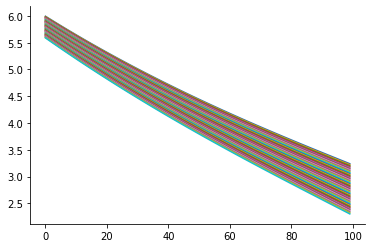

In [325]:
plt.plot(ϕ_list[0])
plt.show()

In [319]:
ems_list = np.array([solu[γ3]["ems"] for γ3 in γ3_list])

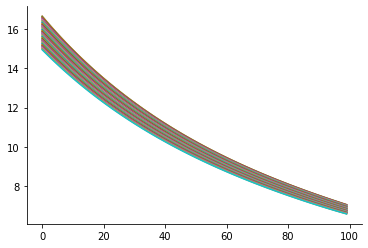

In [324]:
plt.plot(ems_list[0])
# plt.ylim(-6,6)
plt.show()

In [278]:
ξp = 5
ϵ = 0.1
max_iter = 5000
dmg_weight = np.array([1,1,1])/3
ϕ_weight = np.average(np.exp(-1/ξp*ϕ_list), axis=0, weights=dmg_weight)
ϕ_equiv = - ξp*np.log(ϕ_weight)

(y1_mat_cap, y2_mat_cap) = np.meshgrid(y1_grid_cap, y2_grid, indexing = 'ij')
dy1 = y1_grid_cap[1] - y1_grid[0]
dy2 = y2_grid[1] - y2_grid[0]
num_y1 = len(y1_grid_cap)
num_y2 = len(y2_grid)
πa_o = np.ones((len(θ_list), num_y1, num_y2))/len(θ_list)
θ_mat = np.zeros((len(θ_list), num_y1, num_y2))
for i in range(len(θ_list)):
    θ_mat[i] = θ_list[i]
dΛ1 = γ1 + γ2*y1_mat_cap

# initiate v and control
ems = η
ems_old = ems
lhs_error = 1
episode = 0
# v0 =  np.average(ϕ_list, axis=0, weights=dmg_weight)[:numy_bar+1]
v0 = ϕ_equiv[:num_y1]
while lhs_error > tol and episode < max_iter:
    v0_old = v0.copy()
    v0_dy1 = derivatives_2d(v0,0,1,hy1)
#     v0_dyy1 = derivatives_2d(v0,0,2,hy1)
    v0_dy2 = derivatives_2d(v0,1,1,hy2)
#         v0_dy2[v0_dy2 > - 1e-15] =  - 1e-15
#     v0_dyy2 = derivatives_2d(v0,1,2,hy2)
    # updating controls
    weight = np.array([-1/ξa*v0_dy2*λ*ems_old*θ for θ in θ_list])
    weight = weight - np.max(weight, axis=0)
    πa = πa_o*np.exp(weight)
    πa[πa<1e-15] = 1e-15
    πa = πa/np.sum(πa, axis=0)
    ems_new =  - η/(v0_dy2*λ*np.sum(θ_mat*πa, axis=0))
    ems_new[ems_new <= 1e-15] = 1e-15
    ems = ems_new*0.5 + ems_old*0.5
    print(np.min(ems))
    # HJB coefficient
    A =  -δ*np.ones(y1_mat_cap.shape)
    B_y1 =  y2_mat_cap
    B_y2 = λ*( - y2_mat_cap + ems*np.sum(θ_mat*πa, axis=0))
    C_yy1 = np.zeros(y1_mat_cap.shape)
    C_yy2 = np.zeros(y1_mat_cap.shape)
    D = η*np.log(ems) +  (η-1)/δ*dΛ1*y2_mat_cap + ξa*np.sum(πa*(np.log(πa) - np.log(πa_o)), axis=0)
    phi_mat = false_transient_one_iteration_python(A, B_y1, B_y2, C_yy1, C_yy2, D, v0, ϵ, 
                                                   hy1, hy2, 
                                                   bc=(np.zeros(num_y2), ϕ_equiv[num_y1-1], np.zeros(num_y1), np.zeros(num_y1)), 
                                                   impose_bc=(False, True, False, False))
    rhs = A*phi_mat + B_y1*v0_dy1 + B_y2*v0_dy2 + D
    rhs_error = np.max(abs(rhs))
    lhs_error = np.max(abs((phi_mat-v0_old)/ϵ))
    v0 = phi_mat
    ems_old = ems
    episode += 1
    print('Episode: {:d}\t lhs error: {:.12f}\t rhs error: {:.12f}'.format(episode, lhs_error, rhs_error))

0.29318852032113685
Episode: 1	 lhs error: 0.059668660905	 rhs error: 0.086101918744
0.40458452254543037
Episode: 2	 lhs error: 0.057765288491	 rhs error: 0.095867496807
0.4530635181453566
Episode: 3	 lhs error: 0.054716722577	 rhs error: 0.101856120110
0.474353402439952
Episode: 4	 lhs error: 0.052454058032	 rhs error: 0.106865297300
0.48374000493478597
Episode: 5	 lhs error: 0.052423948330	 rhs error: 0.111401858589
0.48788567731832055
Episode: 6	 lhs error: 0.048422310206	 rhs error: 0.115405481735
0.4897180435026076
Episode: 7	 lhs error: 0.049134704438	 rhs error: 0.118951476599
0.49052821228887405
Episode: 8	 lhs error: 0.048103274455	 rhs error: 0.122138986982
0.4908864763360443
Episode: 9	 lhs error: 0.046191882170	 rhs error: 0.125041465373
0.49104491437355047
Episode: 10	 lhs error: 0.045974535570	 rhs error: 0.127437491905
0.49111498375526913
Episode: 11	 lhs error: 0.045638823953	 rhs error: 0.129712750328
0.49114597240748303
Episode: 12	 lhs error: 0.043120937635	 rhs erro

Episode: 97	 lhs error: 0.014689517864	 rhs error: 0.149337964024
0.4911705448439012
Episode: 98	 lhs error: 0.014600368707	 rhs error: 0.149404159713
0.4911705448437842
Episode: 99	 lhs error: 0.014513545268	 rhs error: 0.149572109422
0.49117054484388056
Episode: 100	 lhs error: 0.014426830354	 rhs error: 0.149513482766
0.4911705448439554
Episode: 101	 lhs error: 0.014340287825	 rhs error: 0.149430856603
0.4911705448437368
Episode: 102	 lhs error: 0.014253573030	 rhs error: 0.149454274590
0.49117054484380895
Episode: 103	 lhs error: 0.014166711128	 rhs error: 0.149538664029
0.4911705448439292
Episode: 104	 lhs error: 0.014080283392	 rhs error: 0.149423686866
0.49117054484386663
Episode: 105	 lhs error: 0.013993538135	 rhs error: 0.149526793074
0.4911705448439676
Episode: 106	 lhs error: 0.013907377572	 rhs error: 0.149422007851
0.4911705448438146
Episode: 107	 lhs error: 0.013820843349	 rhs error: 0.149603231481
0.49117054484390155
Episode: 108	 lhs error: 0.013734659244	 rhs error: 0

Episode: 192	 lhs error: 0.010877920975	 rhs error: 0.149279628782
0.4911705448437679
Episode: 193	 lhs error: 0.010859065795	 rhs error: 0.149331724604
0.49117054484383743
Episode: 194	 lhs error: 0.010839599713	 rhs error: 0.149452395124
0.4911705448439123
Episode: 195	 lhs error: 0.010820237875	 rhs error: 0.149422944831
0.49117054484396105
Episode: 196	 lhs error: 0.010800527408	 rhs error: 0.149381731957
0.4911705448440176
Episode: 197	 lhs error: 0.010781532905	 rhs error: 0.149289679367
0.4911705448439032
Episode: 198	 lhs error: 0.010761017703	 rhs error: 0.149458752896
0.49117054484394884
Episode: 199	 lhs error: 0.010740792699	 rhs error: 0.149431563116
0.4911705448439745
Episode: 200	 lhs error: 0.010720325138	 rhs error: 0.149401619955
0.4911705448439949
Episode: 201	 lhs error: 0.010699554552	 rhs error: 0.149362559000
0.4911705448440316
Episode: 202	 lhs error: 0.010679251154	 rhs error: 0.149290355283
0.49117054484376776
Episode: 203	 lhs error: 0.010658183202	 rhs error

Episode: 288	 lhs error: 0.009453958984	 rhs error: 0.149373123427
0.4911705448439539
Episode: 289	 lhs error: 0.009439839513	 rhs error: 0.149351135568
0.4911705448439666
Episode: 290	 lhs error: 0.009425511005	 rhs error: 0.149318332990
0.49117054484399425
Episode: 291	 lhs error: 0.009411605639	 rhs error: 0.149248565782
0.49117054484374734
Episode: 292	 lhs error: 0.009397035254	 rhs error: 0.149306207491
0.4911705448438377
Episode: 293	 lhs error: 0.009382179666	 rhs error: 0.149405826766
0.49117054484389683
Episode: 294	 lhs error: 0.009367380142	 rhs error: 0.149388205012
0.4911705448439294
Episode: 295	 lhs error: 0.009352423884	 rhs error: 0.149364865219
0.49117054484395006
Episode: 296	 lhs error: 0.009337235064	 rhs error: 0.149329145303
0.4911705448439879
Episode: 297	 lhs error: 0.009322647501	 rhs error: 0.149244112211
0.4911705448438768
Episode: 298	 lhs error: 0.009306902719	 rhs error: 0.149421942661
0.49117054484391026
Episode: 299	 lhs error: 0.009291426674	 rhs erro

Episode: 383	 lhs error: 0.008294053772	 rhs error: 0.149246331698
0.49117054484403094
Episode: 384	 lhs error: 0.008282763873	 rhs error: 0.149146509615
0.4911705448439023
Episode: 385	 lhs error: 0.008270486233	 rhs error: 0.149303428765
0.49117054484394007
Episode: 386	 lhs error: 0.008258437000	 rhs error: 0.149287148396
0.49117054484396105
Episode: 387	 lhs error: 0.008246269514	 rhs error: 0.149265972391
0.49117054484398237
Episode: 388	 lhs error: 0.008233900662	 rhs error: 0.149231963603
0.49117054484403166
Episode: 389	 lhs error: 0.008222175479	 rhs error: 0.149142346586
0.491170544843878
Episode: 390	 lhs error: 0.008209357607	 rhs error: 0.149328102513
0.4911705448439183
Episode: 391	 lhs error: 0.008196826881	 rhs error: 0.149318770516
0.4911705448439418
Episode: 392	 lhs error: 0.008184194908	 rhs error: 0.149309161251
0.4911705448439522
Episode: 393	 lhs error: 0.008171459892	 rhs error: 0.149297944300
0.4911705448439594
Episode: 394	 lhs error: 0.008158617336	 rhs error

Episode: 479	 lhs error: 0.007306866371	 rhs error: 0.149306847029
0.4911705448439515
Episode: 480	 lhs error: 0.007296062152	 rhs error: 0.149289122831
0.4911705448439607
Episode: 481	 lhs error: 0.007285143789	 rhs error: 0.149262137058
0.4911705448439879
Episode: 482	 lhs error: 0.007274527445	 rhs error: 0.149207575506
0.4911705448437481
Episode: 483	 lhs error: 0.007263575019	 rhs error: 0.149271114171
0.4911705448438066
Episode: 484	 lhs error: 0.007252261258	 rhs error: 0.149440411804
0.49117054484386946
Episode: 485	 lhs error: 0.007244153704	 rhs error: 0.149434325094
0.4911705448438962
Episode: 486	 lhs error: 0.007236519187	 rhs error: 0.149428533791
0.4911705448439081
Episode: 487	 lhs error: 0.007228818364	 rhs error: 0.149422709989
0.49117054484391504
Episode: 488	 lhs error: 0.007221051004	 rhs error: 0.149416604282
0.4911705448439172
Episode: 489	 lhs error: 0.007213216905	 rhs error: 0.149410015339
0.49117054484392275
Episode: 490	 lhs error: 0.007205315859	 rhs error:

Episode: 575	 lhs error: 0.006482638802	 rhs error: 0.149257586102
0.49117054484380823
Episode: 576	 lhs error: 0.006475450222	 rhs error: 0.149091905785
0.4911705448438756
Episode: 577	 lhs error: 0.006468097545	 rhs error: 0.149174205983
0.49117054484383177
Episode: 578	 lhs error: 0.006460340551	 rhs error: 0.149319487851
0.49117054484390443
Episode: 579	 lhs error: 0.006452735666	 rhs error: 0.149302380816
0.4911705448439468
Episode: 580	 lhs error: 0.006445059599	 rhs error: 0.149278092935
0.4911705448439755
Episode: 581	 lhs error: 0.006437212529	 rhs error: 0.149238057003
0.4911705448440553
Episode: 582	 lhs error: 0.006429841993	 rhs error: 0.149114352891
0.49117054484392764
Episode: 583	 lhs error: 0.006421760203	 rhs error: 0.149241868093
0.4911705448439807
Episode: 584	 lhs error: 0.006413839563	 rhs error: 0.149192795108
0.4911705448438435
Episode: 585	 lhs error: 0.006406144665	 rhs error: 0.149058298041
0.49117054484389777
Episode: 586	 lhs error: 0.006398241579	 rhs erro

Episode: 671	 lhs error: 0.005765722680	 rhs error: 0.149387093684
0.49117054484390676
Episode: 672	 lhs error: 0.005758034223	 rhs error: 0.149376719583
0.49117054484391987
Episode: 673	 lhs error: 0.005750297798	 rhs error: 0.149366265525
0.4911705448439305
Episode: 674	 lhs error: 0.005742512999	 rhs error: 0.149355089155
0.49117054484393796
Episode: 675	 lhs error: 0.005734679195	 rhs error: 0.149342495826
0.49117054484394207
Episode: 676	 lhs error: 0.005727670452	 rhs error: 0.149327484511
0.4911705448439524
Episode: 677	 lhs error: 0.005721698051	 rhs error: 0.149308414086
0.49117054484396594
Episode: 678	 lhs error: 0.005715665575	 rhs error: 0.149281601323
0.49117054484398726
Episode: 679	 lhs error: 0.005709412343	 rhs error: 0.149234991895
0.49117054484410616
Episode: 680	 lhs error: 0.005703697205	 rhs error: 0.149036267392
0.49117054484396794
Episode: 681	 lhs error: 0.005697599662	 rhs error: 0.149147000364
0.49117054484373945
Episode: 682	 lhs error: 0.005691643684	 rhs 

Episode: 767	 lhs error: 0.005149291289	 rhs error: 0.149496219633
0.4911705448397894
Episode: 768	 lhs error: 0.005142668361	 rhs error: 0.149244684006
0.4911705448421818
Episode: 769	 lhs error: 0.005136330578	 rhs error: 0.149255947529
0.4911705448432124
Episode: 770	 lhs error: 0.005129952509	 rhs error: 0.149256713092
0.4911705448436554
Episode: 771	 lhs error: 0.005123533451	 rhs error: 0.149250554281
0.49117054484384765
Episode: 772	 lhs error: 0.005117071127	 rhs error: 0.149238261525
0.4911705448439362
Episode: 773	 lhs error: 0.005110557257	 rhs error: 0.149217776984
0.4911705448439845
Episode: 774	 lhs error: 0.005103922041	 rhs error: 0.149180182267
0.49117054484408024
Episode: 775	 lhs error: 0.005097675517	 rhs error: 0.149061475128
0.4911705448439168
Episode: 776	 lhs error: 0.005090870887	 rhs error: 0.149215869260
0.4911705448439715
Episode: 777	 lhs error: 0.005084194518	 rhs error: 0.149192965036
0.4911705448440194
Episode: 778	 lhs error: 0.005077767138	 rhs error: 

Episode: 863	 lhs error: 0.004606087641	 rhs error: 0.149108820073
0.4911705448438807
Episode: 864	 lhs error: 0.004600741338	 rhs error: 0.149194528304
0.49117054484361555
Episode: 865	 lhs error: 0.004594960546	 rhs error: 0.149444498627
0.4911705448437902
Episode: 866	 lhs error: 0.004589366096	 rhs error: 0.149437768315
0.4911705448438666
Episode: 867	 lhs error: 0.004583740103	 rhs error: 0.149430936164
0.4911705448438988
Episode: 868	 lhs error: 0.004578081854	 rhs error: 0.149423763193
0.49117054484391587
Episode: 869	 lhs error: 0.004572391581	 rhs error: 0.149416362342
0.49117054484391764
Episode: 870	 lhs error: 0.004566669266	 rhs error: 0.149408602802
0.49117054484392486
Episode: 871	 lhs error: 0.004560914854	 rhs error: 0.149400366474
0.4911705448439262
Episode: 872	 lhs error: 0.004555128295	 rhs error: 0.149391489577
0.49117054484392686
Episode: 873	 lhs error: 0.004550079143	 rhs error: 0.149381803592
0.4911705448439317
Episode: 874	 lhs error: 0.004545372748	 rhs erro

Episode: 959	 lhs error: 0.004126214500	 rhs error: 0.149256281054
0.49117054484398565
Episode: 960	 lhs error: 0.004121085304	 rhs error: 0.149229390621
0.4911705448440128
Episode: 961	 lhs error: 0.004116846831	 rhs error: 0.149177453778
0.49117054484375455
Episode: 962	 lhs error: 0.004112594352	 rhs error: 0.149245639662
0.49117054484363876
Episode: 963	 lhs error: 0.004108314319	 rhs error: 0.149303497329
0.4911705448437851
Episode: 964	 lhs error: 0.004103974320	 rhs error: 0.149403399892
0.4911705448438625
Episode: 965	 lhs error: 0.004099645628	 rhs error: 0.149394612214
0.4911705448438943
Episode: 966	 lhs error: 0.004095291274	 rhs error: 0.149382915952
0.4911705448439128
Episode: 967	 lhs error: 0.004090911048	 rhs error: 0.149368634752
0.49117054484392464
Episode: 968	 lhs error: 0.004086504566	 rhs error: 0.149351553208
0.4911705448439362
Episode: 969	 lhs error: 0.004082070945	 rhs error: 0.149330740184
0.4911705448439494
Episode: 970	 lhs error: 0.004077607365	 rhs error

Episode: 1055	 lhs error: 0.003706811894	 rhs error: 0.149231763129
0.4911705448436524
Episode: 1056	 lhs error: 0.003702682111	 rhs error: 0.149291764726
0.49117054484378553
Episode: 1057	 lhs error: 0.003698490948	 rhs error: 0.149403885501
0.4911705448438562
Episode: 1058	 lhs error: 0.003694306888	 rhs error: 0.149395117002
0.49117054484389683
Episode: 1059	 lhs error: 0.003690100255	 rhs error: 0.149384181408
0.49117054484391576
Episode: 1060	 lhs error: 0.003685870966	 rhs error: 0.149371352371
0.491170544843924
Episode: 1061	 lhs error: 0.003681618900	 rhs error: 0.149356578892
0.4911705448439352
Episode: 1062	 lhs error: 0.003677343837	 rhs error: 0.149339449302
0.4911705448439436
Episode: 1063	 lhs error: 0.003673045284	 rhs error: 0.149318964865
0.4911705448439556
Episode: 1064	 lhs error: 0.003668721705	 rhs error: 0.149292817608
0.49117054484397626
Episode: 1065	 lhs error: 0.003664363559	 rhs error: 0.149254470096
0.49117054484402867
Episode: 1066	 lhs error: 0.00470083662

Episode: 1151	 lhs error: 0.003332094925	 rhs error: 0.149363059346
0.4911705448439386
Episode: 1152	 lhs error: 0.003328514603	 rhs error: 0.149348237361
0.4911705448439441
Episode: 1153	 lhs error: 0.003324915129	 rhs error: 0.149331765622
0.4911705448439485
Episode: 1154	 lhs error: 0.003321296428	 rhs error: 0.149312757673
0.4911705448439622
Episode: 1155	 lhs error: 0.003317658314	 rhs error: 0.149289470495
0.4911705448439756
Episode: 1156	 lhs error: 0.003313999925	 rhs error: 0.149257712766
0.49117054484400574
Episode: 1157	 lhs error: 0.003310304597	 rhs error: 0.149202353582
0.49117054484386125
Episode: 1158	 lhs error: 0.003306644694	 rhs error: 0.149056178854
0.49117054484390166
Episode: 1159	 lhs error: 0.003302931449	 rhs error: 0.149138904057
0.4911705448438635
Episode: 1160	 lhs error: 0.003299181220	 rhs error: 0.149257040825
0.49117054484394984
Episode: 1161	 lhs error: 0.003295423898	 rhs error: 0.149222962504
0.49117054484403483
Episode: 1162	 lhs error: 0.0033384606

Episode: 1248	 lhs error: 0.002995905240	 rhs error: 0.149345961281
0.4911705448439401
Episode: 1249	 lhs error: 0.002992618589	 rhs error: 0.149339094132
0.49117054484394773
Episode: 1250	 lhs error: 0.002989315386	 rhs error: 0.149331999854
0.49117054484393924
Episode: 1251	 lhs error: 0.002985995415	 rhs error: 0.149324483464
0.4911705448439445
Episode: 1252	 lhs error: 0.002982658926	 rhs error: 0.149316108462
0.49117054484395234
Episode: 1253	 lhs error: 0.002979305868	 rhs error: 0.149306623346
0.491170544843954
Episode: 1254	 lhs error: 0.002975936294	 rhs error: 0.149295626770
0.4911705448439629
Episode: 1255	 lhs error: 0.002972550314	 rhs error: 0.149282483616
0.49117054484396694
Episode: 1256	 lhs error: 0.002969148185	 rhs error: 0.149266076258
0.49117054484397143
Episode: 1257	 lhs error: 0.002965730672	 rhs error: 0.149244127243
0.49117054484399003
Episode: 1258	 lhs error: 0.002962301803	 rhs error: 0.149210541692
0.4911705448440387
Episode: 1259	 lhs error: 0.0029590243

Episode: 1344	 lhs error: 0.003725450894	 rhs error: 0.149110037855
0.49117054484386113
Episode: 1345	 lhs error: 0.002695593205	 rhs error: 0.149299468577
0.49117054484391565
Episode: 1346	 lhs error: 0.002692815314	 rhs error: 0.149292071969
0.49117054484394057
Episode: 1347	 lhs error: 0.002690023309	 rhs error: 0.149284173296
0.4911705448439553
Episode: 1348	 lhs error: 0.002687217419	 rhs error: 0.149275248979
0.49117054484396816
Episode: 1349	 lhs error: 0.002684397914	 rhs error: 0.149264653536
0.49117054484397576
Episode: 1350	 lhs error: 0.002681565267	 rhs error: 0.149251430211
0.49117054484398265
Episode: 1351	 lhs error: 0.002678720639	 rhs error: 0.149233876182
0.4911705448439949
Episode: 1352	 lhs error: 0.002675868512	 rhs error: 0.149208175075
0.4911705448440198
Episode: 1353	 lhs error: 0.002672952501	 rhs error: 0.149161449728
0.49117054484383693
Episode: 1354	 lhs error: 0.002670058267	 rhs error: 0.149088530450
0.4911705448438846
Episode: 1355	 lhs error: 0.00405740

Episode: 1439	 lhs error: 0.002435928992	 rhs error: 0.149369193986
0.49117054484393463
Episode: 1440	 lhs error: 0.002433182412	 rhs error: 0.149355606868
0.49117054484393885
Episode: 1441	 lhs error: 0.002430656785	 rhs error: 0.149341252658
0.49117054484394795
Episode: 1442	 lhs error: 0.002428176599	 rhs error: 0.149325789209
0.49117054484395567
Episode: 1443	 lhs error: 0.002425685039	 rhs error: 0.149308617676
0.4911705448439656
Episode: 1444	 lhs error: 0.002423183022	 rhs error: 0.149288652686
0.4911705448439766
Episode: 1445	 lhs error: 0.002420673301	 rhs error: 0.149263679893
0.4911705448439916
Episode: 1446	 lhs error: 0.002418170317	 rhs error: 0.149227847106
0.4911705448440356
Episode: 1447	 lhs error: 0.002415473898	 rhs error: 0.149154673355
0.4911705448437677
Episode: 1448	 lhs error: 0.004577641621	 rhs error: 0.149226707256
0.4911705448437392
Episode: 1449	 lhs error: 0.002410414094	 rhs error: 0.149462241781
0.4911705448438377
Episode: 1450	 lhs error: 0.00240783304

Episode: 1534	 lhs error: 0.002199810457	 rhs error: 0.149210871864
0.49117054484398137
Episode: 1535	 lhs error: 0.002197316585	 rhs error: 0.149180660657
0.4911705448440541
Episode: 1536	 lhs error: 0.002194566232	 rhs error: 0.149107672591
0.4911705448437684
Episode: 1537	 lhs error: 0.004409656580	 rhs error: 0.149186553641
0.4911705448437402
Episode: 1538	 lhs error: 0.002189520122	 rhs error: 0.149413827355
0.4911705448438407
Episode: 1539	 lhs error: 0.002186938243	 rhs error: 0.149405256241
0.4911705448438909
Episode: 1540	 lhs error: 0.002184344301	 rhs error: 0.149397554945
0.4911705448439112
Episode: 1541	 lhs error: 0.002181738627	 rhs error: 0.149390382714
0.49117054484391914
Episode: 1542	 lhs error: 0.002179121397	 rhs error: 0.149383468548
0.4911705448439282
Episode: 1543	 lhs error: 0.002176492716	 rhs error: 0.149376614445
0.49117054484393224
Episode: 1544	 lhs error: 0.002173852658	 rhs error: 0.149369663221
0.4911705448439341
Episode: 1545	 lhs error: 0.002171201267

Episode: 1630	 lhs error: 0.001904693761	 rhs error: 0.149328207920
0.49117054484394407
Episode: 1631	 lhs error: 0.001901099363	 rhs error: 0.149320574451
0.49117054484394496
Episode: 1632	 lhs error: 0.001897495431	 rhs error: 0.149312086531
0.4911705448439507
Episode: 1633	 lhs error: 0.001893882118	 rhs error: 0.149302519509
0.49117054484395595
Episode: 1634	 lhs error: 0.001890259719	 rhs error: 0.149291528691
0.49117054484396194
Episode: 1635	 lhs error: 0.001886628750	 rhs error: 0.149278572139
0.4911705448439655
Episode: 1636	 lhs error: 0.001882990308	 rhs error: 0.149262677021
0.49117054484397543
Episode: 1637	 lhs error: 0.001879347372	 rhs error: 0.149241857498
0.4911705448439937
Episode: 1638	 lhs error: 0.001875713850	 rhs error: 0.149211132628
0.4911705448440311
Episode: 1639	 lhs error: 0.001871858905	 rhs error: 0.149150133542
0.4911705448437648
Episode: 1640	 lhs error: 0.001868171426	 rhs error: 0.149222709348
0.49117054484364775
Episode: 1641	 lhs error: 0.002953916

Episode: 1725	 lhs error: 0.001525673822	 rhs error: 0.149387168782
0.4911705448439281
Episode: 1726	 lhs error: 0.001521378558	 rhs error: 0.149377549140
0.4911705448439312
Episode: 1727	 lhs error: 0.001517079228	 rhs error: 0.149367612792
0.4911705448439335
Episode: 1728	 lhs error: 0.001512776333	 rhs error: 0.149357212900
0.49117054484393563
Episode: 1729	 lhs error: 0.001508469637	 rhs error: 0.149346313866
0.49117054484394296
Episode: 1730	 lhs error: 0.001504159482	 rhs error: 0.149334666811
0.49117054484394707
Episode: 1731	 lhs error: 0.001499846132	 rhs error: 0.149321993950
0.4911705448439506
Episode: 1732	 lhs error: 0.001495530010	 rhs error: 0.149307857736
0.4911705448439559
Episode: 1733	 lhs error: 0.001491211879	 rhs error: 0.149291531442
0.4911705448439691
Episode: 1734	 lhs error: 0.001486893523	 rhs error: 0.149271634506
0.4911705448439807
Episode: 1735	 lhs error: 0.001482580918	 rhs error: 0.149245091745
0.49117054484400535
Episode: 1736	 lhs error: 0.00232734839

Episode: 1822	 lhs error: 0.001102259268	 rhs error: 0.149408284208
0.49117054484391764
Episode: 1823	 lhs error: 0.001097965634	 rhs error: 0.149397783887
0.4911705448439212
Episode: 1824	 lhs error: 0.001093676378	 rhs error: 0.149386860710
0.49117054484393097
Episode: 1825	 lhs error: 0.001089391627	 rhs error: 0.149375481111
0.4911705448439272
Episode: 1826	 lhs error: 0.001085111518	 rhs error: 0.149363538850
0.49117054484393263
Episode: 1827	 lhs error: 0.001080836269	 rhs error: 0.149350867937
0.4911705448439405
Episode: 1828	 lhs error: 0.001076566152	 rhs error: 0.149337198597
0.49117054484394795
Episode: 1829	 lhs error: 0.001072301586	 rhs error: 0.149322088327
0.49117054484395567
Episode: 1830	 lhs error: 0.001068043356	 rhs error: 0.149304797727
0.4911705448439646
Episode: 1831	 lhs error: 0.001063793266	 rhs error: 0.149283906655
0.491170544843974
Episode: 1832	 lhs error: 0.001059557562	 rhs error: 0.149256226928
0.4911705448439967
Episode: 1833	 lhs error: 0.00256343323

Episode: 1918	 lhs error: 0.000719571983	 rhs error: 0.149293448016
0.49117054484397416
Episode: 1919	 lhs error: 0.000716013764	 rhs error: 0.149266551486
0.49117054484399547
Episode: 1920	 lhs error: 0.002072917424	 rhs error: 0.149224649647
0.49117054484406764
Episode: 1921	 lhs error: 0.002848797153	 rhs error: 0.149109527160
0.49117054484391043
Episode: 1922	 lhs error: 0.000705337824	 rhs error: 0.149251278783
0.49117054484396183
Episode: 1923	 lhs error: 0.000701821387	 rhs error: 0.149228591545
0.49117054484399786
Episode: 1924	 lhs error: 0.002008904632	 rhs error: 0.149190625745
0.4911705448440826
Episode: 1925	 lhs error: 0.003008911398	 rhs error: 0.149081291382
0.49117054484391415
Episode: 1926	 lhs error: 0.000691261116	 rhs error: 0.149232990312
0.4911705448439619
Episode: 1927	 lhs error: 0.000687782224	 rhs error: 0.149214054599
0.4911705448439979
Episode: 1928	 lhs error: 0.001350868976	 rhs error: 0.149183078340
0.4911705448440597
Episode: 1929	 lhs error: 0.00098707

Episode: 2013	 lhs error: 0.000427943262	 rhs error: 0.149399240204
0.49117054484391065
Episode: 2014	 lhs error: 0.000425408475	 rhs error: 0.149391973043
0.49117054484389777
Episode: 2015	 lhs error: 0.000422885445	 rhs error: 0.149384536984
0.49117054484391615
Episode: 2016	 lhs error: 0.000420373194	 rhs error: 0.149377062762
0.4911705448439241
Episode: 2017	 lhs error: 0.000417872118	 rhs error: 0.149369208249
0.49117054484392764
Episode: 2018	 lhs error: 0.000415382303	 rhs error: 0.149360805565
0.49117054484393563
Episode: 2019	 lhs error: 0.000412903814	 rhs error: 0.149351680683
0.4911705448439383
Episode: 2020	 lhs error: 0.000410436764	 rhs error: 0.149341624320
0.4911705448439395
Episode: 2021	 lhs error: 0.000407981314	 rhs error: 0.149330347013
0.4911705448439482
Episode: 2022	 lhs error: 0.000405537795	 rhs error: 0.149317395663
0.4911705448439503
Episode: 2023	 lhs error: 0.000403106865	 rhs error: 0.149302016626
0.4911705448439606
Episode: 2024	 lhs error: 0.0004424015

Episode: 2107	 lhs error: 0.002036475625	 rhs error: 0.149314653389
0.4911705448437852
Episode: 2108	 lhs error: 0.000233932736	 rhs error: 0.149419995880
0.4911705448438588
Episode: 2109	 lhs error: 0.000232361113	 rhs error: 0.149411278618
0.49117054484389144
Episode: 2110	 lhs error: 0.000230798750	 rhs error: 0.149400410208
0.49117054484390965
Episode: 2111	 lhs error: 0.000229245538	 rhs error: 0.149387860986
0.4911705448439184
Episode: 2112	 lhs error: 0.000234879310	 rhs error: 0.149373753161
0.4911705448439261
Episode: 2113	 lhs error: 0.000275499631	 rhs error: 0.149357910572
0.4911705448439371
Episode: 2114	 lhs error: 0.000337782034	 rhs error: 0.149339762897
0.4911705448439463
Episode: 2115	 lhs error: 0.000451570335	 rhs error: 0.149318098641
0.4911705448439578
Episode: 2116	 lhs error: 0.000725004208	 rhs error: 0.149290063308
0.4911705448439758
Episode: 2117	 lhs error: 0.002126332632	 rhs error: 0.149246932847
0.49117054484405165
Episode: 2118	 lhs error: 0.002679594517

Episode: 2203	 lhs error: 0.000195527183	 rhs error: 0.149347024904
0.49117054484394607
Episode: 2204	 lhs error: 0.000226021137	 rhs error: 0.149334804660
0.4911705448439492
Episode: 2205	 lhs error: 0.000274122064	 rhs error: 0.149320694211
0.49117054484395506
Episode: 2206	 lhs error: 0.000357138572	 rhs error: 0.149303715813
0.49117054484396544
Episode: 2207	 lhs error: 0.000528435995	 rhs error: 0.149281936832
0.49117054484397904
Episode: 2208	 lhs error: 0.001058393476	 rhs error: 0.149250493007
0.491170544844007
Episode: 2209	 lhs error: 0.000767663188	 rhs error: 0.149189878325
0.4911705448437569
Episode: 2210	 lhs error: 0.004338029524	 rhs error: 0.149256487416
0.49117054484356815
Episode: 2211	 lhs error: 0.000193215075	 rhs error: 0.149505974142
0.4911705448437677
Episode: 2212	 lhs error: 0.000183796981	 rhs error: 0.149497757569
0.49117054484385003
Episode: 2213	 lhs error: 0.000172263364	 rhs error: 0.149488969731
0.4911705448438839
Episode: 2214	 lhs error: 0.0001628641

Episode: 2297	 lhs error: 0.000196355498	 rhs error: 0.149367233636
0.4911705448439345
Episode: 2298	 lhs error: 0.000215290116	 rhs error: 0.149354906976
0.49117054484393763
Episode: 2299	 lhs error: 0.000246713843	 rhs error: 0.149341281808
0.4911705448439465
Episode: 2300	 lhs error: 0.000298977950	 rhs error: 0.149325692148
0.49117054484395223
Episode: 2301	 lhs error: 0.000394187330	 rhs error: 0.149306995789
0.49117054484395944
Episode: 2302	 lhs error: 0.000606548487	 rhs error: 0.149282822109
0.4911705448439767
Episode: 2303	 lhs error: 0.001408134983	 rhs error: 0.149246735467
0.4911705448440263
Episode: 2304	 lhs error: 0.003907744046	 rhs error: 0.149166793690
0.4911705448436883
Episode: 2305	 lhs error: 0.000175317088	 rhs error: 0.149384212084
0.49117054484382616
Episode: 2306	 lhs error: 0.000166622079	 rhs error: 0.149376522000
0.49117054484388634
Episode: 2307	 lhs error: 0.000163454298	 rhs error: 0.149368423884
0.49117054484391187
Episode: 2308	 lhs error: 0.000166311

Episode: 2394	 lhs error: 0.000332541024	 rhs error: 0.149439498037
0.4911705448438562
Episode: 2395	 lhs error: 0.000244982570	 rhs error: 0.149428721599
0.4911705448438894
Episode: 2396	 lhs error: 0.000199425645	 rhs error: 0.149419579821
0.4911705448439143
Episode: 2397	 lhs error: 0.000172155249	 rhs error: 0.149411487583
0.4911705448439244
Episode: 2398	 lhs error: 0.000154274894	 rhs error: 0.149404017266
0.4911705448439277
Episode: 2399	 lhs error: 0.000143662345	 rhs error: 0.149396835844
0.49117054484393097
Episode: 2400	 lhs error: 0.000138650899	 rhs error: 0.149389679069
0.4911705448439336
Episode: 2401	 lhs error: 0.000138638982	 rhs error: 0.149382344347
0.49117054484393186
Episode: 2402	 lhs error: 0.000142718320	 rhs error: 0.149374627728
0.4911705448439312
Episode: 2403	 lhs error: 0.000150967458	 rhs error: 0.149366361320
0.49117054484393274
Episode: 2404	 lhs error: 0.000164091999	 rhs error: 0.149357357666
0.4911705448439371
Episode: 2405	 lhs error: 0.000183236753

Episode: 2491	 lhs error: 0.000220154260	 rhs error: 0.149469247827
0.4911705448438969
Episode: 2492	 lhs error: 0.000191560415	 rhs error: 0.149458996386
0.4911705448439063
Episode: 2493	 lhs error: 0.000172097319	 rhs error: 0.149449534957
0.4911705448439142
Episode: 2494	 lhs error: 0.000159381236	 rhs error: 0.149440525341
0.4911705448439168
Episode: 2495	 lhs error: 0.000151728697	 rhs error: 0.149431724200
0.49117054484391715
Episode: 2496	 lhs error: 0.000148169973	 rhs error: 0.149422948646
0.4911705448439227
Episode: 2497	 lhs error: 0.000148085681	 rhs error: 0.149414045533
0.4911705448439261
Episode: 2498	 lhs error: 0.000150964997	 rhs error: 0.149404875779
0.4911705448439284
Episode: 2499	 lhs error: 0.000156720598	 rhs error: 0.149395316571
0.49117054484392875
Episode: 2500	 lhs error: 0.000165994784	 rhs error: 0.149385241785
0.4911705448439315
Episode: 2501	 lhs error: 0.000179273716	 rhs error: 0.149374475600
0.4911705448439328
Episode: 2502	 lhs error: 0.000198300462	

Episode: 2588	 lhs error: 0.000350484279	 rhs error: 0.149382418880
0.4911705448438791
Episode: 2589	 lhs error: 0.000261639489	 rhs error: 0.149374748307
0.49117054484391326
Episode: 2590	 lhs error: 0.000196973157	 rhs error: 0.149368459310
0.4911705448439265
Episode: 2591	 lhs error: 0.000149570791	 rhs error: 0.149362926191
0.49117054484393324
Episode: 2592	 lhs error: 0.000132386962	 rhs error: 0.149357696998
0.4911705448439363
Episode: 2593	 lhs error: 0.000127429693	 rhs error: 0.149352409798
0.49117054484393874
Episode: 2594	 lhs error: 0.000128611518	 rhs error: 0.149346790476
0.49117054484393974
Episode: 2595	 lhs error: 0.000135813748	 rhs error: 0.149340601831
0.4911705448439402
Episode: 2596	 lhs error: 0.000148943580	 rhs error: 0.149333582915
0.4911705448439413
Episode: 2597	 lhs error: 0.000169614819	 rhs error: 0.149325460135
0.4911705448439436
Episode: 2598	 lhs error: 0.000200726234	 rhs error: 0.149315850036
0.49117054484395195
Episode: 2599	 lhs error: 0.0002489594

Episode: 2684	 lhs error: 0.000748262872	 rhs error: 0.149194988777
0.4911705448437537
Episode: 2685	 lhs error: 0.000590599323	 rhs error: 0.149260829091
0.4911705448436413
Episode: 2686	 lhs error: 0.001724978506	 rhs error: 0.149316651718
0.49117054484378614
Episode: 2687	 lhs error: 0.000152911622	 rhs error: 0.149404480616
0.4911705448438573
Episode: 2688	 lhs error: 0.000212448089	 rhs error: 0.149392333764
0.4911705448438962
Episode: 2689	 lhs error: 0.000271348406	 rhs error: 0.149376930899
0.49117054484391687
Episode: 2690	 lhs error: 0.000348409095	 rhs error: 0.149358270252
0.491170544843934
Episode: 2691	 lhs error: 0.000481746000	 rhs error: 0.149335326105
0.49117054484394596
Episode: 2692	 lhs error: 0.000815455253	 rhs error: 0.149304977288
0.4911705448439686
Episode: 2693	 lhs error: 0.003259360093	 rhs error: 0.149256269310
0.49117054484408074
Episode: 2694	 lhs error: 0.002200024880	 rhs error: 0.149075776881
0.4911705448439546
Episode: 2695	 lhs error: 0.002305388147

Episode: 2779	 lhs error: 0.000205282278	 rhs error: 0.149466077772
0.4911705448438456
Episode: 2780	 lhs error: 0.000178694351	 rhs error: 0.149457201012
0.4911705448438875
Episode: 2781	 lhs error: 0.000160995209	 rhs error: 0.149448832840
0.49117054484390443
Episode: 2782	 lhs error: 0.000150007541	 rhs error: 0.149440711695
0.4911705448439089
Episode: 2783	 lhs error: 0.000144187368	 rhs error: 0.149432638054
0.4911705448439127
Episode: 2784	 lhs error: 0.000142181236	 rhs error: 0.149424446402
0.49117054484391875
Episode: 2785	 lhs error: 0.000143054815	 rhs error: 0.149416015495
0.49117054484392175
Episode: 2786	 lhs error: 0.000146717476	 rhs error: 0.149407250955
0.491170544843923
Episode: 2787	 lhs error: 0.000152814168	 rhs error: 0.149398043142
0.49117054484393163
Episode: 2788	 lhs error: 0.000161676533	 rhs error: 0.149388293213
0.4911705448439329
Episode: 2789	 lhs error: 0.000174195601	 rhs error: 0.149377871182
0.49117054484393274
Episode: 2790	 lhs error: 0.00019186983

Episode: 2875	 lhs error: 0.000336275844	 rhs error: 0.149328407036
0.4911705448439442
Episode: 2876	 lhs error: 0.000466822099	 rhs error: 0.149307464519
0.49117054484395756
Episode: 2877	 lhs error: 0.000801802616	 rhs error: 0.149279127666
0.49117054484398226
Episode: 2878	 lhs error: 0.003221178925	 rhs error: 0.149232215278
0.49117054484409683
Episode: 2879	 lhs error: 0.002274969802	 rhs error: 0.149054540909
0.49117054484395833
Episode: 2880	 lhs error: 0.002016432860	 rhs error: 0.149163138031
0.49117054484380773
Episode: 2881	 lhs error: 0.001682736903	 rhs error: 0.149091377349
0.4911705448438773
Episode: 2882	 lhs error: 0.002290866855	 rhs error: 0.149171061268
0.491170544843863
Episode: 2883	 lhs error: 0.000475658611	 rhs error: 0.149289097133
0.49117054484392086
Episode: 2884	 lhs error: 0.000828679079	 rhs error: 0.149261014509
0.49117054484396955
Episode: 2885	 lhs error: 0.002224733775	 rhs error: 0.149213094939
0.4911705448438174
Episode: 2886	 lhs error: 0.001711986

Episode: 2969	 lhs error: 0.001418071906	 rhs error: 0.149247796137
0.49117054484402356
Episode: 2970	 lhs error: 0.003813164707	 rhs error: 0.149167181719
0.49117054484369593
Episode: 2971	 lhs error: 0.000172737226	 rhs error: 0.149379874733
0.4911705448438332
Episode: 2972	 lhs error: 0.000167233080	 rhs error: 0.149372062593
0.49117054484389133
Episode: 2973	 lhs error: 0.000167752727	 rhs error: 0.149363702842
0.49117054484391864
Episode: 2974	 lhs error: 0.000174303125	 rhs error: 0.149354653732
0.49117054484393075
Episode: 2975	 lhs error: 0.000188601242	 rhs error: 0.149344725642
0.49117054484393524
Episode: 2976	 lhs error: 0.000213206472	 rhs error: 0.149333589538
0.4911705448439392
Episode: 2977	 lhs error: 0.000253982078	 rhs error: 0.149320742480
0.4911705448439463
Episode: 2978	 lhs error: 0.000323852778	 rhs error: 0.149305326120
0.4911705448439578
Episode: 2979	 lhs error: 0.000461329769	 rhs error: 0.149285751174
0.49117054484396844
Episode: 2980	 lhs error: 0.00082856

KeyboardInterrupt: 

In [279]:
y1_grid_cap.shape

(51,)

In [280]:
ϕ_equiv.shape, n_y1, ϕ_equiv[:n_y1].shape

((100, 50), 100, (100, 50))

In [327]:
phi_mat[-1] - ϕ_equiv[numy_bar]

array([-4.76618744e-13, -4.12558876e-13, -3.46112028e-13, -2.76889622e-13,
       -2.04891659e-13, -1.30645494e-13, -5.38458167e-14,  2.53443100e-14,
        1.07039377e-13,  1.91291427e-13,  2.78221890e-13,  3.67705866e-13,
        4.59854377e-13,  5.55111512e-13,  6.53033183e-13,  7.54063478e-13,
        8.57536264e-13,  9.64339719e-13,  1.07469589e-12,  1.18771659e-12,
        1.30473410e-12,  1.42419410e-12,  1.54742885e-12,  1.67399428e-12,
        1.80389037e-12,  1.93800531e-12,  2.07656115e-12,  2.21689334e-12,
        2.36166642e-12,  2.51088039e-12,  2.66409117e-12,  2.82174284e-12,
        2.98205904e-12,  3.14770432e-12,  3.31690231e-12,  3.48965301e-12,
        3.66817687e-12,  3.85114163e-12,  4.03765910e-12,  4.22772928e-12,
        4.42401671e-12,  4.62474503e-12,  4.82902607e-12,  5.03863617e-12,
        5.25179900e-12,  5.47295542e-12,  5.69500003e-12,  5.92326188e-12,
        6.15241191e-12,  6.38955555e-12])

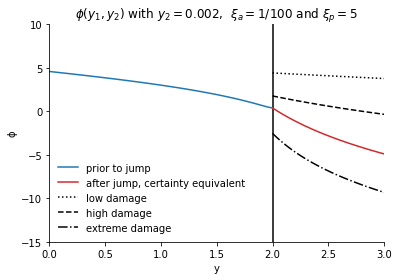

In [406]:
# 
plt.plot(y1_grid[:numy_bar+1],phi_mat[:,2], color="tab:blue",label="prior to jump")
plt.plot(y1_grid[numy_bar:], ϕ_equiv[numy_bar:][:,2], color="tab:red", label="after jump, certainty equivalent")
plt.plot(y1_grid[numy_bar:], ϕ_list[0][numy_bar:,2], color="black", linestyle=":", label="low damage")
plt.plot(y1_grid[numy_bar:], ϕ_list[1][numy_bar:,2], color="black", linestyle="--", label="high damage")
plt.plot(y1_grid[numy_bar:], ϕ_list[2][numy_bar:,2], color="black", linestyle="-.", label="extreme damage")

plt.legend(frameon=False)
plt.title("$ϕ(y_1, y_2)$ with $y_2 = 0.002$,  $ξ_a = 1/100$ and $ξ_p = 5$")
plt.vlines(2, ymax=10, ymin=-15, color="black")
plt.xlim(0, 3)
plt.ylim(-15,10)
plt.xlabel("y")
plt.ylabel("ϕ")
# plt.savefig("./paper_plots/2_state_value_function.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")
plt.show()

In [329]:
(np.abs(y2_grid - θ)).argmin()

2

In [330]:
y2_grid[2]

0.002

ValueError: x and y must have same first dimension, but have shapes (100,) and (51,)

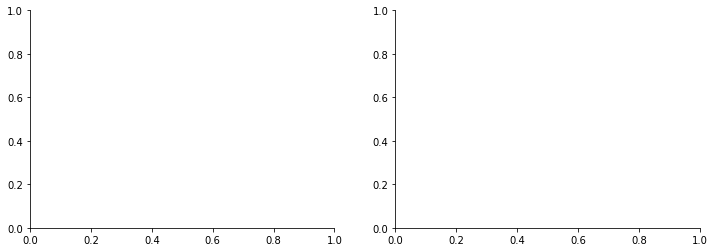

In [242]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], v0[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], v0[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], v0[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$ϕ(y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.legend()
# ax1.tick_params(labelsize=20)
ax1.set_xlim(0)
# ax1.set_ylim(-0.18, 0.05)
ax2.plot(y2_mat[0], v0[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], v0[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], v0[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$ϕ(y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.legend()
# ax2.set_ylim(-0.18, 0.05)
fig.tight_layout()
# plt.savefig("ϕ.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [ ]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.plot(y1_mat[:,0], ems[:,0], label="$y_2$ = {:.2f}".format(y2_mat[0,0]))
ax1.plot(y1_mat[:,0], ems[:,int(n_y2/2)], label="$y_2$ = {:.2f}".format(y2_mat[0,int(n_y2/2)]))
ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}\ (y_1; y_2)$', size=20)
ax1.set_xlabel("$y_1$", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(y2_mat[0], ems[0], label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.plot(y2_mat[10], ems[int(n_y1/2)], label="$y_1$ = {:.2f}".format(y1_mat[int(n_y1/2),0]))
ax2.plot(y2_mat[-1], ems[-1], label="$y_1$ = {:.2f}".format(y1_mat[-1,0]))
ax2.set_title('$\mathcal{E}\ ( y_2; y_1)$', size=20)
ax2.set_xlabel('$y_2$', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
ax2.legend()
# ax2.set_ylim(0,12)
fig.tight_layout()
# plt.savefig("E.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [156]:
from scipy import interpolate
def simualte_ems(y1_grid, y2_grid, ems, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
    Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp2d(y2_grid, y1_grid, ems, )
#     f_π = interpolate.interp2d(y2_grid, y1_grid, πa, )
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y2, y1)
#         π_list = f_π(y2, y1)
        ems_t[t] = ems_point[0]
        Y1t[t] = y1
        Y2t[t] = y2
        y1 += y2*dt
        y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, Y2t, ems_t

In [186]:
def simulation(y1_grid, y2_grid, e_grid, λ, θ=1.86/1000., y1_0=.5394, y2_0=1.86/1000, T=100):
    e_fun = interpolate.interp2d(y1_grid, y2_grid, e_grid.T)
    Et = np.zeros(T+1)
    y1t = np.zeros(T+1)
    y2t = np.zeros(T+1)
    for i in range(T+1):
        Et[i] = e_fun(y1_0, y2_0)
        y1t[i] = y1_0
        y2t[i] = y2_0
        y2_0 = y2_0 - λ*y2_0 + λ*θ*Et[i] 
        y1_0 = y1_0 + y2_0
    return Et, y1t, y2t

In [249]:
et_list = list()
for γ3 in γ3_list:
    Y1t,Y2t, Et = simualte_ems(y1_grid, y2_grid, solu[γ3]["ems"],  dt=1/4)
    et_list.append(Et)

In [294]:
et_list_compare = list()
for γ3 in γ3_list:
    Et, Y1t,Y2t,  = simulation(y1_grid, y2_grid, solu[γ3]["ems"], λ, θ=np.mean(θ_list), y2_0=np.mean(θ_list))
    et_list_compare.append(Et)

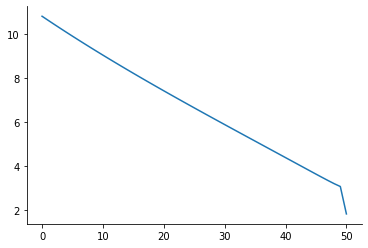

In [284]:
plt.plot(ems[:,0])

In [291]:
Y1t_jump,Y2t_jump, Et_jump = simualte_ems(y1_grid[:numy_bar+1], y2_grid, ems,  dt=1/4)

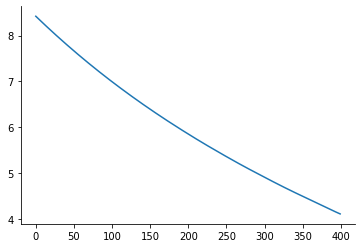

In [292]:
plt.plot(Et_jump)

(0.0, 14.938519166361448)

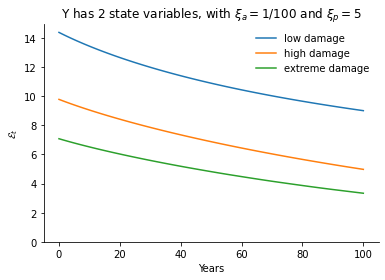

In [392]:
# years = np.arange(0, 100)
colors = ["C0", "C1", "C2"]
for et, dmg, color in zip(et_list_compare, ["low", "high", "extreme"], colors):
    plt.plot(et, label=dmg+" damage", color=color)
plt.legend(frameon=False)
plt.title("Y has 2 state variables, with $\\xi_a = 1/100$ and $\\xi_p = 5$")
plt.xlabel("Years")
plt.ylabel("$\mathcal{E}_t$")
plt.ylim(0)
# plt.savefig("./paper_plots/2state_ems.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")

In [361]:
et_list_compare[0]

array([14.38605019, 14.28160053, 14.17961706, 14.07993943, 13.98289768,
       13.88777467, 13.79439829, 13.70343825, 13.61393076, 13.52632166,
       13.44030241, 13.35586415, 13.27297318, 13.19152716, 13.1114758 ,
       13.03284699, 12.95539264, 12.87942728, 12.80434952, 12.73089279,
       12.65823922, 12.5869707 , 12.51664534, 12.44738408, 12.37926055,
       12.31188758, 12.24584628, 12.18043933, 12.11618528, 12.05270444,
       11.99009413, 11.92845307, 11.86742093, 11.80753619, 11.74815163,
       11.68979607, 11.63203571, 11.57508076, 11.51887652, 11.46329013,
       11.40860051, 11.35430822, 11.30098568, 11.2480216 , 11.19595664,
       11.14430906, 11.09341569, 11.04303044, 10.99329117, 10.9441425 ,
       10.89554777, 10.84760378, 10.80004016, 10.75314191, 10.70661577,
       10.66076997, 10.6152378 , 10.57040741, 10.52585265, 10.4820228 ,
       10.43844268, 10.39559536, 10.35297758, 10.31100387, 10.26922582,
       10.22809701, 10.18717361, 10.14685845, 10.10676103, 10.06

ValueError: x and y must have same first dimension, but have shapes (400,) and (101,)

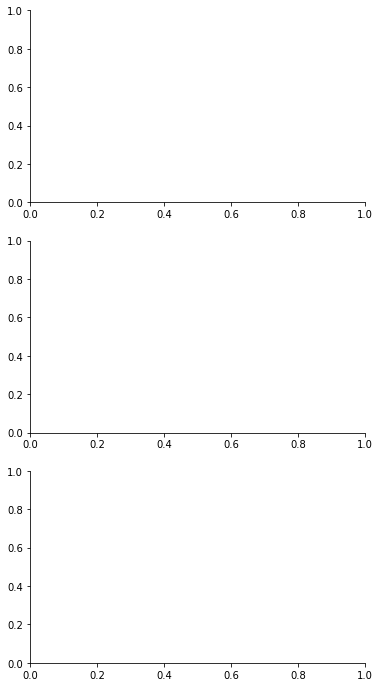

In [255]:
years = np.arange(0,100, 1/4)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(6,12))
ax1.plot(years, Et)
# ax1.plot(y1_mat[:,0], ems[:,49], label="$y_2$ = {:.2f}".format(y2_mat[0,49]))
# ax1.plot(y1_mat[:,0], ems[:,-1], label="$y_2$ = {:.2f}".format(y2_mat[0,-1]))
ax1.set_title('$\mathcal{E}_t$', size=20)
ax1.set_xlabel("Years", size=20)
ax1.set_xlim(0)
ax1.set_ylim(0)
# ax1.legend()
# ax1.set_ylim(0, 12)
ax2.plot(years, Y1t, label="$y_1$ = {:.2f}".format(y1_mat[0,0]))
ax2.set_title('$Y^1_t$', size=20)
ax2.set_xlabel('Years', size=20)
ax2.set_xlim(0)
ax2.set_ylim(0)
# ax2.legend()
# ax2.set_ylim(0,12)

ax3.plot(years, Y2t)
ax3.set_title('$Y_t^2$', size=20)
ax3.set_xlabel('Years', size=20)
ax3.set_ylim(0)
ax3.set_xlim(0)
fig.tight_layout()
# plt.savefig("simulation.png", bbox_inches="tight", facecolor="w", edgecolor="w")

In [ ]:
# simulate
def simulate_logkapital(invkap, αₖ,  σₖ, κ, k0, T=100, dt=1):
    periods = int(T/dt)
    Kt = np.zeros(periods)
    i = invkap
     # log capital
    Kt[0] = np.log(k0)
    k = np.log(k0)
    for t in range(periods-1):
        k +=   (αₖ + i - κ/2*i**2 - .5*σₖ**2)*dt
        Kt[t+1] = k
    return Kt

In [ ]:
invkap = 0.09
α = 0.115
αₖ = - 0.043
σₖ = 0.0085
κ = 6.667
k0 = 80/α

In [ ]:
Kt = simulate_logkapital(invkap, αₖ, σₖ, κ,  k0, dt=1/4)
MC = δ*(1-η)/((α - invkap)*np.exp(Kt))
scc = η*(α - invkap)*np.exp(Kt)/(1-η)/Et*1000

In [ ]:
plt.plot(years, scc)

In [168]:
# ξₘ is 1000, no ambiguity over damage
numy_bar = 50
y_min = 0
y_max = 4
hy = (ȳ - y_min)/numy_bar
y_grid = np.arange(y_min, y_max+hy, hy)
ς = 0.1
ξa = 1/100
ξw = 1000
ξp = 5
σy = 1e-5
dmg_weight = np.array([1/3, 1/3, 1/3])
args = (δ, η, θ_list, γ1, γ2, γ3_list, ȳ, dmg_weight, ς, ξp, ξa, ξw, σy)
solu, ϕ_list = approach_one_100(y_grid, numy_bar, args, ϵ=2, max_iter=5_000)
yt_1, et_1 = simulate_ems_1d(y_grid[:numy_bar+1], solu["ems"], dt=1/4)

episode: 5000,	 ode error: 9.905671455526233e-05,	 ft error: 3.316203585068678e-05
episode: 5000,	 ode error: 0.0004189112227439215,	 ft error: 2.3994517419301253e-05
episode: 812,	 ode error: 0.0020503496427756313,	 ft error: 9.875385842406104e-09
episode: 5000,	 ode error: 0.0015449065580850421,	 ft error: 1.7729717254388877e-05


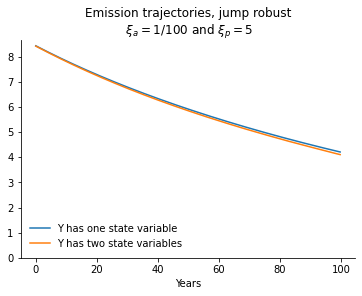

In [402]:
plt.plot(years, et_1, label="Y has one state variable")
plt.plot(years, Et_jump, label="Y has two state variables")
plt.ylim(0)
plt.xlabel("Years")
plt.title("Emission trajectories, jump robust\n $ξ_a = 1/100$ and $ξ_p = 5$")
plt.legend(frameon=False, loc=3)
# plt.savefig("./paper_plots/ems_12compare.png", dpi=400, facecolor="w", edgecolor="w", bbox_inches="tight")

In [167]:
def simulate_ems_1d(y1_grid, ems_1d, T=100, dt=1):
    periods = int(T/dt)
    Y1t = np.zeros(periods)
#     Y2t = np.zeros(periods)
    ems_t = np.zeros(periods)
    f = interpolate.interp1d(y1_grid, ems_1d,)
    y1 = θ*290
    y2 = 0.00186
    for t in range(periods):
        if y1 > np.max(y1_mat) or y2 > np.max(y2_mat):
            break
        ems_point = f(y1)
        ems_t[t] = ems_point
        Y1t[t] = y1
#         Y2t[t] = y2
        y1 += ems_point*θ*dt
#         y2 += ( - λ*y2 + λ*θ*ems_point)*dt
    return Y1t, ems_t

In [ ]:
y1_1d, et_1d = simualte_ems_1d(y1_grid, ems_1d, dt=1/4)

In [ ]:
plt.plot(years, et_1d)
plt.plot(years, Et)
plt.xlim(0)
plt.ylim(0, 20)

In [ ]:
scc_1d =  η*(α - invkap)*np.exp(Kt)/(1-η)/et_1d*1000
plt.plot(years, scc_1d, label="pde")
plt.plot(years, scc, label="ode")
plt.legend()